In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['nb_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'nb_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testconv", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
reload (rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [27]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003nb_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195520, 2) (49772, 2)
train/valid # (195520, 2) (49772, 2)


rand split across time
train has 195520 records out of 372221 records
valid has 49772 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1527
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1527 [..............................] - ETA: 42:27 - loss: 42.2554 - total_loss: 42.2554 - reg_loss: 8.6251

   6/1527 [..............................] - ETA: 7:17 - loss: 8.9350 - total_loss: 8.9350 - reg_loss: 4.2733   

  11/1527 [..............................] - ETA: 4:05 - loss: 5.9399 - total_loss: 5.9399 - reg_loss: 9.1009

  16/1527 [..............................] - ETA: 2:53 - loss: 4.8035 - total_loss: 4.8035 - reg_loss: 9.9843

  21/1527 [..............................] - ETA: 2:16 - loss: 4.1609 - total_loss: 4.1609 - reg_loss: 8.1480

  26/1527 [..............................] - ETA: 1:52 - loss: 3.7596 - total_loss: 3.7596 - reg_loss: 6.7323

  31/1527 [..............................] - ETA: 1:37 - loss: 3.4844 - total_loss: 3.4844 - reg_loss: 5.7575

  36/1527 [..............................] - ETA: 1:25 - loss: 3.2844 - total_loss: 3.2844 - reg_loss: 5.0810

  41/1527 [..............................] - ETA: 1:17 - loss: 3.1349 - total_loss: 3.1349 - reg_loss: 4.5229

  46/1527 [..............................] - ETA: 1:10 - loss: 3.0162 - total_loss: 3.0162 - reg_loss: 4.0884

  51/1527 [>.............................] - ETA: 1:04 - loss: 2.9232 - total_loss: 2.9232 - reg_loss: 3.7377

  56/1527 [>.............................] - ETA: 1:00 - loss: 2.8441 - total_loss: 2.8441 - reg_loss: 3.4533

  61/1527 [>.............................] - ETA: 56s - loss: 2.7776 - total_loss: 2.7776 - reg_loss: 3.2107 

  66/1527 [>.............................] - ETA: 53s - loss: 2.7235 - total_loss: 2.7235 - reg_loss: 3.0023

  71/1527 [>.............................] - ETA: 50s - loss: 2.6753 - total_loss: 2.6753 - reg_loss: 2.8277

  76/1527 [>.............................] - ETA: 48s - loss: 2.6349 - total_loss: 2.6349 - reg_loss: 2.6708

  81/1527 [>.............................] - ETA: 46s - loss: 2.5975 - total_loss: 2.5975 - reg_loss: 2.5313

  86/1527 [>.............................] - ETA: 44s - loss: 2.5659 - total_loss: 2.5659 - reg_loss: 2.4107

  90/1527 [>.............................] - ETA: 43s - loss: 2.5425 - total_loss: 2.5425 - reg_loss: 2.3206

  95/1527 [>.............................] - ETA: 41s - loss: 2.5166 - total_loss: 2.5166 - reg_loss: 2.2191

 100/1527 [>.............................] - ETA: 40s - loss: 2.4924 - total_loss: 2.4924 - reg_loss: 2.1295

 105/1527 [=>............................] - ETA: 38s - loss: 2.4706 - total_loss: 2.4706 - reg_loss: 2.0466

 110/1527 [=>............................] - ETA: 37s - loss: 2.4514 - total_loss: 2.4514 - reg_loss: 1.9714

 115/1527 [=>............................] - ETA: 36s - loss: 2.4332 - total_loss: 2.4332 - reg_loss: 1.9027

 120/1527 [=>............................] - ETA: 35s - loss: 2.4168 - total_loss: 2.4168 - reg_loss: 1.8400

 125/1527 [=>............................] - ETA: 34s - loss: 2.4015 - total_loss: 2.4015 - reg_loss: 1.7822

 130/1527 [=>............................] - ETA: 33s - loss: 2.3881 - total_loss: 2.3881 - reg_loss: 1.7277

 135/1527 [=>............................] - ETA: 33s - loss: 2.3746 - total_loss: 2.3746 - reg_loss: 1.6805

 140/1527 [=>............................] - ETA: 32s - loss: 2.3626 - total_loss: 2.3626 - reg_loss: 1.6330

 145/1527 [=>............................] - ETA: 31s - loss: 2.3510 - total_loss: 2.3510 - reg_loss: 1.5907

 150/1527 [=>............................] - ETA: 31s - loss: 2.3402 - total_loss: 2.3402 - reg_loss: 1.5503

 155/1527 [==>...........................] - ETA: 30s - loss: 2.3302 - total_loss: 2.3302 - reg_loss: 1.5131

 160/1527 [==>...........................] - ETA: 29s - loss: 2.3211 - total_loss: 2.3211 - reg_loss: 1.4780

 165/1527 [==>...........................] - ETA: 29s - loss: 2.3123 - total_loss: 2.3123 - reg_loss: 1.4457

 170/1527 [==>...........................] - ETA: 28s - loss: 2.3040 - total_loss: 2.3040 - reg_loss: 1.4151

 175/1527 [==>...........................] - ETA: 28s - loss: 2.2965 - total_loss: 2.2965 - reg_loss: 1.3852

 180/1527 [==>...........................] - ETA: 27s - loss: 2.2891 - total_loss: 2.2891 - reg_loss: 1.3578

 185/1527 [==>...........................] - ETA: 27s - loss: 2.2821 - total_loss: 2.2821 - reg_loss: 1.3307

 190/1527 [==>...........................] - ETA: 26s - loss: 2.2756 - total_loss: 2.2756 - reg_loss: 1.3068

 195/1527 [==>...........................] - ETA: 26s - loss: 2.2692 - total_loss: 2.2692 - reg_loss: 1.2836

 200/1527 [==>...........................] - ETA: 26s - loss: 2.2640 - total_loss: 2.2640 - reg_loss: 1.2610

 205/1527 [===>..........................] - ETA: 25s - loss: 2.2585 - total_loss: 2.2585 - reg_loss: 1.2389

 210/1527 [===>..........................] - ETA: 25s - loss: 2.2533 - total_loss: 2.2533 - reg_loss: 1.2176

 215/1527 [===>..........................] - ETA: 25s - loss: 2.2484 - total_loss: 2.2484 - reg_loss: 1.1989

 220/1527 [===>..........................] - ETA: 24s - loss: 2.2436 - total_loss: 2.2436 - reg_loss: 1.1807

 224/1527 [===>..........................] - ETA: 24s - loss: 2.2399 - total_loss: 2.2399 - reg_loss: 1.1661

 229/1527 [===>..........................] - ETA: 24s - loss: 2.2353 - total_loss: 2.2353 - reg_loss: 1.1486

 234/1527 [===>..........................] - ETA: 24s - loss: 2.2309 - total_loss: 2.2309 - reg_loss: 1.1324

 239/1527 [===>..........................] - ETA: 23s - loss: 2.2271 - total_loss: 2.2271 - reg_loss: 1.1166

 244/1527 [===>..........................] - ETA: 23s - loss: 2.2233 - total_loss: 2.2233 - reg_loss: 1.1009

 249/1527 [===>..........................] - ETA: 23s - loss: 2.2195 - total_loss: 2.2195 - reg_loss: 1.0859

 254/1527 [===>..........................] - ETA: 23s - loss: 2.2158 - total_loss: 2.2158 - reg_loss: 1.0714

 259/1527 [====>.........................] - ETA: 22s - loss: 2.2121 - total_loss: 2.2121 - reg_loss: 1.0569

 264/1527 [====>.........................] - ETA: 22s - loss: 2.2086 - total_loss: 2.2086 - reg_loss: 1.0435

 268/1527 [====>.........................] - ETA: 22s - loss: 2.2061 - total_loss: 2.2061 - reg_loss: 1.0331

 273/1527 [====>.........................] - ETA: 22s - loss: 2.2029 - total_loss: 2.2029 - reg_loss: 1.0217

 278/1527 [====>.........................] - ETA: 21s - loss: 2.1996 - total_loss: 2.1996 - reg_loss: 1.0089

 283/1527 [====>.........................] - ETA: 21s - loss: 2.1968 - total_loss: 2.1968 - reg_loss: 0.9970

 288/1527 [====>.........................] - ETA: 21s - loss: 2.1938 - total_loss: 2.1938 - reg_loss: 0.9859

 293/1527 [====>.........................] - ETA: 21s - loss: 2.1912 - total_loss: 2.1912 - reg_loss: 0.9746

 298/1527 [====>.........................] - ETA: 21s - loss: 2.1882 - total_loss: 2.1882 - reg_loss: 0.9640

 303/1527 [====>.........................] - ETA: 20s - loss: 2.1855 - total_loss: 2.1855 - reg_loss: 0.9538

 308/1527 [=====>........................] - ETA: 20s - loss: 2.1835 - total_loss: 2.1835 - reg_loss: 0.9435

 313/1527 [=====>........................] - ETA: 20s - loss: 2.1812 - total_loss: 2.1812 - reg_loss: 0.9336

 318/1527 [=====>........................] - ETA: 20s - loss: 2.1791 - total_loss: 2.1791 - reg_loss: 0.9257

 323/1527 [=====>........................] - ETA: 20s - loss: 2.1769 - total_loss: 2.1769 - reg_loss: 0.9169

 328/1527 [=====>........................] - ETA: 19s - loss: 2.1750 - total_loss: 2.1750 - reg_loss: 0.9083

 333/1527 [=====>........................] - ETA: 19s - loss: 2.1727 - total_loss: 2.1727 - reg_loss: 0.9000

 338/1527 [=====>........................] - ETA: 19s - loss: 2.1702 - total_loss: 2.1702 - reg_loss: 0.8923

 343/1527 [=====>........................] - ETA: 19s - loss: 2.1682 - total_loss: 2.1682 - reg_loss: 0.8843

 348/1527 [=====>........................] - ETA: 19s - loss: 2.1663 - total_loss: 2.1663 - reg_loss: 0.8765

 353/1527 [=====>........................] - ETA: 18s - loss: 2.1646 - total_loss: 2.1646 - reg_loss: 0.8693

 357/1527 [======>.......................] - ETA: 18s - loss: 2.1631 - total_loss: 2.1631 - reg_loss: 0.8640

 362/1527 [======>.......................] - ETA: 18s - loss: 2.1614 - total_loss: 2.1614 - reg_loss: 0.8565

 367/1527 [======>.......................] - ETA: 18s - loss: 2.1596 - total_loss: 2.1596 - reg_loss: 0.8497

 372/1527 [======>.......................] - ETA: 18s - loss: 2.1579 - total_loss: 2.1579 - reg_loss: 0.8420

 377/1527 [======>.......................] - ETA: 18s - loss: 2.1562 - total_loss: 2.1562 - reg_loss: 0.8363

 382/1527 [======>.......................] - ETA: 18s - loss: 2.1547 - total_loss: 2.1547 - reg_loss: 0.8296

 387/1527 [======>.......................] - ETA: 17s - loss: 2.1531 - total_loss: 2.1531 - reg_loss: 0.8235

 392/1527 [======>.......................] - ETA: 17s - loss: 2.1514 - total_loss: 2.1514 - reg_loss: 0.8176

 397/1527 [======>.......................] - ETA: 17s - loss: 2.1500 - total_loss: 2.1500 - reg_loss: 0.8116

 402/1527 [======>.......................] - ETA: 17s - loss: 2.1489 - total_loss: 2.1489 - reg_loss: 0.8059

 407/1527 [======>.......................] - ETA: 17s - loss: 2.1475 - total_loss: 2.1475 - reg_loss: 0.8000

 411/1527 [=======>......................] - ETA: 17s - loss: 2.1464 - total_loss: 2.1464 - reg_loss: 0.7956

 416/1527 [=======>......................] - ETA: 17s - loss: 2.1450 - total_loss: 2.1450 - reg_loss: 0.7896

 421/1527 [=======>......................] - ETA: 17s - loss: 2.1438 - total_loss: 2.1438 - reg_loss: 0.7840

 426/1527 [=======>......................] - ETA: 16s - loss: 2.1427 - total_loss: 2.1427 - reg_loss: 0.7783

 431/1527 [=======>......................] - ETA: 16s - loss: 2.1414 - total_loss: 2.1414 - reg_loss: 0.7729

 436/1527 [=======>......................] - ETA: 16s - loss: 2.1405 - total_loss: 2.1405 - reg_loss: 0.7673

 441/1527 [=======>......................] - ETA: 16s - loss: 2.1393 - total_loss: 2.1393 - reg_loss: 0.7625

 446/1527 [=======>......................] - ETA: 16s - loss: 2.1379 - total_loss: 2.1379 - reg_loss: 0.7580

 451/1527 [=======>......................] - ETA: 16s - loss: 2.1368 - total_loss: 2.1368 - reg_loss: 0.7531

 456/1527 [=======>......................] - ETA: 16s - loss: 2.1357 - total_loss: 2.1357 - reg_loss: 0.7478

 461/1527 [========>.....................] - ETA: 16s - loss: 2.1346 - total_loss: 2.1346 - reg_loss: 0.7430

 466/1527 [========>.....................] - ETA: 16s - loss: 2.1335 - total_loss: 2.1335 - reg_loss: 0.7384

 471/1527 [========>.....................] - ETA: 15s - loss: 2.1324 - total_loss: 2.1324 - reg_loss: 0.7340

 476/1527 [========>.....................] - ETA: 15s - loss: 2.1312 - total_loss: 2.1312 - reg_loss: 0.7293

 480/1527 [========>.....................] - ETA: 15s - loss: 2.1303 - total_loss: 2.1303 - reg_loss: 0.7257

 484/1527 [========>.....................] - ETA: 15s - loss: 2.1295 - total_loss: 2.1295 - reg_loss: 0.7225

 488/1527 [========>.....................] - ETA: 15s - loss: 2.1287 - total_loss: 2.1287 - reg_loss: 0.7196

 492/1527 [========>.....................] - ETA: 15s - loss: 2.1279 - total_loss: 2.1279 - reg_loss: 0.7163

 497/1527 [========>.....................] - ETA: 15s - loss: 2.1269 - total_loss: 2.1269 - reg_loss: 0.7127

 501/1527 [========>.....................] - ETA: 15s - loss: 2.1261 - total_loss: 2.1261 - reg_loss: 0.7097

 505/1527 [========>.....................] - ETA: 15s - loss: 2.1253 - total_loss: 2.1253 - reg_loss: 0.7068

 509/1527 [=========>....................] - ETA: 15s - loss: 2.1247 - total_loss: 2.1247 - reg_loss: 0.7040

 513/1527 [=========>....................] - ETA: 15s - loss: 2.1240 - total_loss: 2.1240 - reg_loss: 0.7015

 517/1527 [=========>....................] - ETA: 15s - loss: 2.1233 - total_loss: 2.1233 - reg_loss: 0.6985

 521/1527 [=========>....................] - ETA: 15s - loss: 2.1227 - total_loss: 2.1227 - reg_loss: 0.6955

 525/1527 [=========>....................] - ETA: 14s - loss: 2.1220 - total_loss: 2.1220 - reg_loss: 0.6927

 529/1527 [=========>....................] - ETA: 14s - loss: 2.1213 - total_loss: 2.1213 - reg_loss: 0.6900

 534/1527 [=========>....................] - ETA: 14s - loss: 2.1204 - total_loss: 2.1204 - reg_loss: 0.6865

 538/1527 [=========>....................] - ETA: 14s - loss: 2.1198 - total_loss: 2.1198 - reg_loss: 0.6838

 542/1527 [=========>....................] - ETA: 14s - loss: 2.1191 - total_loss: 2.1191 - reg_loss: 0.6810

 546/1527 [=========>....................] - ETA: 14s - loss: 2.1184 - total_loss: 2.1184 - reg_loss: 0.6785

 550/1527 [=========>....................] - ETA: 14s - loss: 2.1179 - total_loss: 2.1179 - reg_loss: 0.6757

 554/1527 [=========>....................] - ETA: 14s - loss: 2.1172 - total_loss: 2.1172 - reg_loss: 0.6730

 558/1527 [=========>....................] - ETA: 14s - loss: 2.1166 - total_loss: 2.1166 - reg_loss: 0.6704

 562/1527 [==========>...................] - ETA: 14s - loss: 2.1160 - total_loss: 2.1160 - reg_loss: 0.6680

 566/1527 [==========>...................] - ETA: 14s - loss: 2.1155 - total_loss: 2.1155 - reg_loss: 0.6655

 570/1527 [==========>...................] - ETA: 14s - loss: 2.1148 - total_loss: 2.1148 - reg_loss: 0.6631

 574/1527 [==========>...................] - ETA: 14s - loss: 2.1142 - total_loss: 2.1142 - reg_loss: 0.6608

 578/1527 [==========>...................] - ETA: 14s - loss: 2.1135 - total_loss: 2.1135 - reg_loss: 0.6587

 582/1527 [==========>...................] - ETA: 13s - loss: 2.1129 - total_loss: 2.1129 - reg_loss: 0.6564

 586/1527 [==========>...................] - ETA: 13s - loss: 2.1124 - total_loss: 2.1124 - reg_loss: 0.6540

 590/1527 [==========>...................] - ETA: 13s - loss: 2.1118 - total_loss: 2.1118 - reg_loss: 0.6519

 594/1527 [==========>...................] - ETA: 13s - loss: 2.1113 - total_loss: 2.1113 - reg_loss: 0.6497

 598/1527 [==========>...................] - ETA: 13s - loss: 2.1108 - total_loss: 2.1108 - reg_loss: 0.6470

 602/1527 [==========>...................] - ETA: 13s - loss: 2.1104 - total_loss: 2.1104 - reg_loss: 0.6454

 606/1527 [==========>...................] - ETA: 13s - loss: 2.1099 - total_loss: 2.1099 - reg_loss: 0.6433

 610/1527 [==========>...................] - ETA: 13s - loss: 2.1094 - total_loss: 2.1094 - reg_loss: 0.6413

 614/1527 [===========>..................] - ETA: 13s - loss: 2.1089 - total_loss: 2.1089 - reg_loss: 0.6391

 618/1527 [===========>..................] - ETA: 13s - loss: 2.1084 - total_loss: 2.1084 - reg_loss: 0.6368

 622/1527 [===========>..................] - ETA: 13s - loss: 2.1078 - total_loss: 2.1078 - reg_loss: 0.6351

 626/1527 [===========>..................] - ETA: 13s - loss: 2.1073 - total_loss: 2.1073 - reg_loss: 0.6330

 630/1527 [===========>..................] - ETA: 13s - loss: 2.1068 - total_loss: 2.1068 - reg_loss: 0.6308

 634/1527 [===========>..................] - ETA: 13s - loss: 2.1063 - total_loss: 2.1063 - reg_loss: 0.6289

 638/1527 [===========>..................] - ETA: 13s - loss: 2.1058 - total_loss: 2.1058 - reg_loss: 0.6269

 642/1527 [===========>..................] - ETA: 12s - loss: 2.1053 - total_loss: 2.1053 - reg_loss: 0.6249

 646/1527 [===========>..................] - ETA: 12s - loss: 2.1048 - total_loss: 2.1048 - reg_loss: 0.6231

 650/1527 [===========>..................] - ETA: 12s - loss: 2.1044 - total_loss: 2.1044 - reg_loss: 0.6212

 654/1527 [===========>..................] - ETA: 12s - loss: 2.1039 - total_loss: 2.1039 - reg_loss: 0.6192

 658/1527 [===========>..................] - ETA: 12s - loss: 2.1036 - total_loss: 2.1036 - reg_loss: 0.6174

 662/1527 [============>.................] - ETA: 12s - loss: 2.1031 - total_loss: 2.1031 - reg_loss: 0.6155

 666/1527 [============>.................] - ETA: 12s - loss: 2.1025 - total_loss: 2.1025 - reg_loss: 0.6135

 670/1527 [============>.................] - ETA: 12s - loss: 2.1020 - total_loss: 2.1020 - reg_loss: 0.6118

 674/1527 [============>.................] - ETA: 12s - loss: 2.1017 - total_loss: 2.1017 - reg_loss: 0.6102

 679/1527 [============>.................] - ETA: 12s - loss: 2.1013 - total_loss: 2.1013 - reg_loss: 0.6080

 683/1527 [============>.................] - ETA: 12s - loss: 2.1010 - total_loss: 2.1010 - reg_loss: 0.6063

 687/1527 [============>.................] - ETA: 12s - loss: 2.1007 - total_loss: 2.1007 - reg_loss: 0.6049

 691/1527 [============>.................] - ETA: 12s - loss: 2.1003 - total_loss: 2.1003 - reg_loss: 0.6034

 695/1527 [============>.................] - ETA: 12s - loss: 2.0998 - total_loss: 2.0998 - reg_loss: 0.6018

 699/1527 [============>.................] - ETA: 12s - loss: 2.0993 - total_loss: 2.0993 - reg_loss: 0.6003

 703/1527 [============>.................] - ETA: 12s - loss: 2.0989 - total_loss: 2.0989 - reg_loss: 0.5985

 707/1527 [============>.................] - ETA: 11s - loss: 2.0984 - total_loss: 2.0984 - reg_loss: 0.5972

 711/1527 [============>.................] - ETA: 11s - loss: 2.0981 - total_loss: 2.0981 - reg_loss: 0.5953

 715/1527 [=============>................] - ETA: 11s - loss: 2.0977 - total_loss: 2.0977 - reg_loss: 0.5936

 719/1527 [=============>................] - ETA: 11s - loss: 2.0974 - total_loss: 2.0974 - reg_loss: 0.5920

 723/1527 [=============>................] - ETA: 11s - loss: 2.0970 - total_loss: 2.0970 - reg_loss: 0.5905

 727/1527 [=============>................] - ETA: 11s - loss: 2.0967 - total_loss: 2.0967 - reg_loss: 0.5889

 731/1527 [=============>................] - ETA: 11s - loss: 2.0963 - total_loss: 2.0963 - reg_loss: 0.5873

 735/1527 [=============>................] - ETA: 11s - loss: 2.0960 - total_loss: 2.0960 - reg_loss: 0.5859

 739/1527 [=============>................] - ETA: 11s - loss: 2.0957 - total_loss: 2.0957 - reg_loss: 0.5847

 744/1527 [=============>................] - ETA: 11s - loss: 2.0952 - total_loss: 2.0952 - reg_loss: 0.5829

 748/1527 [=============>................] - ETA: 11s - loss: 2.0949 - total_loss: 2.0949 - reg_loss: 0.5819

 752/1527 [=============>................] - ETA: 11s - loss: 2.0946 - total_loss: 2.0946 - reg_loss: 0.5804

 756/1527 [=============>................] - ETA: 11s - loss: 2.0943 - total_loss: 2.0943 - reg_loss: 0.5787

 760/1527 [=============>................] - ETA: 11s - loss: 2.0940 - total_loss: 2.0940 - reg_loss: 0.5772

 764/1527 [==============>...............] - ETA: 11s - loss: 2.0937 - total_loss: 2.0937 - reg_loss: 0.5758

 768/1527 [==============>...............] - ETA: 11s - loss: 2.0933 - total_loss: 2.0933 - reg_loss: 0.5745

 772/1527 [==============>...............] - ETA: 10s - loss: 2.0930 - total_loss: 2.0930 - reg_loss: 0.5732

 776/1527 [==============>...............] - ETA: 10s - loss: 2.0928 - total_loss: 2.0928 - reg_loss: 0.5718

 780/1527 [==============>...............] - ETA: 10s - loss: 2.0924 - total_loss: 2.0924 - reg_loss: 0.5705

 784/1527 [==============>...............] - ETA: 10s - loss: 2.0921 - total_loss: 2.0921 - reg_loss: 0.5690

 788/1527 [==============>...............] - ETA: 10s - loss: 2.0918 - total_loss: 2.0918 - reg_loss: 0.5678

 792/1527 [==============>...............] - ETA: 10s - loss: 2.0915 - total_loss: 2.0915 - reg_loss: 0.5664

 796/1527 [==============>...............] - ETA: 10s - loss: 2.0912 - total_loss: 2.0912 - reg_loss: 0.5653

 800/1527 [==============>...............] - ETA: 10s - loss: 2.0909 - total_loss: 2.0909 - reg_loss: 0.5640

 804/1527 [==============>...............] - ETA: 10s - loss: 2.0906 - total_loss: 2.0906 - reg_loss: 0.5629

 808/1527 [==============>...............] - ETA: 10s - loss: 2.0903 - total_loss: 2.0903 - reg_loss: 0.5615

 812/1527 [==============>...............] - ETA: 10s - loss: 2.0900 - total_loss: 2.0900 - reg_loss: 0.5601

 816/1527 [===============>..............] - ETA: 10s - loss: 2.0897 - total_loss: 2.0897 - reg_loss: 0.5587

 820/1527 [===============>..............] - ETA: 10s - loss: 2.0893 - total_loss: 2.0893 - reg_loss: 0.5574

 824/1527 [===============>..............] - ETA: 10s - loss: 2.0890 - total_loss: 2.0890 - reg_loss: 0.5562

 828/1527 [===============>..............] - ETA: 10s - loss: 2.0888 - total_loss: 2.0888 - reg_loss: 0.5548

 832/1527 [===============>..............] - ETA: 10s - loss: 2.0884 - total_loss: 2.0884 - reg_loss: 0.5539

 836/1527 [===============>..............] - ETA: 9s - loss: 2.0882 - total_loss: 2.0882 - reg_loss: 0.5527 

 840/1527 [===============>..............] - ETA: 9s - loss: 2.0879 - total_loss: 2.0879 - reg_loss: 0.5517

 844/1527 [===============>..............] - ETA: 9s - loss: 2.0876 - total_loss: 2.0876 - reg_loss: 0.5506

 848/1527 [===============>..............] - ETA: 9s - loss: 2.0873 - total_loss: 2.0873 - reg_loss: 0.5495

 852/1527 [===============>..............] - ETA: 9s - loss: 2.0871 - total_loss: 2.0871 - reg_loss: 0.5485

 856/1527 [===============>..............] - ETA: 9s - loss: 2.0869 - total_loss: 2.0869 - reg_loss: 0.5473

 860/1527 [===============>..............] - ETA: 9s - loss: 2.0866 - total_loss: 2.0866 - reg_loss: 0.5462

 864/1527 [===============>..............] - ETA: 9s - loss: 2.0864 - total_loss: 2.0864 - reg_loss: 0.5451

 868/1527 [================>.............] - ETA: 9s - loss: 2.0861 - total_loss: 2.0861 - reg_loss: 0.5440

 872/1527 [================>.............] - ETA: 9s - loss: 2.0858 - total_loss: 2.0858 - reg_loss: 0.5429

 876/1527 [================>.............] - ETA: 9s - loss: 2.0856 - total_loss: 2.0856 - reg_loss: 0.5416

 880/1527 [================>.............] - ETA: 9s - loss: 2.0853 - total_loss: 2.0853 - reg_loss: 0.5402

 884/1527 [================>.............] - ETA: 9s - loss: 2.0849 - total_loss: 2.0849 - reg_loss: 0.5391

 888/1527 [================>.............] - ETA: 9s - loss: 2.0847 - total_loss: 2.0847 - reg_loss: 0.5380

 892/1527 [================>.............] - ETA: 9s - loss: 2.0844 - total_loss: 2.0844 - reg_loss: 0.5371

 896/1527 [================>.............] - ETA: 9s - loss: 2.0842 - total_loss: 2.0842 - reg_loss: 0.5359

 900/1527 [================>.............] - ETA: 9s - loss: 2.0840 - total_loss: 2.0840 - reg_loss: 0.5349

 904/1527 [================>.............] - ETA: 8s - loss: 2.0837 - total_loss: 2.0837 - reg_loss: 0.5342

 908/1527 [================>.............] - ETA: 8s - loss: 2.0834 - total_loss: 2.0834 - reg_loss: 0.5332

 912/1527 [================>.............] - ETA: 8s - loss: 2.0832 - total_loss: 2.0832 - reg_loss: 0.5323

 916/1527 [================>.............] - ETA: 8s - loss: 2.0831 - total_loss: 2.0831 - reg_loss: 0.5314

 920/1527 [=================>............] - ETA: 8s - loss: 2.0829 - total_loss: 2.0829 - reg_loss: 0.5302

 924/1527 [=================>............] - ETA: 8s - loss: 2.0827 - total_loss: 2.0827 - reg_loss: 0.5291

 928/1527 [=================>............] - ETA: 8s - loss: 2.0824 - total_loss: 2.0824 - reg_loss: 0.5281

 932/1527 [=================>............] - ETA: 8s - loss: 2.0822 - total_loss: 2.0822 - reg_loss: 0.5272

 936/1527 [=================>............] - ETA: 8s - loss: 2.0819 - total_loss: 2.0819 - reg_loss: 0.5263

 940/1527 [=================>............] - ETA: 8s - loss: 2.0818 - total_loss: 2.0818 - reg_loss: 0.5254

 945/1527 [=================>............] - ETA: 8s - loss: 2.0816 - total_loss: 2.0816 - reg_loss: 0.5244

 949/1527 [=================>............] - ETA: 8s - loss: 2.0814 - total_loss: 2.0814 - reg_loss: 0.5235

 953/1527 [=================>............] - ETA: 8s - loss: 2.0812 - total_loss: 2.0812 - reg_loss: 0.5225

 957/1527 [=================>............] - ETA: 8s - loss: 2.0810 - total_loss: 2.0810 - reg_loss: 0.5217

 961/1527 [=================>............] - ETA: 8s - loss: 2.0808 - total_loss: 2.0808 - reg_loss: 0.5209

 965/1527 [=================>............] - ETA: 8s - loss: 2.0805 - total_loss: 2.0805 - reg_loss: 0.5200

 970/1527 [==================>...........] - ETA: 7s - loss: 2.0804 - total_loss: 2.0804 - reg_loss: 0.5190

 974/1527 [==================>...........] - ETA: 7s - loss: 2.0802 - total_loss: 2.0802 - reg_loss: 0.5181

 978/1527 [==================>...........] - ETA: 7s - loss: 2.0800 - total_loss: 2.0800 - reg_loss: 0.5171

 982/1527 [==================>...........] - ETA: 7s - loss: 2.0798 - total_loss: 2.0798 - reg_loss: 0.5162

 986/1527 [==================>...........] - ETA: 7s - loss: 2.0796 - total_loss: 2.0796 - reg_loss: 0.5153

 990/1527 [==================>...........] - ETA: 7s - loss: 2.0795 - total_loss: 2.0795 - reg_loss: 0.5144

 994/1527 [==================>...........] - ETA: 7s - loss: 2.0793 - total_loss: 2.0793 - reg_loss: 0.5135

 998/1527 [==================>...........] - ETA: 7s - loss: 2.0792 - total_loss: 2.0792 - reg_loss: 0.5125

1003/1527 [==================>...........] - ETA: 7s - loss: 2.0790 - total_loss: 2.0790 - reg_loss: 0.5114

1007/1527 [==================>...........] - ETA: 7s - loss: 2.0789 - total_loss: 2.0789 - reg_loss: 0.5107

1011/1527 [==================>...........] - ETA: 7s - loss: 2.0787 - total_loss: 2.0787 - reg_loss: 0.5099

1015/1527 [==================>...........] - ETA: 7s - loss: 2.0785 - total_loss: 2.0785 - reg_loss: 0.5089

1019/1527 [===================>..........] - ETA: 7s - loss: 2.0783 - total_loss: 2.0783 - reg_loss: 0.5081

1023/1527 [===================>..........] - ETA: 7s - loss: 2.0781 - total_loss: 2.0781 - reg_loss: 0.5072

1027/1527 [===================>..........] - ETA: 7s - loss: 2.0779 - total_loss: 2.0779 - reg_loss: 0.5066

1031/1527 [===================>..........] - ETA: 7s - loss: 2.0776 - total_loss: 2.0776 - reg_loss: 0.5057

1035/1527 [===================>..........] - ETA: 7s - loss: 2.0775 - total_loss: 2.0775 - reg_loss: 0.5049

1039/1527 [===================>..........] - ETA: 6s - loss: 2.0773 - total_loss: 2.0773 - reg_loss: 0.5042

1043/1527 [===================>..........] - ETA: 6s - loss: 2.0772 - total_loss: 2.0772 - reg_loss: 0.5034

1047/1527 [===================>..........] - ETA: 6s - loss: 2.0770 - total_loss: 2.0770 - reg_loss: 0.5028

1051/1527 [===================>..........] - ETA: 6s - loss: 2.0768 - total_loss: 2.0768 - reg_loss: 0.5021

1056/1527 [===================>..........] - ETA: 6s - loss: 2.0765 - total_loss: 2.0765 - reg_loss: 0.5012

1060/1527 [===================>..........] - ETA: 6s - loss: 2.0763 - total_loss: 2.0763 - reg_loss: 0.5004

1064/1527 [===================>..........] - ETA: 6s - loss: 2.0761 - total_loss: 2.0761 - reg_loss: 0.4997

1068/1527 [===================>..........] - ETA: 6s - loss: 2.0760 - total_loss: 2.0760 - reg_loss: 0.4990

1072/1527 [====================>.........] - ETA: 6s - loss: 2.0758 - total_loss: 2.0758 - reg_loss: 0.4983

1076/1527 [====================>.........] - ETA: 6s - loss: 2.0756 - total_loss: 2.0756 - reg_loss: 0.4978

1080/1527 [====================>.........] - ETA: 6s - loss: 2.0755 - total_loss: 2.0755 - reg_loss: 0.4970

1084/1527 [====================>.........] - ETA: 6s - loss: 2.0753 - total_loss: 2.0753 - reg_loss: 0.4961

1088/1527 [====================>.........] - ETA: 6s - loss: 2.0753 - total_loss: 2.0753 - reg_loss: 0.4954

1092/1527 [====================>.........] - ETA: 6s - loss: 2.0752 - total_loss: 2.0752 - reg_loss: 0.4947

1097/1527 [====================>.........] - ETA: 6s - loss: 2.0749 - total_loss: 2.0749 - reg_loss: 0.4939

1101/1527 [====================>.........] - ETA: 6s - loss: 2.0747 - total_loss: 2.0747 - reg_loss: 0.4931

1105/1527 [====================>.........] - ETA: 5s - loss: 2.0746 - total_loss: 2.0746 - reg_loss: 0.4924

1109/1527 [====================>.........] - ETA: 5s - loss: 2.0745 - total_loss: 2.0745 - reg_loss: 0.4917

1113/1527 [====================>.........] - ETA: 5s - loss: 2.0743 - total_loss: 2.0743 - reg_loss: 0.4910

1117/1527 [====================>.........] - ETA: 5s - loss: 2.0741 - total_loss: 2.0741 - reg_loss: 0.4905

1121/1527 [=====================>........] - ETA: 5s - loss: 2.0739 - total_loss: 2.0739 - reg_loss: 0.4900

1125/1527 [=====================>........] - ETA: 5s - loss: 2.0738 - total_loss: 2.0738 - reg_loss: 0.4894

1129/1527 [=====================>........] - ETA: 5s - loss: 2.0737 - total_loss: 2.0737 - reg_loss: 0.4887

1133/1527 [=====================>........] - ETA: 5s - loss: 2.0735 - total_loss: 2.0735 - reg_loss: 0.4881

1137/1527 [=====================>........] - ETA: 5s - loss: 2.0734 - total_loss: 2.0734 - reg_loss: 0.4874

1141/1527 [=====================>........] - ETA: 5s - loss: 2.0733 - total_loss: 2.0733 - reg_loss: 0.4867

1145/1527 [=====================>........] - ETA: 5s - loss: 2.0731 - total_loss: 2.0731 - reg_loss: 0.4861

1149/1527 [=====================>........] - ETA: 5s - loss: 2.0729 - total_loss: 2.0729 - reg_loss: 0.4854

1153/1527 [=====================>........] - ETA: 5s - loss: 2.0729 - total_loss: 2.0729 - reg_loss: 0.4847

1157/1527 [=====================>........] - ETA: 5s - loss: 2.0728 - total_loss: 2.0728 - reg_loss: 0.4841

1161/1527 [=====================>........] - ETA: 5s - loss: 2.0726 - total_loss: 2.0726 - reg_loss: 0.4836

1165/1527 [=====================>........] - ETA: 5s - loss: 2.0725 - total_loss: 2.0725 - reg_loss: 0.4831

1169/1527 [=====================>........] - ETA: 5s - loss: 2.0724 - total_loss: 2.0724 - reg_loss: 0.4825

1173/1527 [======================>.......] - ETA: 5s - loss: 2.0723 - total_loss: 2.0723 - reg_loss: 0.4819

1177/1527 [======================>.......] - ETA: 4s - loss: 2.0722 - total_loss: 2.0722 - reg_loss: 0.4813

1181/1527 [======================>.......] - ETA: 4s - loss: 2.0720 - total_loss: 2.0720 - reg_loss: 0.4806

1185/1527 [======================>.......] - ETA: 4s - loss: 2.0719 - total_loss: 2.0719 - reg_loss: 0.4799

1190/1527 [======================>.......] - ETA: 4s - loss: 2.0718 - total_loss: 2.0718 - reg_loss: 0.4791

1194/1527 [======================>.......] - ETA: 4s - loss: 2.0716 - total_loss: 2.0716 - reg_loss: 0.4784

1198/1527 [======================>.......] - ETA: 4s - loss: 2.0714 - total_loss: 2.0714 - reg_loss: 0.4778

1202/1527 [======================>.......] - ETA: 4s - loss: 2.0713 - total_loss: 2.0713 - reg_loss: 0.4773

1206/1527 [======================>.......] - ETA: 4s - loss: 2.0712 - total_loss: 2.0712 - reg_loss: 0.4766

1210/1527 [======================>.......] - ETA: 4s - loss: 2.0711 - total_loss: 2.0711 - reg_loss: 0.4759

1215/1527 [======================>.......] - ETA: 4s - loss: 2.0710 - total_loss: 2.0710 - reg_loss: 0.4752

1219/1527 [======================>.......] - ETA: 4s - loss: 2.0709 - total_loss: 2.0709 - reg_loss: 0.4745

1223/1527 [=======================>......] - ETA: 4s - loss: 2.0708 - total_loss: 2.0708 - reg_loss: 0.4740

1228/1527 [=======================>......] - ETA: 4s - loss: 2.0707 - total_loss: 2.0707 - reg_loss: 0.4733

1232/1527 [=======================>......] - ETA: 4s - loss: 2.0706 - total_loss: 2.0706 - reg_loss: 0.4726

1236/1527 [=======================>......] - ETA: 4s - loss: 2.0704 - total_loss: 2.0704 - reg_loss: 0.4720

1240/1527 [=======================>......] - ETA: 4s - loss: 2.0702 - total_loss: 2.0702 - reg_loss: 0.4716

1244/1527 [=======================>......] - ETA: 3s - loss: 2.0701 - total_loss: 2.0701 - reg_loss: 0.4713

1248/1527 [=======================>......] - ETA: 3s - loss: 2.0700 - total_loss: 2.0700 - reg_loss: 0.4708

1252/1527 [=======================>......] - ETA: 3s - loss: 2.0698 - total_loss: 2.0698 - reg_loss: 0.4702

1256/1527 [=======================>......] - ETA: 3s - loss: 2.0697 - total_loss: 2.0697 - reg_loss: 0.4698

1260/1527 [=======================>......] - ETA: 3s - loss: 2.0696 - total_loss: 2.0696 - reg_loss: 0.4693

1264/1527 [=======================>......] - ETA: 3s - loss: 2.0694 - total_loss: 2.0694 - reg_loss: 0.4685

1268/1527 [=======================>......] - ETA: 3s - loss: 2.0693 - total_loss: 2.0693 - reg_loss: 0.4681

1272/1527 [=======================>......] - ETA: 3s - loss: 2.0692 - total_loss: 2.0692 - reg_loss: 0.4675

1276/1527 [========================>.....] - ETA: 3s - loss: 2.0691 - total_loss: 2.0691 - reg_loss: 0.4670

1280/1527 [========================>.....] - ETA: 3s - loss: 2.0690 - total_loss: 2.0690 - reg_loss: 0.4666

1284/1527 [========================>.....] - ETA: 3s - loss: 2.0689 - total_loss: 2.0689 - reg_loss: 0.4660

1288/1527 [========================>.....] - ETA: 3s - loss: 2.0688 - total_loss: 2.0688 - reg_loss: 0.4654

1292/1527 [========================>.....] - ETA: 3s - loss: 2.0687 - total_loss: 2.0687 - reg_loss: 0.4650

1296/1527 [========================>.....] - ETA: 3s - loss: 2.0686 - total_loss: 2.0686 - reg_loss: 0.4645

1300/1527 [========================>.....] - ETA: 3s - loss: 2.0685 - total_loss: 2.0685 - reg_loss: 0.4640

1304/1527 [========================>.....] - ETA: 3s - loss: 2.0684 - total_loss: 2.0684 - reg_loss: 0.4633

1308/1527 [========================>.....] - ETA: 3s - loss: 2.0683 - total_loss: 2.0683 - reg_loss: 0.4629

1312/1527 [========================>.....] - ETA: 3s - loss: 2.0682 - total_loss: 2.0682 - reg_loss: 0.4623

1316/1527 [========================>.....] - ETA: 2s - loss: 2.0681 - total_loss: 2.0681 - reg_loss: 0.4617

1320/1527 [========================>.....] - ETA: 2s - loss: 2.0680 - total_loss: 2.0680 - reg_loss: 0.4613

1324/1527 [=========================>....] - ETA: 2s - loss: 2.0680 - total_loss: 2.0680 - reg_loss: 0.4606

1328/1527 [=========================>....] - ETA: 2s - loss: 2.0679 - total_loss: 2.0679 - reg_loss: 0.4602

1332/1527 [=========================>....] - ETA: 2s - loss: 2.0678 - total_loss: 2.0678 - reg_loss: 0.4596

1336/1527 [=========================>....] - ETA: 2s - loss: 2.0677 - total_loss: 2.0677 - reg_loss: 0.4592

1340/1527 [=========================>....] - ETA: 2s - loss: 2.0675 - total_loss: 2.0675 - reg_loss: 0.4586

1344/1527 [=========================>....] - ETA: 2s - loss: 2.0674 - total_loss: 2.0674 - reg_loss: 0.4582

1348/1527 [=========================>....] - ETA: 2s - loss: 2.0673 - total_loss: 2.0673 - reg_loss: 0.4578

1352/1527 [=========================>....] - ETA: 2s - loss: 2.0671 - total_loss: 2.0671 - reg_loss: 0.4572

1356/1527 [=========================>....] - ETA: 2s - loss: 2.0670 - total_loss: 2.0670 - reg_loss: 0.4566

1360/1527 [=========================>....] - ETA: 2s - loss: 2.0669 - total_loss: 2.0669 - reg_loss: 0.4561

1364/1527 [=========================>....] - ETA: 2s - loss: 2.0668 - total_loss: 2.0668 - reg_loss: 0.4555

1368/1527 [=========================>....] - ETA: 2s - loss: 2.0667 - total_loss: 2.0667 - reg_loss: 0.4551

1372/1527 [=========================>....] - ETA: 2s - loss: 2.0666 - total_loss: 2.0666 - reg_loss: 0.4545

1376/1527 [==========================>...] - ETA: 2s - loss: 2.0665 - total_loss: 2.0665 - reg_loss: 0.4540

1380/1527 [==========================>...] - ETA: 2s - loss: 2.0664 - total_loss: 2.0664 - reg_loss: 0.4536

1384/1527 [==========================>...] - ETA: 2s - loss: 2.0663 - total_loss: 2.0663 - reg_loss: 0.4532

1388/1527 [==========================>...] - ETA: 1s - loss: 2.0662 - total_loss: 2.0662 - reg_loss: 0.4528

1392/1527 [==========================>...] - ETA: 1s - loss: 2.0661 - total_loss: 2.0661 - reg_loss: 0.4524

1396/1527 [==========================>...] - ETA: 1s - loss: 2.0660 - total_loss: 2.0660 - reg_loss: 0.4520

1400/1527 [==========================>...] - ETA: 1s - loss: 2.0659 - total_loss: 2.0659 - reg_loss: 0.4514

1404/1527 [==========================>...] - ETA: 1s - loss: 2.0658 - total_loss: 2.0658 - reg_loss: 0.4511

1408/1527 [==========================>...] - ETA: 1s - loss: 2.0657 - total_loss: 2.0657 - reg_loss: 0.4508

1412/1527 [==========================>...] - ETA: 1s - loss: 2.0656 - total_loss: 2.0656 - reg_loss: 0.4503

1416/1527 [==========================>...] - ETA: 1s - loss: 2.0655 - total_loss: 2.0655 - reg_loss: 0.4499

1420/1527 [==========================>...] - ETA: 1s - loss: 2.0654 - total_loss: 2.0654 - reg_loss: 0.4495

1424/1527 [==========================>...] - ETA: 1s - loss: 2.0653 - total_loss: 2.0653 - reg_loss: 0.4490

1428/1527 [===========================>..] - ETA: 1s - loss: 2.0652 - total_loss: 2.0652 - reg_loss: 0.4486

1432/1527 [===========================>..] - ETA: 1s - loss: 2.0651 - total_loss: 2.0651 - reg_loss: 0.4482

1436/1527 [===========================>..] - ETA: 1s - loss: 2.0650 - total_loss: 2.0650 - reg_loss: 0.4478

1441/1527 [===========================>..] - ETA: 1s - loss: 2.0649 - total_loss: 2.0649 - reg_loss: 0.4473

1445/1527 [===========================>..] - ETA: 1s - loss: 2.0648 - total_loss: 2.0648 - reg_loss: 0.4468

1449/1527 [===========================>..] - ETA: 1s - loss: 2.0648 - total_loss: 2.0648 - reg_loss: 0.4463

1453/1527 [===========================>..] - ETA: 1s - loss: 2.0647 - total_loss: 2.0647 - reg_loss: 0.4458

1457/1527 [===========================>..] - ETA: 0s - loss: 2.0647 - total_loss: 2.0647 - reg_loss: 0.4455

1461/1527 [===========================>..] - ETA: 0s - loss: 2.0646 - total_loss: 2.0646 - reg_loss: 0.4452

1465/1527 [===========================>..] - ETA: 0s - loss: 2.0645 - total_loss: 2.0645 - reg_loss: 0.4448

1469/1527 [===========================>..] - ETA: 0s - loss: 2.0644 - total_loss: 2.0644 - reg_loss: 0.4445

1473/1527 [===========================>..] - ETA: 0s - loss: 2.0643 - total_loss: 2.0643 - reg_loss: 0.4441

1477/1527 [============================>.] - ETA: 0s - loss: 2.0642 - total_loss: 2.0642 - reg_loss: 0.4438

1481/1527 [============================>.] - ETA: 0s - loss: 2.0641 - total_loss: 2.0641 - reg_loss: 0.4433

1485/1527 [============================>.] - ETA: 0s - loss: 2.0640 - total_loss: 2.0640 - reg_loss: 0.4429

1489/1527 [============================>.] - ETA: 0s - loss: 2.0639 - total_loss: 2.0639 - reg_loss: 0.4424

1493/1527 [============================>.] - ETA: 0s - loss: 2.0638 - total_loss: 2.0638 - reg_loss: 0.4422

1497/1527 [============================>.] - ETA: 0s - loss: 2.0637 - total_loss: 2.0637 - reg_loss: 0.4416

1501/1527 [============================>.] - ETA: 0s - loss: 2.0636 - total_loss: 2.0636 - reg_loss: 0.4412

1505/1527 [============================>.] - ETA: 0s - loss: 2.0635 - total_loss: 2.0635 - reg_loss: 0.4409

1509/1527 [============================>.] - ETA: 0s - loss: 2.0635 - total_loss: 2.0635 - reg_loss: 0.4404

1513/1527 [============================>.] - ETA: 0s - loss: 2.0634 - total_loss: 2.0634 - reg_loss: 0.4400

1517/1527 [============================>.] - ETA: 0s - loss: 2.0633 - total_loss: 2.0633 - reg_loss: 0.4396

1521/1527 [============================>.] - ETA: 0s - loss: 2.0633 - total_loss: 2.0633 - reg_loss: 0.4392

1525/1527 [============================>.] - ETA: 0s - loss: 2.0632 - total_loss: 2.0632 - reg_loss: 0.4390

Epoch 00001: saving model to testconv/model_adam.001.h5
1527/1527 [==============================] - 24s 16ms/step - loss: 2.0631 - total_loss: 2.0631 - reg_loss: 0.4388 - val_loss: 2.0307 - val_total_loss: 2.0307 - val_reg_loss: 0.2967


Epoch 2/100
   1/1527 [..............................] - ETA: 18s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2209

   5/1527 [..............................] - ETA: 20s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2634

   9/1527 [..............................] - ETA: 20s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.3049

  14/1527 [..............................] - ETA: 19s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2993

  18/1527 [..............................] - ETA: 20s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.3044

  22/1527 [..............................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2988

  26/1527 [..............................] - ETA: 20s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2999

  30/1527 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.3024

  34/1527 [..............................] - ETA: 20s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2995

  38/1527 [..............................] - ETA: 20s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.3038

  42/1527 [..............................] - ETA: 20s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2988

  46/1527 [..............................] - ETA: 20s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2980

  50/1527 [..............................] - ETA: 20s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2979

  54/1527 [>.............................] - ETA: 20s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2994

  58/1527 [>.............................] - ETA: 20s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2968

  62/1527 [>.............................] - ETA: 20s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2998

  66/1527 [>.............................] - ETA: 20s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2995

  70/1527 [>.............................] - ETA: 19s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2993

  74/1527 [>.............................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.3021

  78/1527 [>.............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3004

  82/1527 [>.............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2989

  86/1527 [>.............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2981

  90/1527 [>.............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2980

  94/1527 [>.............................] - ETA: 19s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2975

  98/1527 [>.............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2978

 102/1527 [=>............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2980

 106/1527 [=>............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2974

 110/1527 [=>............................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2956

 114/1527 [=>............................] - ETA: 19s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2951

 118/1527 [=>............................] - ETA: 19s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2941

 122/1527 [=>............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2932

 126/1527 [=>............................] - ETA: 19s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2946

 130/1527 [=>............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2945

 134/1527 [=>............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2941

 138/1527 [=>............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2934

 142/1527 [=>............................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2938

 146/1527 [=>............................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2936

 150/1527 [=>............................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2940

 154/1527 [==>...........................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2935

 158/1527 [==>...........................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2934

 162/1527 [==>...........................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2926

 166/1527 [==>...........................] - ETA: 18s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2930

 170/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2925

 174/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2926

 178/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2922

 182/1527 [==>...........................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2931

 186/1527 [==>...........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2940

 190/1527 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2940

 194/1527 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2935

 198/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2936

 202/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2937

 206/1527 [===>..........................] - ETA: 18s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2940

 210/1527 [===>..........................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2942

 214/1527 [===>..........................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2947

 218/1527 [===>..........................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2938

 222/1527 [===>..........................] - ETA: 18s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2935

 226/1527 [===>..........................] - ETA: 18s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2932

 230/1527 [===>..........................] - ETA: 17s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2921

 234/1527 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2923

 238/1527 [===>..........................] - ETA: 17s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2923

 242/1527 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2921

 246/1527 [===>..........................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2924

 250/1527 [===>..........................] - ETA: 17s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2917

 254/1527 [===>..........................] - ETA: 17s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2921

 258/1527 [====>.........................] - ETA: 17s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2921

 262/1527 [====>.........................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2923

 266/1527 [====>.........................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2916

 270/1527 [====>.........................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2913

 274/1527 [====>.........................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2920

 278/1527 [====>.........................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2919

 282/1527 [====>.........................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2915

 286/1527 [====>.........................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2912

 291/1527 [====>.........................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2910

 295/1527 [====>.........................] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2910

 299/1527 [====>.........................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2907

 303/1527 [====>.........................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2906

 307/1527 [=====>........................] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2906

 311/1527 [=====>........................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2907

 315/1527 [=====>........................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2903

 319/1527 [=====>........................] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2902

 323/1527 [=====>........................] - ETA: 16s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2899

 327/1527 [=====>........................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2898

 331/1527 [=====>........................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2900

 335/1527 [=====>........................] - ETA: 16s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2903

 339/1527 [=====>........................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2900

 343/1527 [=====>........................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2902

 347/1527 [=====>........................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2898

 351/1527 [=====>........................] - ETA: 16s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2897

 355/1527 [=====>........................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2894

 359/1527 [======>.......................] - ETA: 16s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2891

 363/1527 [======>.......................] - ETA: 16s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2887

 367/1527 [======>.......................] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2884

 371/1527 [======>.......................] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2882

 375/1527 [======>.......................] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2880

 379/1527 [======>.......................] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2881

 383/1527 [======>.......................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2881

 387/1527 [======>.......................] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2879

 391/1527 [======>.......................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2883

 395/1527 [======>.......................] - ETA: 15s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2881

 399/1527 [======>.......................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2881

 403/1527 [======>.......................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2880

 408/1527 [=======>......................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2881

 412/1527 [=======>......................] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2878

 416/1527 [=======>......................] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2876

 421/1527 [=======>......................] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2879

 425/1527 [=======>......................] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2878

 429/1527 [=======>......................] - ETA: 15s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2878

 433/1527 [=======>......................] - ETA: 14s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2877

 437/1527 [=======>......................] - ETA: 14s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2880

 441/1527 [=======>......................] - ETA: 14s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2880

 445/1527 [=======>......................] - ETA: 14s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2878

 449/1527 [=======>......................] - ETA: 14s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2877

 453/1527 [=======>......................] - ETA: 14s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2873

 457/1527 [=======>......................] - ETA: 14s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2868

 461/1527 [========>.....................] - ETA: 14s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2866

 465/1527 [========>.....................] - ETA: 14s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2867

 469/1527 [========>.....................] - ETA: 14s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2867

 473/1527 [========>.....................] - ETA: 14s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2866

 477/1527 [========>.....................] - ETA: 14s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2865

 481/1527 [========>.....................] - ETA: 14s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2868

 485/1527 [========>.....................] - ETA: 14s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2867

 489/1527 [========>.....................] - ETA: 14s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2868

 493/1527 [========>.....................] - ETA: 14s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2869

 497/1527 [========>.....................] - ETA: 14s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2869

 501/1527 [========>.....................] - ETA: 14s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2876

 505/1527 [========>.....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2878

 510/1527 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2879

 514/1527 [=========>....................] - ETA: 13s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2878

 518/1527 [=========>....................] - ETA: 13s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2878

 522/1527 [=========>....................] - ETA: 13s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2876

 526/1527 [=========>....................] - ETA: 13s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2876

 530/1527 [=========>....................] - ETA: 13s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2874

 534/1527 [=========>....................] - ETA: 13s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2878

 538/1527 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2880

 542/1527 [=========>....................] - ETA: 13s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2880

 545/1527 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2881

 549/1527 [=========>....................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2881

 553/1527 [=========>....................] - ETA: 13s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2879

 557/1527 [=========>....................] - ETA: 13s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2883

 561/1527 [==========>...................] - ETA: 13s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2883

 565/1527 [==========>...................] - ETA: 13s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2885

 569/1527 [==========>...................] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2884

 573/1527 [==========>...................] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2882

 577/1527 [==========>...................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2883

 581/1527 [==========>...................] - ETA: 12s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2880

 585/1527 [==========>...................] - ETA: 12s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2881

 589/1527 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2878

 593/1527 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2879

 597/1527 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2876

 601/1527 [==========>...................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2874

 605/1527 [==========>...................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2874

 609/1527 [==========>...................] - ETA: 12s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2875

 613/1527 [===========>..................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2872

 617/1527 [===========>..................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2870

 621/1527 [===========>..................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2867

 625/1527 [===========>..................] - ETA: 12s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2867

 629/1527 [===========>..................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2868

 633/1527 [===========>..................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2866

 637/1527 [===========>..................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2866

 641/1527 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2867

 645/1527 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2868

 649/1527 [===========>..................] - ETA: 11s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2866

 653/1527 [===========>..................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2861

 657/1527 [===========>..................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

 661/1527 [===========>..................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2861

 665/1527 [============>.................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2861

 669/1527 [============>.................] - ETA: 11s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2862

 673/1527 [============>.................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2862

 677/1527 [============>.................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2866

 681/1527 [============>.................] - ETA: 11s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2864

 685/1527 [============>.................] - ETA: 11s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2866

 689/1527 [============>.................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2867

 693/1527 [============>.................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2868

 697/1527 [============>.................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2870

 701/1527 [============>.................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2870

 705/1527 [============>.................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2870

 709/1527 [============>.................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2868

 713/1527 [=============>................] - ETA: 11s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2868

 717/1527 [=============>................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2867

 721/1527 [=============>................] - ETA: 11s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2870

 725/1527 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2872

 729/1527 [=============>................] - ETA: 10s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2873

 733/1527 [=============>................] - ETA: 10s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2872

 737/1527 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2872

 741/1527 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2871

 745/1527 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2870

 749/1527 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2870

 753/1527 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2870

 757/1527 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2871

 761/1527 [=============>................] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2867

 766/1527 [==============>...............] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2866

 770/1527 [==============>...............] - ETA: 10s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2867

 774/1527 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2865

 778/1527 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2865

 782/1527 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2865

 786/1527 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

 790/1527 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2863

 794/1527 [==============>...............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2863 

 798/1527 [==============>...............] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2866

 802/1527 [==============>...............] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2867

 806/1527 [==============>...............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2865

 810/1527 [==============>...............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2865

 814/1527 [==============>...............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2866

 818/1527 [===============>..............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

 822/1527 [===============>..............] - ETA: 9s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2864

 826/1527 [===============>..............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

 830/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2864

 834/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2863

 838/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2865

 842/1527 [===============>..............] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2865

 847/1527 [===============>..............] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2864

 851/1527 [===============>..............] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2864

 855/1527 [===============>..............] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2864

 859/1527 [===============>..............] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2866

 863/1527 [===============>..............] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2865

 867/1527 [================>.............] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2864

 871/1527 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2865

 876/1527 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2866

 880/1527 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2866

 884/1527 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2865

 888/1527 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2866

 892/1527 [================>.............] - ETA: 8s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2867

 896/1527 [================>.............] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 900/1527 [================>.............] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2869

 904/1527 [================>.............] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2867

 908/1527 [================>.............] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2868

 912/1527 [================>.............] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2868

 916/1527 [================>.............] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2866

 920/1527 [=================>............] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2866

 924/1527 [=================>............] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2865

 928/1527 [=================>............] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2864

 932/1527 [=================>............] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2864

 936/1527 [=================>............] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

 940/1527 [=================>............] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2865

 944/1527 [=================>............] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

 948/1527 [=================>............] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2864

 952/1527 [=================>............] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2864

 956/1527 [=================>............] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

 960/1527 [=================>............] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

 964/1527 [=================>............] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2860

 968/1527 [==================>...........] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

 972/1527 [==================>...........] - ETA: 7s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

 976/1527 [==================>...........] - ETA: 7s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

 980/1527 [==================>...........] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2857

 984/1527 [==================>...........] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2857

 988/1527 [==================>...........] - ETA: 7s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2856

 992/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2856

 996/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2856

1000/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2857

1004/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2857

1008/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2858

1012/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2859

1016/1527 [==================>...........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2857

1020/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2859

1024/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1028/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2861

1032/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1036/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2858

1040/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2860

1044/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2861

1048/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2861

1052/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2861

1056/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2861

1060/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2861

1064/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1068/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2859

1072/1527 [====================>.........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2859

1076/1527 [====================>.........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1080/1527 [====================>.........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2860

1084/1527 [====================>.........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2860

1088/1527 [====================>.........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2861

1092/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2861

1096/1527 [====================>.........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1100/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2861

1104/1527 [====================>.........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2861

1108/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2861

1112/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2861

1116/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2860

1120/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1124/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2861

1128/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1132/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2859

1136/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1140/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1144/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2858

1148/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2859

1152/1527 [=====================>........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1156/1527 [=====================>........] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2860

1160/1527 [=====================>........] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1164/1527 [=====================>........] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2860

1168/1527 [=====================>........] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1172/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1176/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1180/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1184/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1188/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1192/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2863

1197/1527 [======================>.......] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2860

1201/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1205/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1210/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1214/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1218/1527 [======================>.......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1223/1527 [=======================>......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1227/1527 [=======================>......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1231/1527 [=======================>......] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1235/1527 [=======================>......] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1239/1527 [=======================>......] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1243/1527 [=======================>......] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2858

1247/1527 [=======================>......] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1251/1527 [=======================>......] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1255/1527 [=======================>......] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2859

1260/1527 [=======================>......] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1265/1527 [=======================>......] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2858

1269/1527 [=======================>......] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2858

1274/1527 [========================>.....] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2857

1278/1527 [========================>.....] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2856

1282/1527 [========================>.....] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2855

1286/1527 [========================>.....] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2854

1291/1527 [========================>.....] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2854

1295/1527 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1299/1527 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1303/1527 [========================>.....] - ETA: 3s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1307/1527 [========================>.....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1311/1527 [========================>.....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1315/1527 [========================>.....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1319/1527 [========================>.....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1323/1527 [========================>.....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2853

1327/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1331/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1335/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1339/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1343/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1347/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1351/1527 [=========================>....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2850

1355/1527 [=========================>....] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2851

1359/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1363/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1367/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2852

1371/1527 [=========================>....] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1375/1527 [==========================>...] - ETA: 2s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1380/1527 [==========================>...] - ETA: 1s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2851

1384/1527 [==========================>...] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2852

1388/1527 [==========================>...] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2852

1392/1527 [==========================>...] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2851

1396/1527 [==========================>...] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2851

1400/1527 [==========================>...] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2850

1404/1527 [==========================>...] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2850

1408/1527 [==========================>...] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2849

1412/1527 [==========================>...] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2849

1417/1527 [==========================>...] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2848

1422/1527 [==========================>...] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2847

1426/1527 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2847

1430/1527 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2846

1435/1527 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2846

1439/1527 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2846

1444/1527 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2846

1448/1527 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2846

1452/1527 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2846

1456/1527 [===========================>..] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2845

1460/1527 [===========================>..] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2845

1465/1527 [===========================>..] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2845

1470/1527 [===========================>..] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2844

1474/1527 [===========================>..] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2843

1478/1527 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2842

1482/1527 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2841

1486/1527 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2842

1490/1527 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2843

1494/1527 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2844

1498/1527 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2843

1503/1527 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2844

1507/1527 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2844

1511/1527 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2843

1515/1527 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2843

1519/1527 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2843

1523/1527 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2843

Epoch 00002: saving model to testconv/model_adam.002.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2843 - val_loss: 2.0288 - val_total_loss: 2.0288 - val_reg_loss: 0.2711


Epoch 3/100
   1/1527 [..............................] - ETA: 22s - loss: 2.0443 - total_loss: 2.0443 - reg_loss: 0.2124

   5/1527 [..............................] - ETA: 22s - loss: 2.0425 - total_loss: 2.0425 - reg_loss: 0.2556

   9/1527 [..............................] - ETA: 21s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2613

  13/1527 [..............................] - ETA: 21s - loss: 2.0347 - total_loss: 2.0347 - reg_loss: 0.2549

  17/1527 [..............................] - ETA: 21s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2599

  21/1527 [..............................] - ETA: 20s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2591

  25/1527 [..............................] - ETA: 20s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2619

  29/1527 [..............................] - ETA: 20s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2694

  33/1527 [..............................] - ETA: 20s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2761

  37/1527 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2782

  41/1527 [..............................] - ETA: 20s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2805

  45/1527 [..............................] - ETA: 20s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2830

  50/1527 [..............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2825

  54/1527 [>.............................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2809

  58/1527 [>.............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2780

  62/1527 [>.............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2778

  66/1527 [>.............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2775

  70/1527 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2758

  74/1527 [>.............................] - ETA: 19s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2759

  78/1527 [>.............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2765

  82/1527 [>.............................] - ETA: 19s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2754

  86/1527 [>.............................] - ETA: 19s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2730

  90/1527 [>.............................] - ETA: 19s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2729

  94/1527 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2738

  98/1527 [>.............................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2741

 102/1527 [=>............................] - ETA: 19s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2740

 106/1527 [=>............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2734

 110/1527 [=>............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2724

 114/1527 [=>............................] - ETA: 19s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2720

 118/1527 [=>............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2721

 122/1527 [=>............................] - ETA: 19s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2725

 126/1527 [=>............................] - ETA: 19s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2720

 130/1527 [=>............................] - ETA: 19s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2716

 134/1527 [=>............................] - ETA: 19s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2721

 138/1527 [=>............................] - ETA: 18s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2711

 142/1527 [=>............................] - ETA: 18s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2715

 146/1527 [=>............................] - ETA: 18s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2712

 150/1527 [=>............................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2712

 154/1527 [==>...........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2722

 158/1527 [==>...........................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2725

 162/1527 [==>...........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2724

 166/1527 [==>...........................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2725

 170/1527 [==>...........................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2724

 174/1527 [==>...........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2724

 178/1527 [==>...........................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2720

 182/1527 [==>...........................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2716

 186/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2717

 190/1527 [==>...........................] - ETA: 18s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2721

 194/1527 [==>...........................] - ETA: 18s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2729

 198/1527 [==>...........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2730

 202/1527 [==>...........................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2736

 206/1527 [===>..........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2738

 210/1527 [===>..........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2740

 214/1527 [===>..........................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2749

 218/1527 [===>..........................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2747

 222/1527 [===>..........................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2748

 226/1527 [===>..........................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2743

 230/1527 [===>..........................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2741

 234/1527 [===>..........................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2747

 239/1527 [===>..........................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2747

 243/1527 [===>..........................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2747

 248/1527 [===>..........................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2747

 252/1527 [===>..........................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2742

 257/1527 [====>.........................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2743

 261/1527 [====>.........................] - ETA: 17s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2745

 265/1527 [====>.........................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2738

 270/1527 [====>.........................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2734

 275/1527 [====>.........................] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2738

 279/1527 [====>.........................] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2735

 283/1527 [====>.........................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2738

 287/1527 [====>.........................] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2735

 292/1527 [====>.........................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2735

 297/1527 [====>.........................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2734

 301/1527 [====>.........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2734

 305/1527 [====>.........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2737

 309/1527 [=====>........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2737

 314/1527 [=====>........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2741

 318/1527 [=====>........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2741

 322/1527 [=====>........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2738

 327/1527 [=====>........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

 331/1527 [=====>........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2749

 335/1527 [=====>........................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2746

 339/1527 [=====>........................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2745

 343/1527 [=====>........................] - ETA: 15s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2747

 347/1527 [=====>........................] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2742

 351/1527 [=====>........................] - ETA: 15s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2740

 355/1527 [=====>........................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2749

 359/1527 [======>.......................] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2747

 363/1527 [======>.......................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2743

 367/1527 [======>.......................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2746

 371/1527 [======>.......................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2745

 375/1527 [======>.......................] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2747

 379/1527 [======>.......................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2749

 383/1527 [======>.......................] - ETA: 15s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2752

 387/1527 [======>.......................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2756

 391/1527 [======>.......................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2755

 395/1527 [======>.......................] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2757

 399/1527 [======>.......................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2759

 403/1527 [======>.......................] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2756

 407/1527 [======>.......................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2754

 411/1527 [=======>......................] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2755

 416/1527 [=======>......................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2756

 420/1527 [=======>......................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2756

 424/1527 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2752

 428/1527 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2751

 432/1527 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2753

 436/1527 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2749

 440/1527 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2751

 444/1527 [=======>......................] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2751

 448/1527 [=======>......................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2749

 452/1527 [=======>......................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2747

 456/1527 [=======>......................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2749

 460/1527 [========>.....................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2753

 464/1527 [========>.....................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2752

 468/1527 [========>.....................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2751

 472/1527 [========>.....................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2750

 476/1527 [========>.....................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2749

 480/1527 [========>.....................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2750

 484/1527 [========>.....................] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2748

 488/1527 [========>.....................] - ETA: 13s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2751

 492/1527 [========>.....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2753

 496/1527 [========>.....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2750

 500/1527 [========>.....................] - ETA: 13s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2751

 504/1527 [========>.....................] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2751

 508/1527 [========>.....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2752

 512/1527 [=========>....................] - ETA: 13s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2751

 516/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2750

 520/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2749

 524/1527 [=========>....................] - ETA: 13s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2751

 528/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2753

 532/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2755

 536/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2755

 540/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2758

 544/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2761

 548/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2760

 552/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2759

 556/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2759

 560/1527 [==========>...................] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2756

 564/1527 [==========>...................] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2756

 568/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2757

 572/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2755

 576/1527 [==========>...................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2755

 580/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2756

 584/1527 [==========>...................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2754

 588/1527 [==========>...................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2752

 592/1527 [==========>...................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2750

 596/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2750

 600/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2751

 604/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2749

 608/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2747

 612/1527 [===========>..................] - ETA: 12s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2745

 616/1527 [===========>..................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2749

 621/1527 [===========>..................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2749

 626/1527 [===========>..................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2749

 630/1527 [===========>..................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2747

 635/1527 [===========>..................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2746

 639/1527 [===========>..................] - ETA: 11s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2745

 643/1527 [===========>..................] - ETA: 11s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2743

 647/1527 [===========>..................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2743

 651/1527 [===========>..................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2744

 655/1527 [===========>..................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2743

 659/1527 [===========>..................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2742

 663/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2741

 667/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2742

 671/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2741

 675/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2741

 679/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2739

 683/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2737

 687/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2738

 691/1527 [============>.................] - ETA: 11s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2738

 695/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2738

 699/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2741

 703/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2741

 707/1527 [============>.................] - ETA: 11s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2741

 711/1527 [============>.................] - ETA: 11s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2739

 715/1527 [=============>................] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2737

 719/1527 [=============>................] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2737

 724/1527 [=============>................] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2735

 729/1527 [=============>................] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2734

 733/1527 [=============>................] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2732

 737/1527 [=============>................] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2732

 741/1527 [=============>................] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2733

 745/1527 [=============>................] - ETA: 10s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2732

 749/1527 [=============>................] - ETA: 10s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2730

 753/1527 [=============>................] - ETA: 10s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2730

 757/1527 [=============>................] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2729

 761/1527 [=============>................] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2729

 765/1527 [==============>...............] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2731

 769/1527 [==============>...............] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2729

 773/1527 [==============>...............] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2731

 777/1527 [==============>...............] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2733

 781/1527 [==============>...............] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2732

 785/1527 [==============>...............] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2732

 790/1527 [==============>...............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2734 

 794/1527 [==============>...............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2734

 798/1527 [==============>...............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2736

 802/1527 [==============>...............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2736

 806/1527 [==============>...............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2738

 810/1527 [==============>...............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2740

 814/1527 [==============>...............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2741

 818/1527 [===============>..............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2743

 822/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2745

 826/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2744

 830/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2745

 834/1527 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2746

 838/1527 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2745

 842/1527 [===============>..............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

 847/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2749

 851/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

 855/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2746

 859/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

 863/1527 [===============>..............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2745

 867/1527 [================>.............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

 871/1527 [================>.............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

 875/1527 [================>.............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

 879/1527 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

 883/1527 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

 887/1527 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

 891/1527 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

 895/1527 [================>.............] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

 899/1527 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2750

 903/1527 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2750

 907/1527 [================>.............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2752

 911/1527 [================>.............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2753

 915/1527 [================>.............] - ETA: 8s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2754

 919/1527 [=================>............] - ETA: 8s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2754

 923/1527 [=================>............] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2753

 927/1527 [=================>............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2754

 931/1527 [=================>............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2753

 935/1527 [=================>............] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2751

 939/1527 [=================>............] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2751

 943/1527 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2751

 947/1527 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2752

 951/1527 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2753

 955/1527 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2750

 959/1527 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2751

 963/1527 [=================>............] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2750

 967/1527 [=================>............] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2749

 971/1527 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

 975/1527 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

 979/1527 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2747

 983/1527 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

 987/1527 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

 992/1527 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2749

 996/1527 [==================>...........] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

1000/1527 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1004/1527 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1008/1527 [==================>...........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2749

1012/1527 [==================>...........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2750

1016/1527 [==================>...........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2749

1020/1527 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2751

1025/1527 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2751

1029/1527 [===================>..........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2752

1033/1527 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2751

1037/1527 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2753

1041/1527 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2754

1045/1527 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2753

1049/1527 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2752

1054/1527 [===================>..........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2753

1058/1527 [===================>..........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2753

1062/1527 [===================>..........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2753

1066/1527 [===================>..........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2754

1070/1527 [====================>.........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2756

1074/1527 [====================>.........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2756

1078/1527 [====================>.........] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2756

1082/1527 [====================>.........] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2755

1086/1527 [====================>.........] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2753

1090/1527 [====================>.........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2753

1094/1527 [====================>.........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2753

1098/1527 [====================>.........] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2752

1103/1527 [====================>.........] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2752

1107/1527 [====================>.........] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2752

1111/1527 [====================>.........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2751

1115/1527 [====================>.........] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2752

1119/1527 [====================>.........] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2754

1123/1527 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2755

1127/1527 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2755

1131/1527 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2755

1135/1527 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2755

1139/1527 [=====================>........] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2754

1143/1527 [=====================>........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2754

1147/1527 [=====================>........] - ETA: 5s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2755

1151/1527 [=====================>........] - ETA: 5s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2756

1155/1527 [=====================>........] - ETA: 5s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2757

1159/1527 [=====================>........] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2757

1163/1527 [=====================>........] - ETA: 4s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2757

1167/1527 [=====================>........] - ETA: 4s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2758

1171/1527 [======================>.......] - ETA: 4s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2758

1175/1527 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2757

1179/1527 [======================>.......] - ETA: 4s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2757

1183/1527 [======================>.......] - ETA: 4s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2759

1187/1527 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2758

1191/1527 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2758

1195/1527 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2759

1199/1527 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2758

1203/1527 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2758

1207/1527 [======================>.......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2757

1211/1527 [======================>.......] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2756

1215/1527 [======================>.......] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2758

1219/1527 [======================>.......] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2757

1223/1527 [=======================>......] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2758

1227/1527 [=======================>......] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2759

1231/1527 [=======================>......] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2761

1235/1527 [=======================>......] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2760

1240/1527 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2762

1244/1527 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2762

1249/1527 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2760

1253/1527 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2760

1257/1527 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2758

1261/1527 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2758

1265/1527 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2757

1269/1527 [=======================>......] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2756

1273/1527 [========================>.....] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2755

1277/1527 [========================>.....] - ETA: 3s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2757

1281/1527 [========================>.....] - ETA: 3s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2758

1285/1527 [========================>.....] - ETA: 3s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2759

1289/1527 [========================>.....] - ETA: 3s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2759

1293/1527 [========================>.....] - ETA: 3s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2759

1297/1527 [========================>.....] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2759

1301/1527 [========================>.....] - ETA: 3s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2760

1305/1527 [========================>.....] - ETA: 3s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1309/1527 [========================>.....] - ETA: 2s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2760

1313/1527 [========================>.....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2760

1317/1527 [========================>.....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2760

1321/1527 [========================>.....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2760

1325/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1329/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1333/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1337/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1341/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1345/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1349/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1353/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

1357/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2759

1361/1527 [=========================>....] - ETA: 2s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2760

1365/1527 [=========================>....] - ETA: 2s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2760

1369/1527 [=========================>....] - ETA: 2s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2758

1373/1527 [=========================>....] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2757

1377/1527 [==========================>...] - ETA: 2s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2756

1381/1527 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2756

1385/1527 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2757

1389/1527 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2757

1393/1527 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2756

1397/1527 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2756

1401/1527 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2756

1405/1527 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2757

1409/1527 [==========================>...] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2756

1413/1527 [==========================>...] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2755

1417/1527 [==========================>...] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2756

1421/1527 [==========================>...] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2755

1425/1527 [==========================>...] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2755

1429/1527 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2754

1433/1527 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2754

1437/1527 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2754

1441/1527 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2753

1445/1527 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2753

1449/1527 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2753

1453/1527 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2753

1457/1527 [===========================>..] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2752

1461/1527 [===========================>..] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2751

1465/1527 [===========================>..] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2751

1469/1527 [===========================>..] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2750

1473/1527 [===========================>..] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2750

1477/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2749

1481/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1485/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1490/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1494/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1498/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1502/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

1506/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

1510/1527 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

1514/1527 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2746

1518/1527 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2746

1522/1527 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2744

1526/1527 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2744

Epoch 00003: saving model to testconv/model_adam.003.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2744 - val_loss: 2.0285 - val_total_loss: 2.0285 - val_reg_loss: 0.2657


Epoch 4/100
   1/1527 [..............................] - ETA: 21s - loss: 1.9847 - total_loss: 1.9847 - reg_loss: 0.2876

   5/1527 [..............................] - ETA: 20s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2484

   9/1527 [..............................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2525

  13/1527 [..............................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2572

  17/1527 [..............................] - ETA: 20s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2530

  21/1527 [..............................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2557

  25/1527 [..............................] - ETA: 20s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2568

  29/1527 [..............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2580

  33/1527 [..............................] - ETA: 20s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2593

  37/1527 [..............................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2580

  41/1527 [..............................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2543

  45/1527 [..............................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2537

  49/1527 [..............................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2554

  53/1527 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2549

  57/1527 [>.............................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2559

  61/1527 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2584

  65/1527 [>.............................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2570

  69/1527 [>.............................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2610

  73/1527 [>.............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2627

  77/1527 [>.............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2627

  81/1527 [>.............................] - ETA: 19s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2637

  85/1527 [>.............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2622

  89/1527 [>.............................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2613

  93/1527 [>.............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2604

  97/1527 [>.............................] - ETA: 19s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2601

 101/1527 [>.............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2612

 105/1527 [=>............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2615

 109/1527 [=>............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2616

 113/1527 [=>............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2603

 117/1527 [=>............................] - ETA: 19s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2608

 121/1527 [=>............................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2617

 125/1527 [=>............................] - ETA: 18s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2617

 129/1527 [=>............................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2625

 133/1527 [=>............................] - ETA: 18s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2626

 137/1527 [=>............................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2625

 141/1527 [=>............................] - ETA: 18s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2635

 145/1527 [=>............................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2640

 149/1527 [=>............................] - ETA: 18s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2643

 153/1527 [==>...........................] - ETA: 18s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2641

 157/1527 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2645

 161/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2646

 165/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2644

 169/1527 [==>...........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2635

 173/1527 [==>...........................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2640

 177/1527 [==>...........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2641

 181/1527 [==>...........................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2639

 185/1527 [==>...........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2633

 190/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2629

 194/1527 [==>...........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2633

 198/1527 [==>...........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2634

 202/1527 [==>...........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2635

 206/1527 [===>..........................] - ETA: 17s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2643

 210/1527 [===>..........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2646

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2648

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2649

 223/1527 [===>..........................] - ETA: 17s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2659

 227/1527 [===>..........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2656

 231/1527 [===>..........................] - ETA: 17s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2657

 235/1527 [===>..........................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2656

 239/1527 [===>..........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2659

 243/1527 [===>..........................] - ETA: 17s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2661

 247/1527 [===>..........................] - ETA: 17s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2657

 251/1527 [===>..........................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2655

 255/1527 [====>.........................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2659

 259/1527 [====>.........................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2665

 263/1527 [====>.........................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2663

 267/1527 [====>.........................] - ETA: 17s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2667

 271/1527 [====>.........................] - ETA: 16s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2668

 275/1527 [====>.........................] - ETA: 16s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2671

 279/1527 [====>.........................] - ETA: 16s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2673

 283/1527 [====>.........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2675

 287/1527 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2678

 291/1527 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2677

 295/1527 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2684

 299/1527 [====>.........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2682

 303/1527 [====>.........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2682

 307/1527 [=====>........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2683

 311/1527 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2686

 315/1527 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2690

 319/1527 [=====>........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2694

 323/1527 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2694

 327/1527 [=====>........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2693

 331/1527 [=====>........................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2687

 335/1527 [=====>........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2683

 339/1527 [=====>........................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2679

 343/1527 [=====>........................] - ETA: 15s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2683

 348/1527 [=====>........................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2684

 352/1527 [=====>........................] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2685

 356/1527 [=====>........................] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2686

 360/1527 [======>.......................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2682

 364/1527 [======>.......................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2685

 368/1527 [======>.......................] - ETA: 15s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2682

 372/1527 [======>.......................] - ETA: 15s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2685

 376/1527 [======>.......................] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2684

 380/1527 [======>.......................] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2683

 384/1527 [======>.......................] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2680

 388/1527 [======>.......................] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2680

 392/1527 [======>.......................] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2680

 396/1527 [======>.......................] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2682

 400/1527 [======>.......................] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2680

 404/1527 [======>.......................] - ETA: 15s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2678

 408/1527 [=======>......................] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2678

 412/1527 [=======>......................] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2677

 416/1527 [=======>......................] - ETA: 14s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2677

 420/1527 [=======>......................] - ETA: 14s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2675

 424/1527 [=======>......................] - ETA: 14s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2677

 428/1527 [=======>......................] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2676

 432/1527 [=======>......................] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2675

 436/1527 [=======>......................] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2672

 440/1527 [=======>......................] - ETA: 14s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2672

 444/1527 [=======>......................] - ETA: 14s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2672

 448/1527 [=======>......................] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2676

 452/1527 [=======>......................] - ETA: 14s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2806

 456/1527 [=======>......................] - ETA: 14s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2854

 460/1527 [========>.....................] - ETA: 14s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2897

 464/1527 [========>.....................] - ETA: 14s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2909

 468/1527 [========>.....................] - ETA: 14s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2918

 472/1527 [========>.....................] - ETA: 14s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2922

 476/1527 [========>.....................] - ETA: 14s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2923

 480/1527 [========>.....................] - ETA: 14s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2927

 484/1527 [========>.....................] - ETA: 14s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2932

 488/1527 [========>.....................] - ETA: 14s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2934

 492/1527 [========>.....................] - ETA: 13s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2933

 496/1527 [========>.....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2936

 500/1527 [========>.....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2936

 504/1527 [========>.....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2938

 508/1527 [========>.....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2939

 512/1527 [=========>....................] - ETA: 13s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2939

 517/1527 [=========>....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2937

 521/1527 [=========>....................] - ETA: 13s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2933

 525/1527 [=========>....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2930

 529/1527 [=========>....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2931

 533/1527 [=========>....................] - ETA: 13s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2935

 537/1527 [=========>....................] - ETA: 13s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2935

 541/1527 [=========>....................] - ETA: 13s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2934

 545/1527 [=========>....................] - ETA: 13s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2932

 549/1527 [=========>....................] - ETA: 13s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2933

 553/1527 [=========>....................] - ETA: 13s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2932

 557/1527 [=========>....................] - ETA: 13s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2928

 561/1527 [==========>...................] - ETA: 13s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2930

 565/1527 [==========>...................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2929

 569/1527 [==========>...................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2929

 574/1527 [==========>...................] - ETA: 12s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2929

 578/1527 [==========>...................] - ETA: 12s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2931

 582/1527 [==========>...................] - ETA: 12s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2933

 586/1527 [==========>...................] - ETA: 12s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2931

 590/1527 [==========>...................] - ETA: 12s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2929

 594/1527 [==========>...................] - ETA: 12s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2930

 598/1527 [==========>...................] - ETA: 12s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2932

 602/1527 [==========>...................] - ETA: 12s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2931

 606/1527 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2931

 610/1527 [==========>...................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2930

 614/1527 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2930

 618/1527 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2927

 622/1527 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2927

 626/1527 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2925

 630/1527 [===========>..................] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2925

 634/1527 [===========>..................] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2924

 638/1527 [===========>..................] - ETA: 11s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2921

 643/1527 [===========>..................] - ETA: 11s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2922

 648/1527 [===========>..................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2920

 653/1527 [===========>..................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2917

 658/1527 [===========>..................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2918

 662/1527 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2920

 667/1527 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2919

 671/1527 [============>.................] - ETA: 11s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2919

 675/1527 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2917

 680/1527 [============>.................] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2915

 685/1527 [============>.................] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2915

 689/1527 [============>.................] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2915

 694/1527 [============>.................] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2915

 699/1527 [============>.................] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2913

 703/1527 [============>.................] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2911

 707/1527 [============>.................] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2911

 711/1527 [============>.................] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2911

 715/1527 [=============>................] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2910

 720/1527 [=============>................] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2909

 724/1527 [=============>................] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2908

 728/1527 [=============>................] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2910

 732/1527 [=============>................] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2909

 736/1527 [=============>................] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2909

 740/1527 [=============>................] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2909

 745/1527 [=============>................] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2907

 749/1527 [=============>................] - ETA: 10s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2906

 753/1527 [=============>................] - ETA: 10s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2905

 757/1527 [=============>................] - ETA: 10s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2905

 762/1527 [=============>................] - ETA: 10s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2906

 766/1527 [==============>...............] - ETA: 10s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2906

 770/1527 [==============>...............] - ETA: 10s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2906

 774/1527 [==============>...............] - ETA: 10s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2904

 778/1527 [==============>...............] - ETA: 10s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2904

 782/1527 [==============>...............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2904 

 786/1527 [==============>...............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2904

 790/1527 [==============>...............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2904

 794/1527 [==============>...............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2904

 798/1527 [==============>...............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2903

 802/1527 [==============>...............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2900

 806/1527 [==============>...............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2898

 810/1527 [==============>...............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2897

 814/1527 [==============>...............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2898

 818/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2896

 822/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2895

 827/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2894

 831/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2894

 835/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2892

 839/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2891

 843/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2890

 847/1527 [===============>..............] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2892

 851/1527 [===============>..............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2890

 855/1527 [===============>..............] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2890

 859/1527 [===============>..............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2891

 863/1527 [===============>..............] - ETA: 8s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2891

 867/1527 [================>.............] - ETA: 8s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2888

 871/1527 [================>.............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2886

 875/1527 [================>.............] - ETA: 8s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2887

 879/1527 [================>.............] - ETA: 8s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2885

 883/1527 [================>.............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2885

 887/1527 [================>.............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2883

 891/1527 [================>.............] - ETA: 8s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2881

 895/1527 [================>.............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2881

 899/1527 [================>.............] - ETA: 8s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2881

 903/1527 [================>.............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2881

 907/1527 [================>.............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2879

 911/1527 [================>.............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2881

 915/1527 [================>.............] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2879

 919/1527 [=================>............] - ETA: 8s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2878

 923/1527 [=================>............] - ETA: 8s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2877

 927/1527 [=================>............] - ETA: 8s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2877

 931/1527 [=================>............] - ETA: 7s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2877

 935/1527 [=================>............] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2875

 939/1527 [=================>............] - ETA: 7s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2874

 943/1527 [=================>............] - ETA: 7s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2874

 947/1527 [=================>............] - ETA: 7s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2873

 951/1527 [=================>............] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2873

 955/1527 [=================>............] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2874

 959/1527 [=================>............] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2874

 963/1527 [=================>............] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2873

 967/1527 [=================>............] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2872

 971/1527 [==================>...........] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2872

 975/1527 [==================>...........] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2869

 979/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2870

 983/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2868

 987/1527 [==================>...........] - ETA: 7s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2869

 991/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2870

 995/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2870

 999/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2870

1003/1527 [==================>...........] - ETA: 7s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2869

1007/1527 [==================>...........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2868

1011/1527 [==================>...........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2865

1015/1527 [==================>...........] - ETA: 6s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

1020/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2865

1024/1527 [===================>..........] - ETA: 6s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2865

1028/1527 [===================>..........] - ETA: 6s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

1032/1527 [===================>..........] - ETA: 6s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

1036/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2863

1040/1527 [===================>..........] - ETA: 6s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2862

1044/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2862

1048/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2859

1052/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2859

1056/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2859

1060/1527 [===================>..........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2859

1064/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2858

1068/1527 [===================>..........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2858

1073/1527 [====================>.........] - ETA: 6s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2857

1077/1527 [====================>.........] - ETA: 6s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2856

1081/1527 [====================>.........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2855

1085/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2855

1089/1527 [====================>.........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2857

1093/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2857

1097/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2857

1101/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2858

1105/1527 [====================>.........] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2857

1109/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2855

1114/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2855

1118/1527 [====================>.........] - ETA: 5s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2854

1122/1527 [=====================>........] - ETA: 5s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2853

1126/1527 [=====================>........] - ETA: 5s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2853

1130/1527 [=====================>........] - ETA: 5s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2852

1134/1527 [=====================>........] - ETA: 5s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2852

1138/1527 [=====================>........] - ETA: 5s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2852

1142/1527 [=====================>........] - ETA: 5s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2852

1146/1527 [=====================>........] - ETA: 5s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2851

1150/1527 [=====================>........] - ETA: 5s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2851

1154/1527 [=====================>........] - ETA: 5s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2851

1158/1527 [=====================>........] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2850

1162/1527 [=====================>........] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2849

1166/1527 [=====================>........] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2849

1170/1527 [=====================>........] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2849

1174/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2850

1178/1527 [======================>.......] - ETA: 4s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2848

1182/1527 [======================>.......] - ETA: 4s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2846

1186/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2847

1190/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2846

1194/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2846

1198/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2845

1202/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2845

1206/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2843

1210/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2843

1214/1527 [======================>.......] - ETA: 4s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2844

1218/1527 [======================>.......] - ETA: 4s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2843

1222/1527 [=======================>......] - ETA: 4s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2842

1226/1527 [=======================>......] - ETA: 4s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2842

1230/1527 [=======================>......] - ETA: 3s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2870

1234/1527 [=======================>......] - ETA: 3s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2868

1238/1527 [=======================>......] - ETA: 3s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2868

1242/1527 [=======================>......] - ETA: 3s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2868

1246/1527 [=======================>......] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2867

1250/1527 [=======================>......] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2866

1254/1527 [=======================>......] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2866

1259/1527 [=======================>......] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2865

1263/1527 [=======================>......] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2864

1267/1527 [=======================>......] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2865

1271/1527 [=======================>......] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2866

1275/1527 [========================>.....] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2866

1279/1527 [========================>.....] - ETA: 3s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2865

1283/1527 [========================>.....] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2865

1287/1527 [========================>.....] - ETA: 3s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2863

1291/1527 [========================>.....] - ETA: 3s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2863

1295/1527 [========================>.....] - ETA: 3s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

1299/1527 [========================>.....] - ETA: 3s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2865

1303/1527 [========================>.....] - ETA: 3s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2864

1307/1527 [========================>.....] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2863

1311/1527 [========================>.....] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2862

1315/1527 [========================>.....] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2861

1319/1527 [========================>.....] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2860

1323/1527 [========================>.....] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2860

1327/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2859

1331/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2858

1335/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2858

1339/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2858

1343/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2857

1347/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2856

1351/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2857

1355/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2856

1359/1527 [=========================>....] - ETA: 2s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2856

1363/1527 [=========================>....] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2857

1367/1527 [=========================>....] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2856

1371/1527 [=========================>....] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2855

1375/1527 [==========================>...] - ETA: 2s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2855

1379/1527 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2855

1384/1527 [==========================>...] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2854

1388/1527 [==========================>...] - ETA: 1s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2853

1392/1527 [==========================>...] - ETA: 1s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2851

1396/1527 [==========================>...] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2851

1400/1527 [==========================>...] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2850

1404/1527 [==========================>...] - ETA: 1s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2850

1408/1527 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2849

1412/1527 [==========================>...] - ETA: 1s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2850

1416/1527 [==========================>...] - ETA: 1s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2849

1420/1527 [==========================>...] - ETA: 1s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2850

1424/1527 [==========================>...] - ETA: 1s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2849

1428/1527 [===========================>..] - ETA: 1s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2849

1432/1527 [===========================>..] - ETA: 1s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2849

1436/1527 [===========================>..] - ETA: 1s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2849

1440/1527 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2847

1444/1527 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2847

1448/1527 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2846

1452/1527 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2845

1456/1527 [===========================>..] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2845

1460/1527 [===========================>..] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2845

1464/1527 [===========================>..] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2845

1468/1527 [===========================>..] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2843

1472/1527 [===========================>..] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2844

1476/1527 [===========================>..] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2843

1480/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2843

1485/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2843

1489/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2844

1493/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2843

1497/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2843

1501/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2842

1505/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2842

1509/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2842

1513/1527 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2841

1517/1527 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2842

1521/1527 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2844

1526/1527 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2843

Epoch 00004: saving model to testconv/model_adam.004.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2843 - val_loss: 2.0284 - val_total_loss: 2.0284 - val_reg_loss: 0.2647


Epoch 5/100
   1/1527 [..............................] - ETA: 20s - loss: 2.0046 - total_loss: 2.0046 - reg_loss: 0.2798

   5/1527 [..............................] - ETA: 20s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2536

   9/1527 [..............................] - ETA: 20s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2572

  13/1527 [..............................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2586

  17/1527 [..............................] - ETA: 20s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2586

  21/1527 [..............................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2583

  25/1527 [..............................] - ETA: 20s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2606

  29/1527 [..............................] - ETA: 20s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2647

  34/1527 [..............................] - ETA: 19s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2651

  38/1527 [..............................] - ETA: 19s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2596

  43/1527 [..............................] - ETA: 19s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2616

  47/1527 [..............................] - ETA: 19s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2639

  51/1527 [>.............................] - ETA: 19s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2617

  55/1527 [>.............................] - ETA: 19s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2606

  59/1527 [>.............................] - ETA: 19s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2623

  63/1527 [>.............................] - ETA: 19s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2618

  67/1527 [>.............................] - ETA: 19s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2624

  71/1527 [>.............................] - ETA: 19s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2636

  75/1527 [>.............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2975

  79/1527 [>.............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2961

  83/1527 [>.............................] - ETA: 19s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2936

  87/1527 [>.............................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2935

  91/1527 [>.............................] - ETA: 19s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2919

  95/1527 [>.............................] - ETA: 19s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2917

  99/1527 [>.............................] - ETA: 19s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2894

 103/1527 [=>............................] - ETA: 19s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2887

 107/1527 [=>............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2881

 111/1527 [=>............................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2875

 115/1527 [=>............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2883

 119/1527 [=>............................] - ETA: 19s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2880

 123/1527 [=>............................] - ETA: 19s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2875

 127/1527 [=>............................] - ETA: 19s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2868

 131/1527 [=>............................] - ETA: 19s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2849

 135/1527 [=>............................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2856

 139/1527 [=>............................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2851

 143/1527 [=>............................] - ETA: 18s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2840

 147/1527 [=>............................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2835

 151/1527 [=>............................] - ETA: 18s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2830

 155/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2823

 159/1527 [==>...........................] - ETA: 18s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2820

 163/1527 [==>...........................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2819

 167/1527 [==>...........................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2805

 171/1527 [==>...........................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2808

 175/1527 [==>...........................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2804

 179/1527 [==>...........................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2802

 183/1527 [==>...........................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2800

 187/1527 [==>...........................] - ETA: 18s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2803

 191/1527 [==>...........................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2805

 195/1527 [==>...........................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2805

 199/1527 [==>...........................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2798

 203/1527 [==>...........................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2796

 207/1527 [===>..........................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2793

 211/1527 [===>..........................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2780

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2780

 223/1527 [===>..........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2772

 227/1527 [===>..........................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2768

 231/1527 [===>..........................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2765

 235/1527 [===>..........................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2768

 239/1527 [===>..........................] - ETA: 17s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2768

 243/1527 [===>..........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2762

 247/1527 [===>..........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2761

 251/1527 [===>..........................] - ETA: 17s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2759

 255/1527 [====>.........................] - ETA: 17s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2762

 259/1527 [====>.........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2763

 264/1527 [====>.........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2760

 268/1527 [====>.........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2754

 272/1527 [====>.........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2759

 276/1527 [====>.........................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2756

 280/1527 [====>.........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2760

 284/1527 [====>.........................] - ETA: 16s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2756

 288/1527 [====>.........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2756

 292/1527 [====>.........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2755

 296/1527 [====>.........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2752

 300/1527 [====>.........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2755

 304/1527 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2750

 308/1527 [=====>........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2751

 312/1527 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2753

 316/1527 [=====>........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2751

 320/1527 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2754

 324/1527 [=====>........................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2756

 328/1527 [=====>........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2755

 332/1527 [=====>........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2754

 336/1527 [=====>........................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2755

 340/1527 [=====>........................] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2752

 344/1527 [=====>........................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2754

 348/1527 [=====>........................] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2754

 353/1527 [=====>........................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2748

 357/1527 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2746

 361/1527 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2744

 365/1527 [======>.......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2744

 369/1527 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2773

 373/1527 [======>.......................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2773

 377/1527 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2771

 381/1527 [======>.......................] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2766

 385/1527 [======>.......................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2760

 389/1527 [======>.......................] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2761

 393/1527 [======>.......................] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2761

 397/1527 [======>.......................] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2765

 401/1527 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2767

 405/1527 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2766

 409/1527 [=======>......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2763

 413/1527 [=======>......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2762

 417/1527 [=======>......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2758

 421/1527 [=======>......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2755

 425/1527 [=======>......................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2750

 429/1527 [=======>......................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2751

 433/1527 [=======>......................] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2749

 437/1527 [=======>......................] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2747

 441/1527 [=======>......................] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2745

 446/1527 [=======>......................] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2742

 450/1527 [=======>......................] - ETA: 14s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2741

 454/1527 [=======>......................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2740

 458/1527 [=======>......................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2740

 462/1527 [========>.....................] - ETA: 14s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2741

 466/1527 [========>.....................] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2742

 470/1527 [========>.....................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2739

 474/1527 [========>.....................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2737

 478/1527 [========>.....................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2739

 483/1527 [========>.....................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2736

 487/1527 [========>.....................] - ETA: 14s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2734

 491/1527 [========>.....................] - ETA: 14s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2732

 495/1527 [========>.....................] - ETA: 14s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2731

 499/1527 [========>.....................] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2729

 503/1527 [========>.....................] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2730

 507/1527 [========>.....................] - ETA: 13s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2728

 512/1527 [=========>....................] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2723

 516/1527 [=========>....................] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2726

 520/1527 [=========>....................] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2726

 525/1527 [=========>....................] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2723

 530/1527 [=========>....................] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2720

 534/1527 [=========>....................] - ETA: 13s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2720

 538/1527 [=========>....................] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2720

 543/1527 [=========>....................] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2721

 547/1527 [=========>....................] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2724

 551/1527 [=========>....................] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2727

 555/1527 [=========>....................] - ETA: 13s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2728

 559/1527 [=========>....................] - ETA: 13s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2728

 563/1527 [==========>...................] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2724

 567/1527 [==========>...................] - ETA: 12s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2724

 571/1527 [==========>...................] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2722

 575/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2723

 579/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2723

 583/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2721

 587/1527 [==========>...................] - ETA: 12s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2725

 591/1527 [==========>...................] - ETA: 12s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2727

 595/1527 [==========>...................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2727

 599/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2727

 603/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2725

 607/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2722

 611/1527 [===========>..................] - ETA: 12s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2720

 615/1527 [===========>..................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2717

 619/1527 [===========>..................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

 623/1527 [===========>..................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2713

 627/1527 [===========>..................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2711

 631/1527 [===========>..................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

 635/1527 [===========>..................] - ETA: 12s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2708

 639/1527 [===========>..................] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2707

 643/1527 [===========>..................] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2705

 647/1527 [===========>..................] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2704

 651/1527 [===========>..................] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2703

 655/1527 [===========>..................] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2707

 659/1527 [===========>..................] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2705

 663/1527 [============>.................] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

 667/1527 [============>.................] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

 671/1527 [============>.................] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

 675/1527 [============>.................] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2704

 679/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2704

 684/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2706

 688/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2705

 692/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2702

 696/1527 [============>.................] - ETA: 11s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2702

 700/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2699

 704/1527 [============>.................] - ETA: 11s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2696

 708/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2695

 712/1527 [============>.................] - ETA: 10s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2696

 716/1527 [=============>................] - ETA: 10s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2695

 720/1527 [=============>................] - ETA: 10s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2695

 724/1527 [=============>................] - ETA: 10s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2695

 728/1527 [=============>................] - ETA: 10s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2693

 732/1527 [=============>................] - ETA: 10s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2694

 736/1527 [=============>................] - ETA: 10s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2692

 740/1527 [=============>................] - ETA: 10s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2691

 744/1527 [=============>................] - ETA: 10s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2693

 748/1527 [=============>................] - ETA: 10s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2691

 752/1527 [=============>................] - ETA: 10s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2693

 756/1527 [=============>................] - ETA: 10s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2694

 760/1527 [=============>................] - ETA: 10s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2694

 764/1527 [==============>...............] - ETA: 10s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2693

 768/1527 [==============>...............] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2693

 772/1527 [==============>...............] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2690

 776/1527 [==============>...............] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2690

 780/1527 [==============>...............] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2688

 784/1527 [==============>...............] - ETA: 10s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2689

 788/1527 [==============>...............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2691 

 792/1527 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2692

 796/1527 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2691

 800/1527 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2689

 804/1527 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2689

 808/1527 [==============>...............] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2690

 812/1527 [==============>...............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2691

 816/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2694

 820/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2692

 824/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2692

 828/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2692

 832/1527 [===============>..............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2692

 836/1527 [===============>..............] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2692

 840/1527 [===============>..............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2694

 844/1527 [===============>..............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2694

 848/1527 [===============>..............] - ETA: 9s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2696

 852/1527 [===============>..............] - ETA: 9s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2696

 856/1527 [===============>..............] - ETA: 9s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2696

 860/1527 [===============>..............] - ETA: 9s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2697

 864/1527 [===============>..............] - ETA: 8s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2697

 869/1527 [================>.............] - ETA: 8s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2698

 873/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2698

 877/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2698

 882/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2697

 886/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2697

 890/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2699

 895/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2701

 899/1527 [================>.............] - ETA: 8s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2701

 903/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2701

 907/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2699

 911/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2701

 915/1527 [================>.............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2700

 919/1527 [=================>............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2700

 923/1527 [=================>............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2700

 927/1527 [=================>............] - ETA: 8s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2699

 931/1527 [=================>............] - ETA: 8s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2698

 935/1527 [=================>............] - ETA: 8s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2699

 939/1527 [=================>............] - ETA: 7s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2698

 943/1527 [=================>............] - ETA: 7s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2699

 947/1527 [=================>............] - ETA: 7s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2699

 951/1527 [=================>............] - ETA: 7s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2698

 955/1527 [=================>............] - ETA: 7s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2698

 959/1527 [=================>............] - ETA: 7s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2698

 963/1527 [=================>............] - ETA: 7s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2699

 967/1527 [=================>............] - ETA: 7s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2699

 971/1527 [==================>...........] - ETA: 7s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2698

 975/1527 [==================>...........] - ETA: 7s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2700

 979/1527 [==================>...........] - ETA: 7s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2701

 983/1527 [==================>...........] - ETA: 7s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2700

 987/1527 [==================>...........] - ETA: 7s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2700

 991/1527 [==================>...........] - ETA: 7s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2700

 995/1527 [==================>...........] - ETA: 7s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2700

 999/1527 [==================>...........] - ETA: 7s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2700

1003/1527 [==================>...........] - ETA: 7s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2700

1007/1527 [==================>...........] - ETA: 7s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2702

1011/1527 [==================>...........] - ETA: 6s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2702

1015/1527 [==================>...........] - ETA: 6s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2703

1019/1527 [===================>..........] - ETA: 6s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2701

1023/1527 [===================>..........] - ETA: 6s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2701

1027/1527 [===================>..........] - ETA: 6s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2703

1031/1527 [===================>..........] - ETA: 6s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2702

1035/1527 [===================>..........] - ETA: 6s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2702

1039/1527 [===================>..........] - ETA: 6s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2702

1043/1527 [===================>..........] - ETA: 6s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2702

1047/1527 [===================>..........] - ETA: 6s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2703

1052/1527 [===================>..........] - ETA: 6s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2706

1056/1527 [===================>..........] - ETA: 6s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2706

1060/1527 [===================>..........] - ETA: 6s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2705

1064/1527 [===================>..........] - ETA: 6s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2706

1068/1527 [===================>..........] - ETA: 6s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2707

1072/1527 [====================>.........] - ETA: 6s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2707

1076/1527 [====================>.........] - ETA: 6s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1080/1527 [====================>.........] - ETA: 6s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1084/1527 [====================>.........] - ETA: 6s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2709

1088/1527 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2709

1092/1527 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2708

1096/1527 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2708

1100/1527 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2709

1104/1527 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2709

1108/1527 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2708

1112/1527 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2707

1116/1527 [====================>.........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

1120/1527 [=====================>........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1124/1527 [=====================>........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1128/1527 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

1132/1527 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

1136/1527 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2719

1140/1527 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2719

1144/1527 [=====================>........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2718

1148/1527 [=====================>........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2718

1152/1527 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

1156/1527 [=====================>........] - ETA: 5s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2718

1160/1527 [=====================>........] - ETA: 4s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2719

1164/1527 [=====================>........] - ETA: 4s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2718

1168/1527 [=====================>........] - ETA: 4s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2718

1172/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

1176/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

1180/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

1184/1527 [======================>.......] - ETA: 4s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2717

1188/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2715

1192/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2715

1196/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2715

1200/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2713

1204/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2713

1208/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2712

1212/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2712

1216/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2711

1220/1527 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2710

1224/1527 [=======================>......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2710

1228/1527 [=======================>......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2710

1232/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2710

1236/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2710

1241/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2712

1245/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2712

1249/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2711

1253/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2710

1257/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2712

1261/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2711

1266/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2710

1270/1527 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2710

1274/1527 [========================>.....] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2709

1278/1527 [========================>.....] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2709

1282/1527 [========================>.....] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2708

1286/1527 [========================>.....] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2708

1290/1527 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1294/1527 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1298/1527 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1302/1527 [========================>.....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1306/1527 [========================>.....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1311/1527 [========================>.....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1315/1527 [========================>.....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1319/1527 [========================>.....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1323/1527 [========================>.....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1327/1527 [=========================>....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1331/1527 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2708

1335/1527 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2708

1339/1527 [=========================>....] - ETA: 2s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2707

1343/1527 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2705

1347/1527 [=========================>....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2705

1351/1527 [=========================>....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1355/1527 [=========================>....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1359/1527 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2708

1363/1527 [=========================>....] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2708

1367/1527 [=========================>....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1371/1527 [=========================>....] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2709

1375/1527 [==========================>...] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1379/1527 [==========================>...] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1383/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1387/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2709

1391/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2709

1395/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1399/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2709

1403/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1407/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1411/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2709

1416/1527 [==========================>...] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1421/1527 [==========================>...] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2708

1425/1527 [==========================>...] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2707

1429/1527 [===========================>..] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1433/1527 [===========================>..] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

1437/1527 [===========================>..] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1441/1527 [===========================>..] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

1445/1527 [===========================>..] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2706

1449/1527 [===========================>..] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2706

1453/1527 [===========================>..] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2705

1457/1527 [===========================>..] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2706

1461/1527 [===========================>..] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2705

1465/1527 [===========================>..] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2704

1469/1527 [===========================>..] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2706

1473/1527 [===========================>..] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2705

1477/1527 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2706

1481/1527 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2707

1485/1527 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2707

1489/1527 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2706

1493/1527 [============================>.] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2706

1497/1527 [============================>.] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2704

1501/1527 [============================>.] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2703

1506/1527 [============================>.] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2703

1511/1527 [============================>.] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2704

1515/1527 [============================>.] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2703

1519/1527 [============================>.] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2704

1523/1527 [============================>.] - ETA: 0s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2703

Epoch 00005: saving model to testconv/model_adam.005.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2704 - val_loss: 2.0288 - val_total_loss: 2.0288 - val_reg_loss: 0.2716


Epoch 6/100
   1/1527 [..............................] - ETA: 18s - loss: 1.9837 - total_loss: 1.9837 - reg_loss: 0.2680

   6/1527 [..............................] - ETA: 18s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2491

  10/1527 [..............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2487

  14/1527 [..............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2591

  18/1527 [..............................] - ETA: 19s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2585

  22/1527 [..............................] - ETA: 19s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2614

  26/1527 [..............................] - ETA: 19s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2578

  31/1527 [..............................] - ETA: 18s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2583

  35/1527 [..............................] - ETA: 18s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2534

  39/1527 [..............................] - ETA: 19s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2542

  43/1527 [..............................] - ETA: 19s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2545

  47/1527 [..............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2529

  51/1527 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2513

  55/1527 [>.............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2503

  59/1527 [>.............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2475

  63/1527 [>.............................] - ETA: 19s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2499

  68/1527 [>.............................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2504

  72/1527 [>.............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2509

  76/1527 [>.............................] - ETA: 19s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2520

  80/1527 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2513

  84/1527 [>.............................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2508

  88/1527 [>.............................] - ETA: 18s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2504

  92/1527 [>.............................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2500

  96/1527 [>.............................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2506

 100/1527 [>.............................] - ETA: 18s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2517

 104/1527 [=>............................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2504

 108/1527 [=>............................] - ETA: 18s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2496

 112/1527 [=>............................] - ETA: 18s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2504

 116/1527 [=>............................] - ETA: 18s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2510

 120/1527 [=>............................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2515

 124/1527 [=>............................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2525

 128/1527 [=>............................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2516

 132/1527 [=>............................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2522

 136/1527 [=>............................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2529

 140/1527 [=>............................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2532

 144/1527 [=>............................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2522

 148/1527 [=>............................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2525

 152/1527 [=>............................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2518

 157/1527 [==>...........................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2507

 161/1527 [==>...........................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2503

 165/1527 [==>...........................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2507

 169/1527 [==>...........................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2510

 173/1527 [==>...........................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2511

 177/1527 [==>...........................] - ETA: 18s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2512

 181/1527 [==>...........................] - ETA: 18s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2512

 186/1527 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2521

 190/1527 [==>...........................] - ETA: 17s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2530

 194/1527 [==>...........................] - ETA: 17s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2534

 198/1527 [==>...........................] - ETA: 17s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2542

 202/1527 [==>...........................] - ETA: 17s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2549

 206/1527 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2545

 210/1527 [===>..........................] - ETA: 17s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2555

 214/1527 [===>..........................] - ETA: 17s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2565

 218/1527 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2570

 222/1527 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2564

 226/1527 [===>..........................] - ETA: 17s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2587

 230/1527 [===>..........................] - ETA: 17s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2586

 234/1527 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2587

 238/1527 [===>..........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2586

 242/1527 [===>..........................] - ETA: 17s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2590

 246/1527 [===>..........................] - ETA: 17s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2595

 250/1527 [===>..........................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2596

 254/1527 [===>..........................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2603

 258/1527 [====>.........................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2606

 262/1527 [====>.........................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2601

 266/1527 [====>.........................] - ETA: 16s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2593

 270/1527 [====>.........................] - ETA: 16s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2593

 274/1527 [====>.........................] - ETA: 16s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2596

 278/1527 [====>.........................] - ETA: 16s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2598

 283/1527 [====>.........................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2597

 287/1527 [====>.........................] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2602

 291/1527 [====>.........................] - ETA: 16s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2600

 295/1527 [====>.........................] - ETA: 16s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2607

 299/1527 [====>.........................] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2607

 303/1527 [====>.........................] - ETA: 16s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2615

 307/1527 [=====>........................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2623

 311/1527 [=====>........................] - ETA: 16s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2621

 315/1527 [=====>........................] - ETA: 16s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2620

 319/1527 [=====>........................] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2618

 323/1527 [=====>........................] - ETA: 16s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2617

 327/1527 [=====>........................] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2620

 331/1527 [=====>........................] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2622

 335/1527 [=====>........................] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2625

 339/1527 [=====>........................] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2622

 343/1527 [=====>........................] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2622

 347/1527 [=====>........................] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2621

 351/1527 [=====>........................] - ETA: 15s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2622

 355/1527 [=====>........................] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2622

 359/1527 [======>.......................] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2623

 363/1527 [======>.......................] - ETA: 15s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2624

 368/1527 [======>.......................] - ETA: 15s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2622

 372/1527 [======>.......................] - ETA: 15s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2623

 376/1527 [======>.......................] - ETA: 15s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2623

 380/1527 [======>.......................] - ETA: 15s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2623

 384/1527 [======>.......................] - ETA: 15s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2620

 388/1527 [======>.......................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2631

 393/1527 [======>.......................] - ETA: 15s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2629

 397/1527 [======>.......................] - ETA: 15s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2628

 401/1527 [======>.......................] - ETA: 15s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2631

 405/1527 [======>.......................] - ETA: 15s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2630

 409/1527 [=======>......................] - ETA: 14s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2626

 413/1527 [=======>......................] - ETA: 14s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2627

 417/1527 [=======>......................] - ETA: 14s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2624

 421/1527 [=======>......................] - ETA: 14s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2624

 425/1527 [=======>......................] - ETA: 14s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2625

 429/1527 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2624

 433/1527 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2620

 437/1527 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2618

 441/1527 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2623

 445/1527 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2622

 449/1527 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2619

 453/1527 [=======>......................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2618

 457/1527 [=======>......................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2619

 461/1527 [========>.....................] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2615

 466/1527 [========>.....................] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2616

 470/1527 [========>.....................] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2619

 474/1527 [========>.....................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2616

 478/1527 [========>.....................] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2615

 482/1527 [========>.....................] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2612

 486/1527 [========>.....................] - ETA: 13s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2610

 490/1527 [========>.....................] - ETA: 13s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2610

 494/1527 [========>.....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2613

 499/1527 [========>.....................] - ETA: 13s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2611

 503/1527 [========>.....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2609

 507/1527 [========>.....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2609

 511/1527 [=========>....................] - ETA: 13s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2611

 515/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2613

 519/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2616

 523/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2613

 527/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2614

 531/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2612

 535/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2611

 539/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2611

 543/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2610

 547/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2613

 551/1527 [=========>....................] - ETA: 13s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2615

 555/1527 [=========>....................] - ETA: 13s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2613

 559/1527 [=========>....................] - ETA: 13s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2613

 563/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2612

 567/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2616

 571/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2616

 575/1527 [==========>...................] - ETA: 12s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2615

 580/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2615

 584/1527 [==========>...................] - ETA: 12s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2616

 588/1527 [==========>...................] - ETA: 12s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2615

 592/1527 [==========>...................] - ETA: 12s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2614

 596/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2617

 600/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2618

 604/1527 [==========>...................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2619

 608/1527 [==========>...................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2619

 612/1527 [===========>..................] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2620

 616/1527 [===========>..................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2621

 620/1527 [===========>..................] - ETA: 12s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2621

 624/1527 [===========>..................] - ETA: 12s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2623

 628/1527 [===========>..................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2622

 632/1527 [===========>..................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2622

 636/1527 [===========>..................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2622

 640/1527 [===========>..................] - ETA: 11s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2626

 644/1527 [===========>..................] - ETA: 11s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2628

 648/1527 [===========>..................] - ETA: 11s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2630

 652/1527 [===========>..................] - ETA: 11s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2629

 656/1527 [===========>..................] - ETA: 11s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2627

 660/1527 [===========>..................] - ETA: 11s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2627

 664/1527 [============>.................] - ETA: 11s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2627

 668/1527 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2630

 672/1527 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2629

 676/1527 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2629

 680/1527 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2628

 684/1527 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2628

 688/1527 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2626

 692/1527 [============>.................] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2626

 696/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2627

 700/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2630

 704/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2628

 708/1527 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2627

 713/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2628

 717/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2627

 721/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2626

 725/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2628

 729/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2625

 733/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2626

 737/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2625

 741/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2626

 745/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2626

 749/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2626

 754/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2626

 758/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2627

 762/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2628

 766/1527 [==============>...............] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2627

 770/1527 [==============>...............] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2629

 774/1527 [==============>...............] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2627

 778/1527 [==============>...............] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2627

 782/1527 [==============>...............] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2625

 786/1527 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2625 

 790/1527 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2624

 794/1527 [==============>...............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2625

 798/1527 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2624

 802/1527 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2624

 806/1527 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2623

 810/1527 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2624

 815/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2626

 819/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2624

 823/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2624

 827/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2626

 831/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2625

 835/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2628

 839/1527 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2630

 843/1527 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2631

 847/1527 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2632

 851/1527 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2631

 855/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2631

 859/1527 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2631

 863/1527 [===============>..............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2631

 867/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2632

 871/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2631

 875/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2630

 879/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2631

 883/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2630

 887/1527 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2629

 891/1527 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2630

 896/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2630

 900/1527 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2628

 904/1527 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2630

 908/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2631

 913/1527 [================>.............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2633

 917/1527 [=================>............] - ETA: 8s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2634

 921/1527 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2634

 925/1527 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2633

 929/1527 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2634

 934/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2634

 938/1527 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2633

 942/1527 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2636

 946/1527 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2637

 950/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2637

 954/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2638

 958/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2637

 962/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2639

 966/1527 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2638

 970/1527 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2638

 974/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2638

 978/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2639

 982/1527 [==================>...........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2640

 986/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2639

 990/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2638

 994/1527 [==================>...........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2638

 998/1527 [==================>...........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2638

1002/1527 [==================>...........] - ETA: 7s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2639

1006/1527 [==================>...........] - ETA: 7s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2638

1010/1527 [==================>...........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2639

1014/1527 [==================>...........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2639

1019/1527 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2638

1023/1527 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2638

1027/1527 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2638

1031/1527 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2638

1035/1527 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2636

1039/1527 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2636

1043/1527 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2635

1047/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2636

1051/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2634

1055/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2635

1059/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2636

1063/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2635

1067/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2634

1071/1527 [====================>.........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2634

1076/1527 [====================>.........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2633

1080/1527 [====================>.........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2633

1084/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2634

1088/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2634

1092/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2634

1096/1527 [====================>.........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2635

1100/1527 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2636

1104/1527 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2636

1108/1527 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2636

1112/1527 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2637

1117/1527 [====================>.........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2637

1121/1527 [=====================>........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2637

1125/1527 [=====================>........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2637

1129/1527 [=====================>........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2638

1133/1527 [=====================>........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2638

1137/1527 [=====================>........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2639

1141/1527 [=====================>........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2639

1145/1527 [=====================>........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2640

1149/1527 [=====================>........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2640

1153/1527 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2639

1157/1527 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2639

1161/1527 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2640

1165/1527 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2641

1169/1527 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2641

1173/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2641

1177/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2642

1181/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2641

1185/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2642

1189/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2642

1193/1527 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2642

1197/1527 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2642

1201/1527 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2643

1205/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2642

1209/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2641

1213/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2642

1217/1527 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1221/1527 [======================>.......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1225/1527 [=======================>......] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1229/1527 [=======================>......] - ETA: 4s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1233/1527 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1237/1527 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1241/1527 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1245/1527 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1249/1527 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1253/1527 [=======================>......] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2640

1257/1527 [=======================>......] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1261/1527 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1265/1527 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2642

1269/1527 [=======================>......] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1274/1527 [========================>.....] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1278/1527 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1282/1527 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1286/1527 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1290/1527 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1294/1527 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1298/1527 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1302/1527 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1306/1527 [========================>.....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1310/1527 [========================>.....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1314/1527 [========================>.....] - ETA: 2s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2642

1318/1527 [========================>.....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1322/1527 [========================>.....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1326/1527 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1330/1527 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1334/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2640

1338/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2640

1342/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2640

1346/1527 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2639

1350/1527 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1354/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1358/1527 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2640

1362/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2640

1366/1527 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2640

1370/1527 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2639

1374/1527 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1378/1527 [==========================>...] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1382/1527 [==========================>...] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2640

1386/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1390/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1394/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1398/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1402/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1406/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2640

1410/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1414/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1418/1527 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1422/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1426/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2642

1430/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1434/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1438/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1442/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1446/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2642

1450/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2641

1454/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2642

1458/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2642

1462/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2644

1466/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2644

1470/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1474/1527 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1478/1527 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1482/1527 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1486/1527 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1490/1527 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2642

1494/1527 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2642

1498/1527 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1502/1527 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1506/1527 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1510/1527 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2643

1514/1527 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1518/1527 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2644

1522/1527 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2644

1526/1527 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

Epoch 00006: saving model to testconv/model_adam.006.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643 - val_loss: 2.0285 - val_total_loss: 2.0285 - val_reg_loss: 0.2648


Epoch 7/100
   1/1527 [..............................] - ETA: 20s - loss: 2.0142 - total_loss: 2.0142 - reg_loss: 0.2455

   5/1527 [..............................] - ETA: 20s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2359

  10/1527 [..............................] - ETA: 19s - loss: 2.0189 - total_loss: 2.0189 - reg_loss: 0.2444

  14/1527 [..............................] - ETA: 19s - loss: 2.0224 - total_loss: 2.0224 - reg_loss: 0.2590

  18/1527 [..............................] - ETA: 20s - loss: 2.0209 - total_loss: 2.0209 - reg_loss: 0.2590

  22/1527 [..............................] - ETA: 20s - loss: 2.0190 - total_loss: 2.0190 - reg_loss: 0.2582

  26/1527 [..............................] - ETA: 20s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2622

  30/1527 [..............................] - ETA: 20s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2670

  34/1527 [..............................] - ETA: 19s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2723

  38/1527 [..............................] - ETA: 20s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2764

  42/1527 [..............................] - ETA: 19s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2767

  46/1527 [..............................] - ETA: 19s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2768

  50/1527 [..............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2748

  55/1527 [>.............................] - ETA: 19s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2731

  59/1527 [>.............................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2723

  63/1527 [>.............................] - ETA: 19s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2728

  67/1527 [>.............................] - ETA: 19s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2700

  71/1527 [>.............................] - ETA: 19s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2693

  75/1527 [>.............................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2679

  79/1527 [>.............................] - ETA: 19s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2674

  83/1527 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2678

  87/1527 [>.............................] - ETA: 19s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2658

  91/1527 [>.............................] - ETA: 19s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2657

  95/1527 [>.............................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2643

  99/1527 [>.............................] - ETA: 19s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2631

 103/1527 [=>............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2623

 107/1527 [=>............................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2614

 111/1527 [=>............................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2611

 115/1527 [=>............................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2620

 119/1527 [=>............................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2614

 123/1527 [=>............................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2609

 127/1527 [=>............................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2603

 131/1527 [=>............................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2600

 135/1527 [=>............................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2602

 139/1527 [=>............................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2595

 143/1527 [=>............................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2602

 147/1527 [=>............................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2593

 151/1527 [=>............................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2599

 155/1527 [==>...........................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2606

 159/1527 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2607

 163/1527 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2608

 167/1527 [==>...........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2607

 171/1527 [==>...........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2606

 175/1527 [==>...........................] - ETA: 18s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2605

 179/1527 [==>...........................] - ETA: 18s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2599

 183/1527 [==>...........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2598

 187/1527 [==>...........................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2593

 191/1527 [==>...........................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2591

 195/1527 [==>...........................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2589

 199/1527 [==>...........................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2593

 203/1527 [==>...........................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2594

 207/1527 [===>..........................] - ETA: 17s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2593

 211/1527 [===>..........................] - ETA: 17s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2596

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2592

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2587

 223/1527 [===>..........................] - ETA: 17s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2592

 227/1527 [===>..........................] - ETA: 17s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2594

 231/1527 [===>..........................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2593

 235/1527 [===>..........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2593

 239/1527 [===>..........................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2602

 244/1527 [===>..........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2596

 248/1527 [===>..........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2591

 252/1527 [===>..........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2592

 257/1527 [====>.........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2589

 261/1527 [====>.........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2582

 265/1527 [====>.........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2582

 269/1527 [====>.........................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2588

 273/1527 [====>.........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2591

 277/1527 [====>.........................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

 281/1527 [====>.........................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2595

 285/1527 [====>.........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

 289/1527 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2601

 293/1527 [====>.........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2602

 297/1527 [====>.........................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

 301/1527 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

 305/1527 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

 309/1527 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2595

 313/1527 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2596

 317/1527 [=====>........................] - ETA: 16s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2593

 321/1527 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2592

 325/1527 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2595

 329/1527 [=====>........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2597

 333/1527 [=====>........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2594

 337/1527 [=====>........................] - ETA: 16s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2596

 341/1527 [=====>........................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2596

 345/1527 [=====>........................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2596

 349/1527 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2595

 353/1527 [=====>........................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2595

 357/1527 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2595

 361/1527 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2598

 365/1527 [======>.......................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

 369/1527 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2606

 373/1527 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2609

 377/1527 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2619

 381/1527 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2620

 385/1527 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2622

 389/1527 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2625

 393/1527 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2626

 397/1527 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2627

 401/1527 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2628

 405/1527 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2630

 409/1527 [=======>......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2631

 413/1527 [=======>......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2628

 417/1527 [=======>......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2625

 421/1527 [=======>......................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2628

 425/1527 [=======>......................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2626

 429/1527 [=======>......................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2625

 433/1527 [=======>......................] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2620

 437/1527 [=======>......................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2617

 441/1527 [=======>......................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2620

 446/1527 [=======>......................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2621

 451/1527 [=======>......................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2620

 455/1527 [=======>......................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2617

 459/1527 [========>.....................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2617

 463/1527 [========>.....................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2616

 467/1527 [========>.....................] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2617

 471/1527 [========>.....................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2616

 475/1527 [========>.....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2612

 479/1527 [========>.....................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2613

 483/1527 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2611

 487/1527 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2611

 491/1527 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2611

 495/1527 [========>.....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2610

 499/1527 [========>.....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2606

 503/1527 [========>.....................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2605

 507/1527 [========>.....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 511/1527 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2602

 515/1527 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

 519/1527 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2599

 523/1527 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

 528/1527 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

 532/1527 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

 536/1527 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

 541/1527 [=========>....................] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2600

 545/1527 [=========>....................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2602

 549/1527 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 553/1527 [=========>....................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2604

 557/1527 [=========>....................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2604

 562/1527 [==========>...................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2605

 566/1527 [==========>...................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2606

 570/1527 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2605

 574/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2604

 578/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2606

 582/1527 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2604

 586/1527 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2604

 590/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2602

 594/1527 [==========>...................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2602

 598/1527 [==========>...................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2603

 602/1527 [==========>...................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2604

 606/1527 [==========>...................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2604

 610/1527 [==========>...................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2606

 615/1527 [===========>..................] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2604

 619/1527 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2603

 623/1527 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2603

 627/1527 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2601

 631/1527 [===========>..................] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2601

 635/1527 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2602

 640/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2603

 645/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2603

 649/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2604

 653/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2606

 657/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2605

 661/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2607

 665/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2606

 669/1527 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2607

 673/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2607

 678/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2605

 683/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 687/1527 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

 691/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 695/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

 699/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2599

 703/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2597

 707/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2597

 711/1527 [============>.................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2599

 715/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2598

 719/1527 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

 723/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2598

 727/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2596

 731/1527 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

 735/1527 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

 739/1527 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2593

 743/1527 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

 748/1527 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

 752/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

 756/1527 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2593

 760/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

 764/1527 [==============>...............] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2591

 768/1527 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2592

 772/1527 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2592

 776/1527 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2592

 780/1527 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2592

 785/1527 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2589 

 789/1527 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2588

 793/1527 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2593

 797/1527 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2593

 801/1527 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2593

 806/1527 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2593

 811/1527 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2593

 815/1527 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2592

 820/1527 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

 824/1527 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

 829/1527 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

 833/1527 [===============>..............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

 838/1527 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2596

 843/1527 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2597

 847/1527 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2597

 851/1527 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2596

 855/1527 [===============>..............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2595

 859/1527 [===============>..............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2594

 863/1527 [===============>..............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2594

 867/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2594

 871/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2596

 875/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2596

 879/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2598

 883/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

 887/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2596

 891/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2598

 895/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2599

 900/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2599

 904/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

 908/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2598

 912/1527 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

 916/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

 921/1527 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2598

 925/1527 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

 930/1527 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

 934/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

 939/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2598

 944/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2599

 948/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2599

 952/1527 [=================>............] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

 956/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2601

 960/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2599

 965/1527 [=================>............] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2599

 969/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2599

 974/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

 978/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

 982/1527 [==================>...........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2600

 986/1527 [==================>...........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2601

 990/1527 [==================>...........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

 994/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2598

 998/1527 [==================>...........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

1002/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2598

1006/1527 [==================>...........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1010/1527 [==================>...........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

1015/1527 [==================>...........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

1019/1527 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2598

1023/1527 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1027/1527 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2597

1031/1527 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1035/1527 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1039/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2598

1043/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2597

1047/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2597

1051/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2597

1055/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

1059/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2599

1063/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2598

1067/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2600

1071/1527 [====================>.........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2599

1075/1527 [====================>.........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

1079/1527 [====================>.........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

1083/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2602

1087/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2601

1091/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2602

1095/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2600

1099/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

1103/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2599

1107/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

1111/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2599

1115/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

1119/1527 [====================>.........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2600

1123/1527 [=====================>........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

1127/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2602

1131/1527 [=====================>........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

1135/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

1139/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2602

1144/1527 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2601

1148/1527 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2600

1152/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2601

1156/1527 [=====================>........] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

1160/1527 [=====================>........] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

1164/1527 [=====================>........] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2601

1168/1527 [=====================>........] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2602

1172/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2602

1176/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2601

1180/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2601

1184/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2600

1188/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2602

1193/1527 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

1197/1527 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2602

1201/1527 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2602

1205/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2602

1209/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2603

1213/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2604

1217/1527 [======================>.......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2605

1221/1527 [======================>.......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1225/1527 [=======================>......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2607

1229/1527 [=======================>......] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

1233/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2609

1237/1527 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2607

1241/1527 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2607

1245/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2608

1249/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2609

1253/1527 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2607

1257/1527 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2607

1261/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

1265/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1269/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1273/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

1277/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

1281/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1285/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1289/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

1293/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

1297/1527 [========================>.....] - ETA: 3s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2607

1301/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

1305/1527 [========================>.....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2607

1309/1527 [========================>.....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2607

1313/1527 [========================>.....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2608

1318/1527 [========================>.....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

1322/1527 [========================>.....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2607

1326/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1330/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2605

1334/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2605

1338/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2603

1342/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2604

1346/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2605

1350/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2604

1354/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2605

1358/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1362/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2605

1366/1527 [=========================>....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2605

1370/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2605

1374/1527 [=========================>....] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2605

1378/1527 [==========================>...] - ETA: 2s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2604

1382/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2604

1386/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2604

1390/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2604

1394/1527 [==========================>...] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1398/1527 [==========================>...] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2605

1403/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2607

1407/1527 [==========================>...] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2606

1411/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2608

1415/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2609

1419/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2608

1423/1527 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2608

1427/1527 [===========================>..] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2608

1431/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2608

1435/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2607

1439/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2607

1443/1527 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2607

1447/1527 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2607

1451/1527 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2607

1455/1527 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2607

1459/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2606

1463/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2607

1467/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2609

1471/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2608

1475/1527 [===========================>..] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2609

1479/1527 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2611

1483/1527 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2612

1487/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2612

1491/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2612

1495/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2611

1499/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2611

1503/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2612

1507/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2612

1511/1527 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2613

1515/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2612

1519/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2612

1523/1527 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2612

Epoch 00007: saving model to testconv/model_adam.007.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2611 - val_loss: 2.0290 - val_total_loss: 2.0290 - val_reg_loss: 0.2733


Epoch 8/100
   1/1527 [..............................] - ETA: 20s - loss: 1.9993 - total_loss: 1.9993 - reg_loss: 0.2286

   5/1527 [..............................] - ETA: 20s - loss: 2.0427 - total_loss: 2.0427 - reg_loss: 0.2768

   9/1527 [..............................] - ETA: 20s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2641

  13/1527 [..............................] - ETA: 21s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2662

  17/1527 [..............................] - ETA: 20s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2621

  22/1527 [..............................] - ETA: 20s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2501

  26/1527 [..............................] - ETA: 20s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2475

  30/1527 [..............................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2449

  35/1527 [..............................] - ETA: 19s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2442

  39/1527 [..............................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2483

  43/1527 [..............................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2482

  47/1527 [..............................] - ETA: 19s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2499

  51/1527 [>.............................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2498

  56/1527 [>.............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2496

  60/1527 [>.............................] - ETA: 19s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2514

  65/1527 [>.............................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2514

  69/1527 [>.............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2498

  73/1527 [>.............................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2487

  77/1527 [>.............................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2487

  81/1527 [>.............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2498

  85/1527 [>.............................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2498

  89/1527 [>.............................] - ETA: 19s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2477

  93/1527 [>.............................] - ETA: 19s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2463

  97/1527 [>.............................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2465

 101/1527 [>.............................] - ETA: 19s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2470

 105/1527 [=>............................] - ETA: 19s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2470

 110/1527 [=>............................] - ETA: 18s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2489

 114/1527 [=>............................] - ETA: 18s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2495

 118/1527 [=>............................] - ETA: 18s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2513

 122/1527 [=>............................] - ETA: 18s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2511

 126/1527 [=>............................] - ETA: 18s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2507

 130/1527 [=>............................] - ETA: 18s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2501

 134/1527 [=>............................] - ETA: 18s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2501

 138/1527 [=>............................] - ETA: 18s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2506

 143/1527 [=>............................] - ETA: 18s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2508

 147/1527 [=>............................] - ETA: 18s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2512

 151/1527 [=>............................] - ETA: 18s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2526

 156/1527 [==>...........................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2525

 160/1527 [==>...........................] - ETA: 18s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2518

 165/1527 [==>...........................] - ETA: 18s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2512

 170/1527 [==>...........................] - ETA: 17s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2515

 174/1527 [==>...........................] - ETA: 17s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2521

 179/1527 [==>...........................] - ETA: 17s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2512

 183/1527 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2517

 187/1527 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2513

 191/1527 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2508

 195/1527 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2512

 199/1527 [==>...........................] - ETA: 17s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2518

 203/1527 [==>...........................] - ETA: 17s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2513

 207/1527 [===>..........................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2519

 211/1527 [===>..........................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2525

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2521

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2517

 223/1527 [===>..........................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2527

 227/1527 [===>..........................] - ETA: 17s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2529

 231/1527 [===>..........................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2534

 235/1527 [===>..........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2536

 240/1527 [===>..........................] - ETA: 17s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2537

 244/1527 [===>..........................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2535

 248/1527 [===>..........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2538

 252/1527 [===>..........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2539

 256/1527 [====>.........................] - ETA: 16s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2532

 260/1527 [====>.........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2529

 264/1527 [====>.........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2528

 268/1527 [====>.........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2530

 272/1527 [====>.........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2531

 276/1527 [====>.........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2531

 280/1527 [====>.........................] - ETA: 16s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2534

 284/1527 [====>.........................] - ETA: 16s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2532

 288/1527 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2533

 292/1527 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2531

 296/1527 [====>.........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2531

 300/1527 [====>.........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2532

 304/1527 [====>.........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2529

 308/1527 [=====>........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2531

 312/1527 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2527

 316/1527 [=====>........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2526

 320/1527 [=====>........................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2525

 324/1527 [=====>........................] - ETA: 16s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2529

 328/1527 [=====>........................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2528

 332/1527 [=====>........................] - ETA: 15s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2533

 336/1527 [=====>........................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2532

 341/1527 [=====>........................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2539

 345/1527 [=====>........................] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2540

 349/1527 [=====>........................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2543

 353/1527 [=====>........................] - ETA: 15s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2541

 358/1527 [======>.......................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2542

 362/1527 [======>.......................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2541

 366/1527 [======>.......................] - ETA: 15s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2543

 371/1527 [======>.......................] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2542

 375/1527 [======>.......................] - ETA: 15s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2541

 379/1527 [======>.......................] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2544

 383/1527 [======>.......................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2545

 387/1527 [======>.......................] - ETA: 15s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2543

 392/1527 [======>.......................] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2542

 396/1527 [======>.......................] - ETA: 15s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2544

 400/1527 [======>.......................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2549

 404/1527 [======>.......................] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2550

 408/1527 [=======>......................] - ETA: 14s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2547

 412/1527 [=======>......................] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2550

 416/1527 [=======>......................] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2548

 420/1527 [=======>......................] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2551

 425/1527 [=======>......................] - ETA: 14s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2550

 429/1527 [=======>......................] - ETA: 14s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2552

 433/1527 [=======>......................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2552

 437/1527 [=======>......................] - ETA: 14s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2554

 441/1527 [=======>......................] - ETA: 14s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2559

 445/1527 [=======>......................] - ETA: 14s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2556

 449/1527 [=======>......................] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2561

 453/1527 [=======>......................] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2563

 457/1527 [=======>......................] - ETA: 14s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2562

 461/1527 [========>.....................] - ETA: 14s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2560

 465/1527 [========>.....................] - ETA: 14s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2559

 469/1527 [========>.....................] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2559

 473/1527 [========>.....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2561

 477/1527 [========>.....................] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2565

 482/1527 [========>.....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2572

 486/1527 [========>.....................] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2571

 490/1527 [========>.....................] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2570

 494/1527 [========>.....................] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2569

 498/1527 [========>.....................] - ETA: 13s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2570

 502/1527 [========>.....................] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2566

 506/1527 [========>.....................] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2567

 510/1527 [=========>....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2569

 514/1527 [=========>....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2569

 518/1527 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2566

 522/1527 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2569

 526/1527 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2569

 530/1527 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2570

 534/1527 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2566

 538/1527 [=========>....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2563

 542/1527 [=========>....................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2563

 546/1527 [=========>....................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2559

 550/1527 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2559

 554/1527 [=========>....................] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2559

 558/1527 [=========>....................] - ETA: 12s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2559

 562/1527 [==========>...................] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2559

 566/1527 [==========>...................] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2560

 570/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2559

 574/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2559

 578/1527 [==========>...................] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2561

 582/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2561

 586/1527 [==========>...................] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2561

 590/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2564

 595/1527 [==========>...................] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2564

 599/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2566

 603/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2565

 607/1527 [==========>...................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2565

 611/1527 [===========>..................] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

 615/1527 [===========>..................] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2567

 619/1527 [===========>..................] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2569

 623/1527 [===========>..................] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2570

 627/1527 [===========>..................] - ETA: 12s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2575

 631/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2575

 635/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2574

 639/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2573

 643/1527 [===========>..................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2573

 647/1527 [===========>..................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2573

 652/1527 [===========>..................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2571

 656/1527 [===========>..................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2571

 660/1527 [===========>..................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2574

 664/1527 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2572

 668/1527 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2570

 672/1527 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2569

 676/1527 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2570

 680/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2572

 684/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2572

 688/1527 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2573

 692/1527 [============>.................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2572

 696/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2573

 700/1527 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2572

 705/1527 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2573

 709/1527 [============>.................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2574

 713/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2573

 717/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2574

 721/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2573

 725/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2572

 729/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2572

 733/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2575

 737/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2574

 741/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2576

 745/1527 [=============>................] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2575

 749/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2577

 753/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

 758/1527 [=============>................] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2572

 762/1527 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2570

 766/1527 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2570

 770/1527 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

 774/1527 [==============>...............] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2567

 778/1527 [==============>...............] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2566

 782/1527 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567 

 786/1527 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2566

 790/1527 [==============>...............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

 794/1527 [==============>...............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2570

 798/1527 [==============>...............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2569

 802/1527 [==============>...............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2568

 806/1527 [==============>...............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2569

 810/1527 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2569

 814/1527 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2571

 818/1527 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2572

 822/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2573

 826/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2573

 830/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2572

 834/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2570

 838/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2571

 842/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2571

 846/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2571

 850/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2573

 854/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2573

 858/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2572

 862/1527 [===============>..............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2572

 866/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2571

 870/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2571

 874/1527 [================>.............] - ETA: 8s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2571

 878/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2572

 882/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2570

 886/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2571

 890/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2571

 894/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2572

 898/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2571

 902/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2571

 906/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2572

 910/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2572

 915/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2572

 919/1527 [=================>............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2572

 923/1527 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2572

 927/1527 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2572

 931/1527 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2574

 935/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2573

 939/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2574

 943/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2574

 947/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2573

 951/1527 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2574

 955/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2574

 959/1527 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2574

 963/1527 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2575

 967/1527 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2575

 971/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2576

 975/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2577

 979/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2578

 983/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2577

 987/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2578

 991/1527 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

 995/1527 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

 999/1527 [==================>...........] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

1003/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2578

1007/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2578

1011/1527 [==================>...........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

1015/1527 [==================>...........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2578

1019/1527 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2578

1023/1527 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2579

1027/1527 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2580

1031/1527 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2578

1035/1527 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2578

1039/1527 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2578

1043/1527 [===================>..........] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2579

1047/1527 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2578

1051/1527 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2579

1055/1527 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2578

1059/1527 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

1063/1527 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

1067/1527 [===================>..........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2576

1071/1527 [====================>.........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2575

1075/1527 [====================>.........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2577

1079/1527 [====================>.........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2577

1083/1527 [====================>.........] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

1087/1527 [====================>.........] - ETA: 5s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2578

1091/1527 [====================>.........] - ETA: 5s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2578

1095/1527 [====================>.........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2578

1099/1527 [====================>.........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2578

1103/1527 [====================>.........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

1107/1527 [====================>.........] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2577

1112/1527 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2577

1116/1527 [====================>.........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2576

1120/1527 [=====================>........] - ETA: 5s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2575

1124/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

1128/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

1132/1527 [=====================>........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2576

1136/1527 [=====================>........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2575

1140/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

1144/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

1148/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2574

1152/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2572

1156/1527 [=====================>........] - ETA: 5s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2572

1160/1527 [=====================>........] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2572

1164/1527 [=====================>........] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2573

1168/1527 [=====================>........] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2573

1172/1527 [======================>.......] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2574

1176/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2575

1180/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2576

1184/1527 [======================>.......] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2574

1188/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2574

1192/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2574

1196/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2576

1200/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2575

1204/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2575

1208/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2576

1212/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2575

1216/1527 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2575

1220/1527 [======================>.......] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2575

1224/1527 [=======================>......] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2576

1228/1527 [=======================>......] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

1232/1527 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

1236/1527 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

1240/1527 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2575

1244/1527 [=======================>......] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2574

1248/1527 [=======================>......] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2574

1252/1527 [=======================>......] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2574

1256/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2574

1260/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2573

1264/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2573

1268/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2574

1272/1527 [=======================>......] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2572

1276/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2572

1280/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2572

1284/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2572

1288/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2571

1292/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2571

1296/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2570

1300/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2569

1304/1527 [========================>.....] - ETA: 3s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2568

1308/1527 [========================>.....] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2568

1312/1527 [========================>.....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2568

1316/1527 [========================>.....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2568

1320/1527 [========================>.....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2568

1324/1527 [=========================>....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2567

1328/1527 [=========================>....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2566

1332/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2565

1336/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2565

1340/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2565

1344/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2565

1348/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2565

1352/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2564

1356/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2564

1360/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2564

1364/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2563

1369/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2564

1373/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2565

1377/1527 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2564

1381/1527 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2564

1385/1527 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2564

1390/1527 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2564

1394/1527 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2565

1398/1527 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1402/1527 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1406/1527 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1410/1527 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1414/1527 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2567

1418/1527 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2568

1422/1527 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2567

1426/1527 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2567

1430/1527 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2567

1434/1527 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2567

1438/1527 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2567

1442/1527 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2569

1446/1527 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2569

1450/1527 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1454/1527 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2567

1458/1527 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1462/1527 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1466/1527 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1470/1527 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2569

1474/1527 [===========================>..] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2569

1479/1527 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1483/1527 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1487/1527 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2569

1491/1527 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1496/1527 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1500/1527 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2566

1504/1527 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2566

1508/1527 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2567

1512/1527 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1516/1527 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1520/1527 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1524/1527 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

Epoch 00008: saving model to testconv/model_adam.008.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2567 - val_loss: 2.0283 - val_total_loss: 2.0283 - val_reg_loss: 0.2603


Epoch 9/100
   1/1527 [..............................] - ETA: 19s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.1945

   5/1527 [..............................] - ETA: 21s - loss: 2.0195 - total_loss: 2.0195 - reg_loss: 0.2755

   9/1527 [..............................] - ETA: 20s - loss: 2.0205 - total_loss: 2.0205 - reg_loss: 0.2753

  13/1527 [..............................] - ETA: 20s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2785

  17/1527 [..............................] - ETA: 20s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2716

  21/1527 [..............................] - ETA: 20s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2682

  25/1527 [..............................] - ETA: 20s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2681

  29/1527 [..............................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2684

  33/1527 [..............................] - ETA: 20s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2670

  38/1527 [..............................] - ETA: 19s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2606

  42/1527 [..............................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2607

  46/1527 [..............................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2600

  50/1527 [..............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2588

  54/1527 [>.............................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2578

  58/1527 [>.............................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2593

  63/1527 [>.............................] - ETA: 19s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2568

  68/1527 [>.............................] - ETA: 19s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2568

  73/1527 [>.............................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2544

  77/1527 [>.............................] - ETA: 18s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2544

  82/1527 [>.............................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2560

  87/1527 [>.............................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2539

  92/1527 [>.............................] - ETA: 18s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2540

  97/1527 [>.............................] - ETA: 18s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2528

 101/1527 [>.............................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2522

 105/1527 [=>............................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2537

 109/1527 [=>............................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2548

 113/1527 [=>............................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2543

 118/1527 [=>............................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2537

 122/1527 [=>............................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2539

 126/1527 [=>............................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2539

 130/1527 [=>............................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2541

 134/1527 [=>............................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2542

 139/1527 [=>............................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2529

 143/1527 [=>............................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2533

 147/1527 [=>............................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2539

 152/1527 [=>............................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2543

 156/1527 [==>...........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2533

 160/1527 [==>...........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2530

 165/1527 [==>...........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2523

 170/1527 [==>...........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2517

 175/1527 [==>...........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2512

 180/1527 [==>...........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2512

 184/1527 [==>...........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2512

 188/1527 [==>...........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2508

 192/1527 [==>...........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2500

 197/1527 [==>...........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2497

 201/1527 [==>...........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2496

 205/1527 [===>..........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2495

 209/1527 [===>..........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2491

 213/1527 [===>..........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2494

 217/1527 [===>..........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2499

 222/1527 [===>..........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2502

 226/1527 [===>..........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2508

 231/1527 [===>..........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2505

 235/1527 [===>..........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2514

 239/1527 [===>..........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2516

 243/1527 [===>..........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2521

 247/1527 [===>..........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2521

 251/1527 [===>..........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

 255/1527 [====>.........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

 259/1527 [====>.........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2524

 263/1527 [====>.........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2522

 267/1527 [====>.........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2523

 271/1527 [====>.........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2520

 275/1527 [====>.........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2515

 279/1527 [====>.........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2516

 283/1527 [====>.........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2517

 288/1527 [====>.........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2521

 292/1527 [====>.........................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2521

 296/1527 [====>.........................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2519

 300/1527 [====>.........................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2520

 304/1527 [====>.........................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2522

 309/1527 [=====>........................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2519

 314/1527 [=====>........................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2516

 318/1527 [=====>........................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2515

 322/1527 [=====>........................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2513

 326/1527 [=====>........................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2517

 330/1527 [=====>........................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2514

 334/1527 [=====>........................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2520

 338/1527 [=====>........................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2522

 342/1527 [=====>........................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2522

 346/1527 [=====>........................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2525

 350/1527 [=====>........................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2523

 354/1527 [=====>........................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2522

 358/1527 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2549

 362/1527 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

 366/1527 [======>.......................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2589

 370/1527 [======>.......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2606

 374/1527 [======>.......................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2611

 378/1527 [======>.......................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2616

 382/1527 [======>.......................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2615

 386/1527 [======>.......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2616

 390/1527 [======>.......................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2615

 394/1527 [======>.......................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2613

 398/1527 [======>.......................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2616

 402/1527 [======>.......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2613

 406/1527 [======>.......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2611

 410/1527 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2613

 414/1527 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2613

 418/1527 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2616

 422/1527 [=======>......................] - ETA: 14s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2615

 426/1527 [=======>......................] - ETA: 14s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2614

 430/1527 [=======>......................] - ETA: 14s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2613

 434/1527 [=======>......................] - ETA: 14s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2612

 438/1527 [=======>......................] - ETA: 14s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2615

 442/1527 [=======>......................] - ETA: 14s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2621

 446/1527 [=======>......................] - ETA: 14s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2618

 450/1527 [=======>......................] - ETA: 14s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2616

 454/1527 [=======>......................] - ETA: 14s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2615

 458/1527 [=======>......................] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2612

 462/1527 [========>.....................] - ETA: 14s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2615

 466/1527 [========>.....................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2613

 470/1527 [========>.....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2613

 475/1527 [========>.....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2613

 479/1527 [========>.....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2613

 483/1527 [========>.....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2614

 487/1527 [========>.....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2616

 491/1527 [========>.....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2618

 495/1527 [========>.....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2614

 499/1527 [========>.....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2617

 503/1527 [========>.....................] - ETA: 13s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2616

 507/1527 [========>.....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2615

 511/1527 [=========>....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2614

 515/1527 [=========>....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2613

 519/1527 [=========>....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2614

 523/1527 [=========>....................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2619

 527/1527 [=========>....................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2621

 532/1527 [=========>....................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2618

 536/1527 [=========>....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2616

 540/1527 [=========>....................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2612

 544/1527 [=========>....................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2610

 548/1527 [=========>....................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2607

 552/1527 [=========>....................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2605

 556/1527 [=========>....................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2602

 560/1527 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2604

 564/1527 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2605

 568/1527 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2605

 572/1527 [==========>...................] - ETA: 12s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2601

 576/1527 [==========>...................] - ETA: 12s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2599

 580/1527 [==========>...................] - ETA: 12s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2599

 584/1527 [==========>...................] - ETA: 12s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2600

 588/1527 [==========>...................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2604

 592/1527 [==========>...................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2604

 596/1527 [==========>...................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2602

 600/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2598

 604/1527 [==========>...................] - ETA: 12s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2597

 608/1527 [==========>...................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2595

 612/1527 [===========>..................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2595

 616/1527 [===========>..................] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2595

 620/1527 [===========>..................] - ETA: 12s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2594

 624/1527 [===========>..................] - ETA: 12s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2596

 628/1527 [===========>..................] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2597

 632/1527 [===========>..................] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2664

 636/1527 [===========>..................] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2662

 640/1527 [===========>..................] - ETA: 11s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2662

 644/1527 [===========>..................] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2660

 648/1527 [===========>..................] - ETA: 11s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2660

 652/1527 [===========>..................] - ETA: 11s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2659

 656/1527 [===========>..................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2657

 660/1527 [===========>..................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2654

 664/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2653

 668/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2653

 672/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2651

 676/1527 [============>.................] - ETA: 11s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2648

 680/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2647

 684/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2646

 688/1527 [============>.................] - ETA: 11s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2645

 692/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2645

 696/1527 [============>.................] - ETA: 11s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2643

 700/1527 [============>.................] - ETA: 11s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2642

 704/1527 [============>.................] - ETA: 10s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2642

 708/1527 [============>.................] - ETA: 10s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2645

 712/1527 [============>.................] - ETA: 10s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2643

 716/1527 [=============>................] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2643

 720/1527 [=============>................] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2642

 724/1527 [=============>................] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2641

 728/1527 [=============>................] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2640

 732/1527 [=============>................] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2641

 736/1527 [=============>................] - ETA: 10s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2638

 740/1527 [=============>................] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2641

 744/1527 [=============>................] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2638

 748/1527 [=============>................] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2638

 752/1527 [=============>................] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2637

 756/1527 [=============>................] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2638

 760/1527 [=============>................] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2637

 764/1527 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2637

 768/1527 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2636

 772/1527 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2636

 776/1527 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2636

 781/1527 [==============>...............] - ETA: 9s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2636 

 785/1527 [==============>...............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2635

 789/1527 [==============>...............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2632

 793/1527 [==============>...............] - ETA: 9s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2632

 797/1527 [==============>...............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2633

 801/1527 [==============>...............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2631

 805/1527 [==============>...............] - ETA: 9s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2630

 809/1527 [==============>...............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2628

 813/1527 [==============>...............] - ETA: 9s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2629

 817/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2630

 821/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2631

 825/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2630

 829/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2631

 833/1527 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2632

 837/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2632

 841/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2632

 845/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2631

 849/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2632

 853/1527 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2630

 857/1527 [===============>..............] - ETA: 8s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2629

 861/1527 [===============>..............] - ETA: 8s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2628

 865/1527 [===============>..............] - ETA: 8s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2627

 869/1527 [================>.............] - ETA: 8s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2626

 873/1527 [================>.............] - ETA: 8s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2627

 877/1527 [================>.............] - ETA: 8s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2627

 881/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2627

 885/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2626

 889/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2626

 893/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2626

 897/1527 [================>.............] - ETA: 8s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2624

 901/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2623

 905/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2623

 909/1527 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2625

 913/1527 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2624

 917/1527 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2626

 921/1527 [=================>............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2624

 925/1527 [=================>............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2624

 929/1527 [=================>............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2624

 933/1527 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2622

 937/1527 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2621

 941/1527 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2621

 945/1527 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2622

 949/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2623

 953/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2622

 957/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2623

 961/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2623

 965/1527 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2622

 969/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2621

 973/1527 [==================>...........] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2622

 977/1527 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2623

 981/1527 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2624

 985/1527 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2623

 989/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2622

 993/1527 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2622

 997/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2622

1001/1527 [==================>...........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2620

1005/1527 [==================>...........] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2619

1009/1527 [==================>...........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2618

1013/1527 [==================>...........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2620

1017/1527 [==================>...........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2619

1021/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2620

1025/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2620

1029/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2619

1033/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2618

1037/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2618

1041/1527 [===================>..........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2616

1045/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2616

1049/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2617

1053/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2617

1057/1527 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2619

1061/1527 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2618

1065/1527 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2618

1069/1527 [====================>.........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2617

1073/1527 [====================>.........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2617

1077/1527 [====================>.........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2617

1081/1527 [====================>.........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2618

1085/1527 [====================>.........] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2618

1089/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2618

1093/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2618

1097/1527 [====================>.........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2617

1101/1527 [====================>.........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2617

1105/1527 [====================>.........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2615

1109/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2615

1113/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2615

1117/1527 [====================>.........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2615

1121/1527 [=====================>........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2615

1125/1527 [=====================>........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2615

1129/1527 [=====================>........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2615

1133/1527 [=====================>........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2615

1137/1527 [=====================>........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2614

1141/1527 [=====================>........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2614

1145/1527 [=====================>........] - ETA: 5s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2613

1149/1527 [=====================>........] - ETA: 5s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2613

1153/1527 [=====================>........] - ETA: 5s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1157/1527 [=====================>........] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1161/1527 [=====================>........] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1165/1527 [=====================>........] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2610

1169/1527 [=====================>........] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1173/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2609

1177/1527 [======================>.......] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1181/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2609

1185/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2609

1189/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2608

1193/1527 [======================>.......] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2608

1197/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2607

1201/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2608

1205/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2609

1209/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2609

1213/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2609

1217/1527 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2610

1221/1527 [======================>.......] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1225/1527 [=======================>......] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1229/1527 [=======================>......] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1233/1527 [=======================>......] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2609

1237/1527 [=======================>......] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2608

1242/1527 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2608

1247/1527 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2607

1251/1527 [=======================>......] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2607

1255/1527 [=======================>......] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2608

1259/1527 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2608

1263/1527 [=======================>......] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2609

1267/1527 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2609

1271/1527 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2610

1275/1527 [========================>.....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2610

1280/1527 [========================>.....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2610

1284/1527 [========================>.....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2611

1288/1527 [========================>.....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2611

1292/1527 [========================>.....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2611

1296/1527 [========================>.....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2621

1300/1527 [========================>.....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2620

1304/1527 [========================>.....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2619

1308/1527 [========================>.....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2621

1312/1527 [========================>.....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2620

1316/1527 [========================>.....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2619

1320/1527 [========================>.....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2618

1324/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2618

1328/1527 [=========================>....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2617

1332/1527 [=========================>....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2616

1336/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2615

1340/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2614

1344/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2613

1348/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2614

1352/1527 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2614

1356/1527 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2614

1360/1527 [=========================>....] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2614

1364/1527 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2613

1368/1527 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2613

1372/1527 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2613

1376/1527 [==========================>...] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2612

1380/1527 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2613

1385/1527 [==========================>...] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2612

1389/1527 [==========================>...] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2613

1393/1527 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2612

1398/1527 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2612

1402/1527 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1406/1527 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1411/1527 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1415/1527 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1419/1527 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1423/1527 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1427/1527 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1431/1527 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1435/1527 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1439/1527 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1443/1527 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1447/1527 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2611

1451/1527 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1455/1527 [===========================>..] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1459/1527 [===========================>..] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1463/1527 [===========================>..] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2610

1467/1527 [===========================>..] - ETA: 0s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2610

1471/1527 [===========================>..] - ETA: 0s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2609

1475/1527 [===========================>..] - ETA: 0s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2610

1479/1527 [============================>.] - ETA: 0s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2609

1483/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2608

1487/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2608

1492/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2608

1496/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2607

1500/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2607

1504/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2606

1508/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2607

1512/1527 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2607

1516/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2607

1520/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2606

1524/1527 [============================>.] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2606

Epoch 00009: saving model to testconv/model_adam.009.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2605 - val_loss: 2.0285 - val_total_loss: 2.0285 - val_reg_loss: 0.2611


Epoch 10/100
   1/1527 [..............................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.1944

   5/1527 [..............................] - ETA: 20s - loss: 2.0189 - total_loss: 2.0189 - reg_loss: 0.2542

   9/1527 [..............................] - ETA: 20s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2509

  13/1527 [..............................] - ETA: 20s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2567

  17/1527 [..............................] - ETA: 20s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2553

  21/1527 [..............................] - ETA: 20s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2588

  25/1527 [..............................] - ETA: 20s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2592

  29/1527 [..............................] - ETA: 20s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2586

  33/1527 [..............................] - ETA: 19s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2601

  37/1527 [..............................] - ETA: 20s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2585

  41/1527 [..............................] - ETA: 20s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2568

  45/1527 [..............................] - ETA: 20s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2553

  49/1527 [..............................] - ETA: 20s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2546

  53/1527 [>.............................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2521

  58/1527 [>.............................] - ETA: 19s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2510

  62/1527 [>.............................] - ETA: 19s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2503

  66/1527 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2473

  70/1527 [>.............................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2479

  74/1527 [>.............................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2472

  78/1527 [>.............................] - ETA: 19s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2470

  82/1527 [>.............................] - ETA: 19s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2476

  86/1527 [>.............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2477

  90/1527 [>.............................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2477

  95/1527 [>.............................] - ETA: 19s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2491

  99/1527 [>.............................] - ETA: 19s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2483

 103/1527 [=>............................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2475

 108/1527 [=>............................] - ETA: 19s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2478

 112/1527 [=>............................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2484

 116/1527 [=>............................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2478

 120/1527 [=>............................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2474

 125/1527 [=>............................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2496

 129/1527 [=>............................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2497

 133/1527 [=>............................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2502

 137/1527 [=>............................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2497

 142/1527 [=>............................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2500

 146/1527 [=>............................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2506

 151/1527 [=>............................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2503

 155/1527 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2503

 159/1527 [==>...........................] - ETA: 18s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2507

 163/1527 [==>...........................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2515

 167/1527 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2500

 171/1527 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2502

 175/1527 [==>...........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2499

 179/1527 [==>...........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2500

 183/1527 [==>...........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2492

 187/1527 [==>...........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2500

 191/1527 [==>...........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2498

 195/1527 [==>...........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2497

 199/1527 [==>...........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2505

 203/1527 [==>...........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2500

 207/1527 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2499

 211/1527 [===>..........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2492

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2489

 223/1527 [===>..........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2493

 227/1527 [===>..........................] - ETA: 17s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2492

 231/1527 [===>..........................] - ETA: 17s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2489

 235/1527 [===>..........................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 239/1527 [===>..........................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2538

 243/1527 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2530

 247/1527 [===>..........................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2525

 251/1527 [===>..........................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2529

 255/1527 [====>.........................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2534

 259/1527 [====>.........................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2538

 263/1527 [====>.........................] - ETA: 16s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2543

 267/1527 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2539

 271/1527 [====>.........................] - ETA: 16s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2537

 275/1527 [====>.........................] - ETA: 16s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2539

 279/1527 [====>.........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2538

 283/1527 [====>.........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2537

 287/1527 [====>.........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2533

 291/1527 [====>.........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2531

 295/1527 [====>.........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2531

 299/1527 [====>.........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2531

 303/1527 [====>.........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2529

 307/1527 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2533

 311/1527 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2535

 315/1527 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2531

 319/1527 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2532

 323/1527 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2531

 327/1527 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2530

 331/1527 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2528

 335/1527 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2522

 339/1527 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2524

 343/1527 [=====>........................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2526

 347/1527 [=====>........................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2524

 351/1527 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2523

 356/1527 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2521

 361/1527 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2520

 365/1527 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2517

 369/1527 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2516

 373/1527 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2515

 377/1527 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2516

 381/1527 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2515

 385/1527 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2514

 389/1527 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2514

 393/1527 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2516

 397/1527 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2517

 401/1527 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2514

 405/1527 [======>.......................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2516

 409/1527 [=======>......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2518

 413/1527 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2517

 417/1527 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2514

 421/1527 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2514

 425/1527 [=======>......................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2513

 429/1527 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2512

 433/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2509

 437/1527 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2508

 441/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2507

 445/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2511

 449/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2513

 453/1527 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2513

 457/1527 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2510

 461/1527 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2511

 465/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2512

 469/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2512

 473/1527 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2509

 477/1527 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2508

 481/1527 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2508

 485/1527 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2510

 489/1527 [========>.....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2510

 493/1527 [========>.....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2510

 497/1527 [========>.....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2511

 501/1527 [========>.....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2511

 505/1527 [========>.....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2510

 509/1527 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2511

 513/1527 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2510

 517/1527 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2515

 521/1527 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2514

 525/1527 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2513

 529/1527 [=========>....................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2511

 533/1527 [=========>....................] - ETA: 13s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2510

 537/1527 [=========>....................] - ETA: 13s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2507

 542/1527 [=========>....................] - ETA: 13s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2505

 546/1527 [=========>....................] - ETA: 13s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2505

 550/1527 [=========>....................] - ETA: 13s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2506

 554/1527 [=========>....................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2504

 558/1527 [=========>....................] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2503

 562/1527 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2506

 566/1527 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2504

 570/1527 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2504

 574/1527 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2503

 578/1527 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2503

 582/1527 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2502

 586/1527 [==========>...................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2502

 590/1527 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2501

 594/1527 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2500

 598/1527 [==========>...................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2502

 602/1527 [==========>...................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2500

 606/1527 [==========>...................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2500

 610/1527 [==========>...................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2502

 614/1527 [===========>..................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2503

 618/1527 [===========>..................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2504

 622/1527 [===========>..................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2503

 626/1527 [===========>..................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2502

 630/1527 [===========>..................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2500

 634/1527 [===========>..................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2499

 638/1527 [===========>..................] - ETA: 12s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2498

 642/1527 [===========>..................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2501

 646/1527 [===========>..................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2500

 650/1527 [===========>..................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2499

 654/1527 [===========>..................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2500

 658/1527 [===========>..................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2498

 662/1527 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2500

 666/1527 [============>.................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2501

 670/1527 [============>.................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2502

 674/1527 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2501

 678/1527 [============>.................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2503

 682/1527 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2502

 686/1527 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2502

 690/1527 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2502

 694/1527 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2499

 698/1527 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2499

 702/1527 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2496

 706/1527 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

 710/1527 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2492

 714/1527 [=============>................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2491

 718/1527 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2495

 723/1527 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2495

 727/1527 [=============>................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2495

 731/1527 [=============>................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2496

 735/1527 [=============>................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2496

 739/1527 [=============>................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2494

 743/1527 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

 747/1527 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 751/1527 [=============>................] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2492

 755/1527 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2492

 759/1527 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492

 763/1527 [=============>................] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492

 767/1527 [==============>...............] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2492

 771/1527 [==============>...............] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 775/1527 [==============>...............] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

 779/1527 [==============>...............] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2492

 783/1527 [==============>...............] - ETA: 10s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 787/1527 [==============>...............] - ETA: 10s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

 791/1527 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492 

 795/1527 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 799/1527 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 803/1527 [==============>...............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

 808/1527 [==============>...............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2492

 812/1527 [==============>...............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

 816/1527 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2490

 820/1527 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2489

 825/1527 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

 829/1527 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

 833/1527 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

 837/1527 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

 841/1527 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

 844/1527 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2488

 848/1527 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2488

 852/1527 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

 856/1527 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

 860/1527 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

 864/1527 [===============>..............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

 868/1527 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2491

 872/1527 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

 876/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

 880/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

 884/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

 888/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

 892/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

 896/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

 900/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 904/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 908/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

 912/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

 916/1527 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2494

 920/1527 [=================>............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2493

 924/1527 [=================>............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2493

 928/1527 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2494

 932/1527 [=================>............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2493

 936/1527 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492

 940/1527 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 944/1527 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

 948/1527 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492

 952/1527 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

 956/1527 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492

 960/1527 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 964/1527 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

 968/1527 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2490

 972/1527 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

 976/1527 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

 980/1527 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2490

 984/1527 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

 988/1527 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2492

 992/1527 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

 997/1527 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2490

1002/1527 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

1006/1527 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

1010/1527 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

1014/1527 [==================>...........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

1018/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2487

1022/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2487

1026/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2487

1030/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

1034/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

1038/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

1042/1527 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2489

1046/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

1050/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2487

1054/1527 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2487

1058/1527 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2488

1062/1527 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2488

1066/1527 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2489

1070/1527 [====================>.........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2490

1075/1527 [====================>.........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

1080/1527 [====================>.........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

1084/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

1088/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

1092/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

1096/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

1100/1527 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2492

1104/1527 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

1108/1527 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2492

1113/1527 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

1117/1527 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2492

1121/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2491

1125/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

1130/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1134/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2488

1138/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1142/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

1146/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2491

1150/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

1154/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

1159/1527 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1164/1527 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

1168/1527 [=====================>........] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1172/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2488

1176/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2488

1180/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1185/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1190/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

1194/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2490

1198/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1202/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1206/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2489

1211/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

1215/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

1219/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2488

1223/1527 [=======================>......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

1227/1527 [=======================>......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

1231/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

1235/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2490

1239/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

1243/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

1247/1527 [=======================>......] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2489

1251/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2489

1255/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

1259/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

1263/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2488

1267/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2487

1271/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2487

1275/1527 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2488

1279/1527 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

1283/1527 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

1287/1527 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2491

1291/1527 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2492

1296/1527 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2493

1300/1527 [========================>.....] - ETA: 3s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2493

1304/1527 [========================>.....] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

1308/1527 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492

1312/1527 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2493

1316/1527 [========================>.....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

1320/1527 [========================>.....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

1324/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2492

1328/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

1333/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2494

1337/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2495

1341/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2495

1346/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2495

1350/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2494

1354/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2494

1358/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

1362/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

1366/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

1370/1527 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2493

1374/1527 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2494

1378/1527 [==========================>...] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2492

1382/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2493

1386/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2493

1390/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2493

1394/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2494

1398/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2493

1402/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2494

1406/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2494

1410/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2495

1414/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2495

1418/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2495

1422/1527 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2496

1426/1527 [===========================>..] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2497

1430/1527 [===========================>..] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2498

1434/1527 [===========================>..] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2498

1438/1527 [===========================>..] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2504

1442/1527 [===========================>..] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2504

1446/1527 [===========================>..] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2504

1450/1527 [===========================>..] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2503

1454/1527 [===========================>..] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2504

1458/1527 [===========================>..] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505

1462/1527 [===========================>..] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505

1466/1527 [===========================>..] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2505

1470/1527 [===========================>..] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2505

1474/1527 [===========================>..] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2505

1478/1527 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2506

1482/1527 [============================>.] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2506

1486/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505

1490/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505

1494/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2506

1498/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2507

1502/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2506

1506/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505

1510/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505

1514/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505

1518/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2504

1522/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2504

1526/1527 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505

Epoch 00010: saving model to testconv/model_adam.010.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2505 - val_loss: 2.0292 - val_total_loss: 2.0292 - val_reg_loss: 0.2770


Epoch 11/100
   1/1527 [..............................] - ETA: 21s - loss: 2.0015 - total_loss: 2.0015 - reg_loss: 0.2979

   5/1527 [..............................] - ETA: 19s - loss: 2.0177 - total_loss: 2.0177 - reg_loss: 0.2495

   9/1527 [..............................] - ETA: 19s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2468

  13/1527 [..............................] - ETA: 20s - loss: 2.0214 - total_loss: 2.0214 - reg_loss: 0.2531

  17/1527 [..............................] - ETA: 20s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2555

  21/1527 [..............................] - ETA: 20s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2570

  26/1527 [..............................] - ETA: 19s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2467

  30/1527 [..............................] - ETA: 19s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2486

  34/1527 [..............................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2505

  38/1527 [..............................] - ETA: 19s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2477

  42/1527 [..............................] - ETA: 19s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2443

  46/1527 [..............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2448

  50/1527 [..............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2487

  54/1527 [>.............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2494

  58/1527 [>.............................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2495

  62/1527 [>.............................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2485

  66/1527 [>.............................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2484

  70/1527 [>.............................] - ETA: 19s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2481

  74/1527 [>.............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2476

  78/1527 [>.............................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2471

  82/1527 [>.............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2471

  86/1527 [>.............................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2469

  91/1527 [>.............................] - ETA: 19s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2469

  95/1527 [>.............................] - ETA: 19s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2453

  99/1527 [>.............................] - ETA: 18s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2464

 103/1527 [=>............................] - ETA: 18s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2460

 107/1527 [=>............................] - ETA: 18s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2459

 111/1527 [=>............................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2467

 115/1527 [=>............................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2474

 119/1527 [=>............................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2477

 123/1527 [=>............................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2485

 127/1527 [=>............................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2482

 131/1527 [=>............................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2472

 135/1527 [=>............................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2473

 139/1527 [=>............................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2485

 143/1527 [=>............................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2488

 147/1527 [=>............................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2493

 151/1527 [=>............................] - ETA: 18s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2501

 155/1527 [==>...........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2492

 159/1527 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2499

 163/1527 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2500

 167/1527 [==>...........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2494

 171/1527 [==>...........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2497

 175/1527 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2503

 179/1527 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2507

 183/1527 [==>...........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2508

 187/1527 [==>...........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2509

 191/1527 [==>...........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2499

 195/1527 [==>...........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2505

 199/1527 [==>...........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2504

 203/1527 [==>...........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2507

 207/1527 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2501

 211/1527 [===>..........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2499

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2502

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2495

 224/1527 [===>..........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2493

 228/1527 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2493

 233/1527 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2484

 237/1527 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2491

 241/1527 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2490

 245/1527 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2488

 249/1527 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2491

 253/1527 [===>..........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2484

 257/1527 [====>.........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2481

 261/1527 [====>.........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2478

 265/1527 [====>.........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2474

 269/1527 [====>.........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2478

 273/1527 [====>.........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2473

 277/1527 [====>.........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2471

 281/1527 [====>.........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2471

 285/1527 [====>.........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2470

 289/1527 [====>.........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2468

 293/1527 [====>.........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2467

 297/1527 [====>.........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2467

 301/1527 [====>.........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2460

 305/1527 [====>.........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2481

 309/1527 [=====>........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2481

 313/1527 [=====>........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2478

 317/1527 [=====>........................] - ETA: 16s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2476

 321/1527 [=====>........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2477

 325/1527 [=====>........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2477

 329/1527 [=====>........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2476

 333/1527 [=====>........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2476

 337/1527 [=====>........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2473

 341/1527 [=====>........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2475

 345/1527 [=====>........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2472

 349/1527 [=====>........................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

 353/1527 [=====>........................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2469

 357/1527 [======>.......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

 361/1527 [======>.......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2469

 365/1527 [======>.......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2475

 369/1527 [======>.......................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2474

 373/1527 [======>.......................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2473

 377/1527 [======>.......................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2473

 381/1527 [======>.......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2471

 386/1527 [======>.......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2476

 390/1527 [======>.......................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2474

 394/1527 [======>.......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2472

 398/1527 [======>.......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2475

 402/1527 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2475

 406/1527 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2474

 410/1527 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2475

 414/1527 [=======>......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 418/1527 [=======>......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2473

 422/1527 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2473

 426/1527 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2469

 430/1527 [=======>......................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2466

 434/1527 [=======>......................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2468

 438/1527 [=======>......................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2469

 442/1527 [=======>......................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2467

 446/1527 [=======>......................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2466

 450/1527 [=======>......................] - ETA: 14s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2465

 454/1527 [=======>......................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2466

 458/1527 [=======>......................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2470

 462/1527 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2470

 466/1527 [========>.....................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2472

 470/1527 [========>.....................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2469

 474/1527 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2467

 478/1527 [========>.....................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2465

 482/1527 [========>.....................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2465

 486/1527 [========>.....................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2466

 490/1527 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2466

 494/1527 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2464

 498/1527 [========>.....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2467

 502/1527 [========>.....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2468

 506/1527 [========>.....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2467

 510/1527 [=========>....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2469

 514/1527 [=========>....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2468

 518/1527 [=========>....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2466

 522/1527 [=========>....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2464

 526/1527 [=========>....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2464

 530/1527 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2464

 535/1527 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2467

 539/1527 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2468

 543/1527 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2470

 547/1527 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2471

 551/1527 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2474

 555/1527 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2474

 559/1527 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2474

 563/1527 [==========>...................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2474

 567/1527 [==========>...................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2472

 571/1527 [==========>...................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2472

 575/1527 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2470

 579/1527 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2470

 583/1527 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2475

 587/1527 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2477

 591/1527 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2479

 595/1527 [==========>...................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2480

 599/1527 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2481

 603/1527 [==========>...................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2480

 607/1527 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2482

 611/1527 [===========>..................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2482

 615/1527 [===========>..................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2480

 619/1527 [===========>..................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2478

 623/1527 [===========>..................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2477

 627/1527 [===========>..................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2474

 631/1527 [===========>..................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2474

 635/1527 [===========>..................] - ETA: 12s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2474

 639/1527 [===========>..................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2472

 643/1527 [===========>..................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2472

 647/1527 [===========>..................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2474

 651/1527 [===========>..................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2472

 655/1527 [===========>..................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2472

 659/1527 [===========>..................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2472

 663/1527 [============>.................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2470

 667/1527 [============>.................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2469

 671/1527 [============>.................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2470

 675/1527 [============>.................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2470

 679/1527 [============>.................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2469

 683/1527 [============>.................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2468

 687/1527 [============>.................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2467

 691/1527 [============>.................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2469

 695/1527 [============>.................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2467

 700/1527 [============>.................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2469

 704/1527 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2470

 708/1527 [============>.................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2471

 712/1527 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2471

 716/1527 [=============>................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2472

 720/1527 [=============>................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2473

 724/1527 [=============>................] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2473

 728/1527 [=============>................] - ETA: 10s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2472

 732/1527 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2474

 736/1527 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2474

 740/1527 [=============>................] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 744/1527 [=============>................] - ETA: 10s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2474

 748/1527 [=============>................] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2473

 752/1527 [=============>................] - ETA: 10s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2471

 756/1527 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2474

 760/1527 [=============>................] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2475

 764/1527 [==============>...............] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2476

 768/1527 [==============>...............] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2477

 772/1527 [==============>...............] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2477

 776/1527 [==============>...............] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2478

 780/1527 [==============>...............] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2480

 784/1527 [==============>...............] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2479

 788/1527 [==============>...............] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2480

 792/1527 [==============>...............] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2481

 796/1527 [==============>...............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2483 

 800/1527 [==============>...............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2482

 804/1527 [==============>...............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2481

 808/1527 [==============>...............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2480

 813/1527 [==============>...............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2478

 817/1527 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2478

 821/1527 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2477

 825/1527 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2476

 829/1527 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2477

 833/1527 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2476

 837/1527 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2476

 842/1527 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2476

 846/1527 [===============>..............] - ETA: 9s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2476

 850/1527 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2476

 854/1527 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 858/1527 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 862/1527 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2473

 866/1527 [================>.............] - ETA: 9s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2474

 870/1527 [================>.............] - ETA: 8s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2473

 874/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 878/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 882/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2475

 886/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 890/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2475

 894/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2473

 898/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2473

 902/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2472

 906/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2473

 910/1527 [================>.............] - ETA: 8s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2474

 914/1527 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 918/1527 [=================>............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2475

 922/1527 [=================>............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2475

 926/1527 [=================>............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2474

 930/1527 [=================>............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2473

 934/1527 [=================>............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2474

 938/1527 [=================>............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2473

 942/1527 [=================>............] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2472

 946/1527 [=================>............] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2472

 950/1527 [=================>............] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2471

 954/1527 [=================>............] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2470

 958/1527 [=================>............] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2471

 962/1527 [=================>............] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2470

 966/1527 [=================>............] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2470

 970/1527 [==================>...........] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2471

 974/1527 [==================>...........] - ETA: 7s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2471

 978/1527 [==================>...........] - ETA: 7s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2471

 982/1527 [==================>...........] - ETA: 7s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2471

 986/1527 [==================>...........] - ETA: 7s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2470

 990/1527 [==================>...........] - ETA: 7s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2470

 994/1527 [==================>...........] - ETA: 7s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2470

 998/1527 [==================>...........] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2469

1002/1527 [==================>...........] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2468

1006/1527 [==================>...........] - ETA: 7s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2468

1010/1527 [==================>...........] - ETA: 7s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2468

1014/1527 [==================>...........] - ETA: 7s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2466

1018/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2468

1022/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2466

1026/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2466

1030/1527 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2465

1034/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2466

1038/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2464

1042/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2466

1046/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2465

1051/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2465

1055/1527 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2464

1060/1527 [===================>..........] - ETA: 6s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2465

1064/1527 [===================>..........] - ETA: 6s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2465

1069/1527 [====================>.........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2465

1073/1527 [====================>.........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2465

1077/1527 [====================>.........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2464

1081/1527 [====================>.........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2463

1085/1527 [====================>.........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2463

1089/1527 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2465

1093/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2464

1097/1527 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2465

1101/1527 [====================>.........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2465

1105/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2466

1109/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2466

1113/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2466

1117/1527 [====================>.........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2466

1121/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2467

1125/1527 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1129/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2469

1133/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2467

1137/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2466

1141/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2466

1145/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2466

1149/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

1153/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2464

1157/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2463

1161/1527 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

1165/1527 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

1169/1527 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2466

1174/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2467

1178/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2467

1182/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2466

1186/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2467

1190/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2467

1194/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2465

1198/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

1202/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

1206/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2464

1210/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

1214/1527 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2464

1218/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2464

1222/1527 [=======================>......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2464

1226/1527 [=======================>......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

1230/1527 [=======================>......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2464

1234/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2465

1238/1527 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2467

1242/1527 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2466

1246/1527 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2467

1250/1527 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2467

1254/1527 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2468

1258/1527 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2467

1262/1527 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2468

1266/1527 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2469

1270/1527 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2468

1274/1527 [========================>.....] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2468

1278/1527 [========================>.....] - ETA: 3s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2468

1282/1527 [========================>.....] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2469

1286/1527 [========================>.....] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2469

1290/1527 [========================>.....] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2468

1294/1527 [========================>.....] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2468

1298/1527 [========================>.....] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

1302/1527 [========================>.....] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

1306/1527 [========================>.....] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2469

1310/1527 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

1314/1527 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2471

1318/1527 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

1322/1527 [========================>.....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

1326/1527 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2470

1330/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2471

1334/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

1338/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2471

1342/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2471

1346/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2471

1350/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2472

1354/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2472

1358/1527 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2473

1362/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2473

1366/1527 [=========================>....] - ETA: 2s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2473

1370/1527 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2473

1374/1527 [=========================>....] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2475

1378/1527 [==========================>...] - ETA: 2s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2475

1382/1527 [==========================>...] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2475

1386/1527 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2474

1390/1527 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2473

1394/1527 [==========================>...] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2473

1398/1527 [==========================>...] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2473

1402/1527 [==========================>...] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2472

1406/1527 [==========================>...] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2471

1410/1527 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2471

1414/1527 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2470

1418/1527 [==========================>...] - ETA: 1s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2470

1422/1527 [==========================>...] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2469

1426/1527 [===========================>..] - ETA: 1s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2470

1430/1527 [===========================>..] - ETA: 1s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2469

1434/1527 [===========================>..] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2469

1438/1527 [===========================>..] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2469

1442/1527 [===========================>..] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2469

1446/1527 [===========================>..] - ETA: 1s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2469

1450/1527 [===========================>..] - ETA: 1s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2469

1454/1527 [===========================>..] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2469

1458/1527 [===========================>..] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2469

1462/1527 [===========================>..] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2468

1466/1527 [===========================>..] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1470/1527 [===========================>..] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1474/1527 [===========================>..] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2468

1478/1527 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2468

1482/1527 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2468

1486/1527 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2468

1490/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2467

1494/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1499/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1503/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1507/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1511/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1515/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2469

1519/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

1523/1527 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2468

Epoch 00011: saving model to testconv/model_adam.011.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2467 - val_loss: 2.0282 - val_total_loss: 2.0282 - val_reg_loss: 0.2708


Epoch 12/100
   1/1527 [..............................] - ETA: 22s - loss: 2.0199 - total_loss: 2.0199 - reg_loss: 0.2986

   5/1527 [..............................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2269

   9/1527 [..............................] - ETA: 21s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2461

  13/1527 [..............................] - ETA: 20s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2401

  17/1527 [..............................] - ETA: 20s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2431

  21/1527 [..............................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2459

  25/1527 [..............................] - ETA: 20s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2469

  29/1527 [..............................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2495

  33/1527 [..............................] - ETA: 20s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2458

  37/1527 [..............................] - ETA: 20s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2481

  41/1527 [..............................] - ETA: 20s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2471

  45/1527 [..............................] - ETA: 20s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2436

  49/1527 [..............................] - ETA: 20s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2450

  53/1527 [>.............................] - ETA: 20s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2436

  57/1527 [>.............................] - ETA: 19s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2412

  61/1527 [>.............................] - ETA: 19s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2389

  65/1527 [>.............................] - ETA: 19s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2376

  69/1527 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2361

  73/1527 [>.............................] - ETA: 19s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2363

  77/1527 [>.............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2360

  81/1527 [>.............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2350

  85/1527 [>.............................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2354

  89/1527 [>.............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2358

  93/1527 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2367

  97/1527 [>.............................] - ETA: 19s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2360

 101/1527 [>.............................] - ETA: 19s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2358

 105/1527 [=>............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2354

 109/1527 [=>............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2355

 113/1527 [=>............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2349

 117/1527 [=>............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2359

 121/1527 [=>............................] - ETA: 19s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2362

 125/1527 [=>............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2365

 129/1527 [=>............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2358

 133/1527 [=>............................] - ETA: 18s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2365

 137/1527 [=>............................] - ETA: 18s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2368

 141/1527 [=>............................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2365

 145/1527 [=>............................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2371

 149/1527 [=>............................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2355

 153/1527 [==>...........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2364

 157/1527 [==>...........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2357

 161/1527 [==>...........................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2357

 165/1527 [==>...........................] - ETA: 18s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2350

 169/1527 [==>...........................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2355

 173/1527 [==>...........................] - ETA: 18s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2348

 177/1527 [==>...........................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2350

 181/1527 [==>...........................] - ETA: 18s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2337

 185/1527 [==>...........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2337

 189/1527 [==>...........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2336

 193/1527 [==>...........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2331

 197/1527 [==>...........................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2338

 201/1527 [==>...........................] - ETA: 18s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2332

 205/1527 [===>..........................] - ETA: 18s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2327

 209/1527 [===>..........................] - ETA: 18s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2325

 213/1527 [===>..........................] - ETA: 18s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2320

 217/1527 [===>..........................] - ETA: 18s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2309

 221/1527 [===>..........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2310

 225/1527 [===>..........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2306

 229/1527 [===>..........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2312

 233/1527 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2316

 237/1527 [===>..........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2317

 241/1527 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2318

 245/1527 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2321

 249/1527 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2329

 253/1527 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2330

 257/1527 [====>.........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2332

 261/1527 [====>.........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2329

 265/1527 [====>.........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2333

 269/1527 [====>.........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2334

 273/1527 [====>.........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2333

 277/1527 [====>.........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2332

 281/1527 [====>.........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2330

 285/1527 [====>.........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2327

 289/1527 [====>.........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2324

 293/1527 [====>.........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2323

 297/1527 [====>.........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2322

 301/1527 [====>.........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2322

 305/1527 [====>.........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2326

 309/1527 [=====>........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2323

 314/1527 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2326

 318/1527 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2327

 322/1527 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2328

 326/1527 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2333

 330/1527 [=====>........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2339

 334/1527 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2336

 339/1527 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2337

 344/1527 [=====>........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2334

 348/1527 [=====>........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2335

 352/1527 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2334

 356/1527 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2338

 360/1527 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2340

 364/1527 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2341

 368/1527 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2342

 372/1527 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2341

 376/1527 [======>.......................] - ETA: 15s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2341

 381/1527 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2344

 386/1527 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2343

 390/1527 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2344

 394/1527 [======>.......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2339

 398/1527 [======>.......................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2337

 402/1527 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2337

 406/1527 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2339

 410/1527 [=======>......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2338

 414/1527 [=======>......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2340

 418/1527 [=======>......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2341

 422/1527 [=======>......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2339

 426/1527 [=======>......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2339

 430/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2341

 434/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2345

 438/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2346

 442/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2347

 446/1527 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2348

 450/1527 [=======>......................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2349

 454/1527 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2350

 458/1527 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2350

 462/1527 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2350

 466/1527 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2354

 470/1527 [========>.....................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2356

 474/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2354

 478/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2355

 482/1527 [========>.....................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2354

 487/1527 [========>.....................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2357

 491/1527 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2356

 495/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2359

 499/1527 [========>.....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2360

 504/1527 [========>.....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2360

 508/1527 [========>.....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2359

 512/1527 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2359

 516/1527 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2358

 520/1527 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2362

 524/1527 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2361

 529/1527 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2361

 534/1527 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2362

 538/1527 [=========>....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2364

 542/1527 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2366

 546/1527 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2367

 550/1527 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2365

 554/1527 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2364

 558/1527 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2362

 562/1527 [==========>...................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2361

 567/1527 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2359

 571/1527 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2361

 575/1527 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2363

 579/1527 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2362

 583/1527 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2363

 587/1527 [==========>...................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2363

 591/1527 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2366

 595/1527 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2365

 600/1527 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2364

 604/1527 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2364

 608/1527 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2364

 613/1527 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2363

 617/1527 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2362

 621/1527 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2361

 625/1527 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2360

 629/1527 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2360

 633/1527 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2359

 637/1527 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2359

 642/1527 [===========>..................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2359

 646/1527 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2359

 650/1527 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2361

 654/1527 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2361

 659/1527 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2362

 663/1527 [============>.................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2364

 667/1527 [============>.................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2367

 671/1527 [============>.................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2369

 676/1527 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2371

 680/1527 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2371

 684/1527 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2368

 688/1527 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2371

 692/1527 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2372

 696/1527 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2373

 700/1527 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2372

 704/1527 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2371

 708/1527 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2373

 712/1527 [============>.................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2374

 716/1527 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2373

 720/1527 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2374

 724/1527 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2374

 728/1527 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2373

 732/1527 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2372

 736/1527 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2373

 740/1527 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2374

 744/1527 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2373

 748/1527 [=============>................] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2372

 752/1527 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2373

 756/1527 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2373

 760/1527 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2374

 764/1527 [==============>...............] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2374

 768/1527 [==============>...............] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2375

 772/1527 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2376

 776/1527 [==============>...............] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2377

 780/1527 [==============>...............] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2376

 784/1527 [==============>...............] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2376

 788/1527 [==============>...............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2376 

 792/1527 [==============>...............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2375

 796/1527 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2376

 800/1527 [==============>...............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2378

 804/1527 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2378

 808/1527 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2379

 812/1527 [==============>...............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2379

 816/1527 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2379

 820/1527 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2379

 824/1527 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2379

 828/1527 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2379

 832/1527 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2379

 836/1527 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2378

 840/1527 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2379

 845/1527 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2380

 849/1527 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2378

 853/1527 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2378

 857/1527 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2380

 861/1527 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2378

 865/1527 [===============>..............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2381

 869/1527 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2380

 874/1527 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2381

 879/1527 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2382

 883/1527 [================>.............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2382

 887/1527 [================>.............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2383

 891/1527 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2382

 896/1527 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2382

 900/1527 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2383

 904/1527 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2383

 908/1527 [================>.............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2383

 912/1527 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2382

 916/1527 [================>.............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2382

 920/1527 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2382

 924/1527 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2381

 928/1527 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2381

 932/1527 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2382

 936/1527 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2382

 940/1527 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2382

 944/1527 [=================>............] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2383

 948/1527 [=================>............] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2382

 952/1527 [=================>............] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2381

 956/1527 [=================>............] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2382

 960/1527 [=================>............] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2383

 964/1527 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2384

 968/1527 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2384

 972/1527 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2384

 976/1527 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2385

 980/1527 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2385

 984/1527 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2386

 988/1527 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2387

 992/1527 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2386

 996/1527 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2386

1000/1527 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2385

1004/1527 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2386

1008/1527 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2385

1012/1527 [==================>...........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2386

1016/1527 [==================>...........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2386

1020/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2385

1024/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2386

1028/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2385

1032/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2385

1037/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2384

1041/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2384

1045/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2386

1049/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2386

1053/1527 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2386

1057/1527 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2387

1061/1527 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2387

1065/1527 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2388

1069/1527 [====================>.........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2389

1073/1527 [====================>.........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2389

1077/1527 [====================>.........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2389

1081/1527 [====================>.........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2388

1085/1527 [====================>.........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2388

1089/1527 [====================>.........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2387

1093/1527 [====================>.........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2387

1098/1527 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2386

1102/1527 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2387

1106/1527 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2388

1110/1527 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2388

1114/1527 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2388

1118/1527 [====================>.........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2388

1123/1527 [=====================>........] - ETA: 5s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2388

1127/1527 [=====================>........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2388

1131/1527 [=====================>........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2389

1135/1527 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2390

1139/1527 [=====================>........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2390

1143/1527 [=====================>........] - ETA: 5s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2391

1147/1527 [=====================>........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2392

1151/1527 [=====================>........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2391

1156/1527 [=====================>........] - ETA: 5s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2392

1160/1527 [=====================>........] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2391

1164/1527 [=====================>........] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2391

1168/1527 [=====================>........] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2392

1172/1527 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2391

1176/1527 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2392

1180/1527 [======================>.......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2392

1184/1527 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2391

1188/1527 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2391

1192/1527 [======================>.......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2391

1196/1527 [======================>.......] - ETA: 4s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2393

1200/1527 [======================>.......] - ETA: 4s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2392

1204/1527 [======================>.......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2393

1208/1527 [======================>.......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2393

1212/1527 [======================>.......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2394

1216/1527 [======================>.......] - ETA: 4s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2395

1220/1527 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2395

1224/1527 [=======================>......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2395

1228/1527 [=======================>......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2395

1232/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2395

1236/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2395

1240/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2394

1244/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2394

1248/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2394

1252/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2393

1256/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2394

1260/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2394

1264/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2394

1268/1527 [=======================>......] - ETA: 3s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2394

1272/1527 [=======================>......] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2393

1276/1527 [========================>.....] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2393

1280/1527 [========================>.....] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2393

1284/1527 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2393

1288/1527 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2394

1292/1527 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2395

1296/1527 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2394

1300/1527 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2393

1304/1527 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2395

1308/1527 [========================>.....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2395

1312/1527 [========================>.....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2394

1316/1527 [========================>.....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2394

1320/1527 [========================>.....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2393

1324/1527 [=========================>....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2394

1328/1527 [=========================>....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2395

1332/1527 [=========================>....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2395

1336/1527 [=========================>....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2396

1340/1527 [=========================>....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2395

1344/1527 [=========================>....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2395

1348/1527 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2395

1352/1527 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2395

1356/1527 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2396

1360/1527 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2396

1364/1527 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2397

1368/1527 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2398

1372/1527 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2398

1376/1527 [==========================>...] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2399

1380/1527 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2398

1384/1527 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2399

1388/1527 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2399

1393/1527 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2400

1397/1527 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2400

1401/1527 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2400

1405/1527 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2401

1409/1527 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2401

1413/1527 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2400

1417/1527 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2401

1421/1527 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1425/1527 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1429/1527 [===========================>..] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1433/1527 [===========================>..] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2401

1437/1527 [===========================>..] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2401

1441/1527 [===========================>..] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1445/1527 [===========================>..] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1449/1527 [===========================>..] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1453/1527 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2402

1457/1527 [===========================>..] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1461/1527 [===========================>..] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1465/1527 [===========================>..] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1469/1527 [===========================>..] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2402

1473/1527 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2402

1477/1527 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2401

1481/1527 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2401

1485/1527 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2401

1489/1527 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2402

1493/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2402

1497/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2403

1501/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2404

1505/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2404

1509/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2404

1513/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2405

1517/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2405

1522/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2404

1526/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2404

Epoch 00012: saving model to testconv/model_adam.012.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2404 - val_loss: 2.0291 - val_total_loss: 2.0291 - val_reg_loss: 0.2696


Epoch 13/100
   1/1527 [..............................] - ETA: 19s - loss: 1.9888 - total_loss: 1.9888 - reg_loss: 0.2436

   5/1527 [..............................] - ETA: 21s - loss: 2.0068 - total_loss: 2.0068 - reg_loss: 0.2538

   9/1527 [..............................] - ETA: 20s - loss: 2.0182 - total_loss: 2.0182 - reg_loss: 0.2465

  13/1527 [..............................] - ETA: 21s - loss: 2.0215 - total_loss: 2.0215 - reg_loss: 0.2387

  17/1527 [..............................] - ETA: 20s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2391

  21/1527 [..............................] - ETA: 20s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2375

  25/1527 [..............................] - ETA: 20s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2328

  29/1527 [..............................] - ETA: 20s - loss: 2.0402 - total_loss: 2.0402 - reg_loss: 0.2322

  33/1527 [..............................] - ETA: 20s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2357

  37/1527 [..............................] - ETA: 20s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2363

  41/1527 [..............................] - ETA: 20s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2390

  45/1527 [..............................] - ETA: 20s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2348

  49/1527 [..............................] - ETA: 20s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2325

  53/1527 [>.............................] - ETA: 20s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2324

  57/1527 [>.............................] - ETA: 20s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2344

  61/1527 [>.............................] - ETA: 20s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2336

  65/1527 [>.............................] - ETA: 20s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2311

  69/1527 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2327

  73/1527 [>.............................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2337

  77/1527 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2351

  81/1527 [>.............................] - ETA: 19s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2346

  85/1527 [>.............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2345

  89/1527 [>.............................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2346

  93/1527 [>.............................] - ETA: 19s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2336

  97/1527 [>.............................] - ETA: 19s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2331

 101/1527 [>.............................] - ETA: 19s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2338

 105/1527 [=>............................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2337

 109/1527 [=>............................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2334

 113/1527 [=>............................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2354

 117/1527 [=>............................] - ETA: 19s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2354

 121/1527 [=>............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2351

 125/1527 [=>............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2363

 129/1527 [=>............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2352

 134/1527 [=>............................] - ETA: 19s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2335

 138/1527 [=>............................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2344

 142/1527 [=>............................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2339

 146/1527 [=>............................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2340

 150/1527 [=>............................] - ETA: 18s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2344

 155/1527 [==>...........................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2337

 159/1527 [==>...........................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2337

 163/1527 [==>...........................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2334

 167/1527 [==>...........................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2332

 171/1527 [==>...........................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2331

 175/1527 [==>...........................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2331

 179/1527 [==>...........................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2334

 183/1527 [==>...........................] - ETA: 18s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2338

 187/1527 [==>...........................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2352

 191/1527 [==>...........................] - ETA: 18s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2356

 195/1527 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2350

 199/1527 [==>...........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2350

 203/1527 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2352

 207/1527 [===>..........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2350

 211/1527 [===>..........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2342

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2343

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2343

 223/1527 [===>..........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2341

 228/1527 [===>..........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2342

 232/1527 [===>..........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2337

 236/1527 [===>..........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2333

 240/1527 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2331

 244/1527 [===>..........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2334

 248/1527 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2339

 252/1527 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2336

 256/1527 [====>.........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2341

 260/1527 [====>.........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2341

 264/1527 [====>.........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2345

 268/1527 [====>.........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2343

 272/1527 [====>.........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2352

 276/1527 [====>.........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2348

 280/1527 [====>.........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2346

 284/1527 [====>.........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2347

 288/1527 [====>.........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2346

 293/1527 [====>.........................] - ETA: 16s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2342

 297/1527 [====>.........................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2342

 301/1527 [====>.........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2344

 306/1527 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2345

 310/1527 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2344

 314/1527 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2341

 318/1527 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2342

 322/1527 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2343

 326/1527 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2346

 330/1527 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2346

 334/1527 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2341

 338/1527 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2341

 342/1527 [=====>........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2337

 346/1527 [=====>........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2334

 350/1527 [=====>........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2331

 354/1527 [=====>........................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2336

 358/1527 [======>.......................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2336

 362/1527 [======>.......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2331

 366/1527 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2330

 370/1527 [======>.......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2335

 374/1527 [======>.......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2335

 378/1527 [======>.......................] - ETA: 15s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2332

 382/1527 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2336

 387/1527 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2334

 391/1527 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2334

 395/1527 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2334

 399/1527 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2336

 403/1527 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2333

 407/1527 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2333

 411/1527 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2335

 415/1527 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2337

 419/1527 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2334

 423/1527 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2332

 427/1527 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2330

 431/1527 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2330

 435/1527 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2332

 439/1527 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2331

 443/1527 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2332

 447/1527 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2331

 451/1527 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2331

 455/1527 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2329

 459/1527 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2330

 463/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2332

 467/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2331

 471/1527 [========>.....................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2332

 475/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2331

 479/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2331

 483/1527 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2333

 487/1527 [========>.....................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2335

 491/1527 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2338

 495/1527 [========>.....................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2337

 499/1527 [========>.....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2338

 503/1527 [========>.....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2338

 507/1527 [========>.....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2338

 511/1527 [=========>....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2338

 515/1527 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2337

 519/1527 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2337

 523/1527 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2335

 527/1527 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2335

 531/1527 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2334

 535/1527 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2335

 539/1527 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2336

 543/1527 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2334

 547/1527 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2334

 551/1527 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2335

 555/1527 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2334

 559/1527 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2338

 563/1527 [==========>...................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2337

 567/1527 [==========>...................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2339

 571/1527 [==========>...................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2339

 575/1527 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2338

 579/1527 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2339

 583/1527 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2336

 587/1527 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2336

 591/1527 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2334

 595/1527 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2334

 599/1527 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2335

 603/1527 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2336

 607/1527 [==========>...................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2336

 611/1527 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2336

 615/1527 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2334

 619/1527 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2337

 623/1527 [===========>..................] - ETA: 12s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2337

 627/1527 [===========>..................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2335

 631/1527 [===========>..................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2337

 635/1527 [===========>..................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2340

 639/1527 [===========>..................] - ETA: 12s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2342

 643/1527 [===========>..................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2339

 647/1527 [===========>..................] - ETA: 12s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2341

 651/1527 [===========>..................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2340

 655/1527 [===========>..................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2341

 660/1527 [===========>..................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2341

 664/1527 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2341

 668/1527 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2341

 672/1527 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2340

 676/1527 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2338

 680/1527 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2340

 684/1527 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2339

 688/1527 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2337

 692/1527 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2336

 696/1527 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2337

 700/1527 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2336

 704/1527 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2335

 708/1527 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2334

 712/1527 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2334

 716/1527 [=============>................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2332

 720/1527 [=============>................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2333

 724/1527 [=============>................] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2334

 728/1527 [=============>................] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2333

 733/1527 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2333

 737/1527 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

 741/1527 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

 745/1527 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2333

 749/1527 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

 753/1527 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2334

 757/1527 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2334

 761/1527 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2335

 765/1527 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2335

 769/1527 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2336

 773/1527 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2336

 777/1527 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2335

 782/1527 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2335

 786/1527 [==============>...............] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2334

 790/1527 [==============>...............] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2334

 794/1527 [==============>...............] - ETA: 10s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2334

 798/1527 [==============>...............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2333 

 802/1527 [==============>...............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2332

 806/1527 [==============>...............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2333

 810/1527 [==============>...............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2335

 814/1527 [==============>...............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2334

 818/1527 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2336

 822/1527 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2335

 826/1527 [===============>..............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2334

 830/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2335

 834/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2334

 838/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2334

 843/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2335

 847/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2335

 851/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2336

 855/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2337

 859/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2337

 863/1527 [===============>..............] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2336

 867/1527 [================>.............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2337

 871/1527 [================>.............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2337

 875/1527 [================>.............] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2335

 879/1527 [================>.............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2335

 884/1527 [================>.............] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2335

 888/1527 [================>.............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2333

 892/1527 [================>.............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2334

 896/1527 [================>.............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2335

 900/1527 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2334

 904/1527 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2334

 908/1527 [================>.............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2333

 912/1527 [================>.............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2333

 917/1527 [=================>............] - ETA: 8s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2334

 921/1527 [=================>............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2334

 924/1527 [=================>............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2336

 928/1527 [=================>............] - ETA: 8s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2337

 932/1527 [=================>............] - ETA: 8s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2337

 936/1527 [=================>............] - ETA: 8s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2336

 940/1527 [=================>............] - ETA: 8s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2336

 944/1527 [=================>............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2335

 948/1527 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2337

 952/1527 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2336

 956/1527 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2336

 960/1527 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2335

 964/1527 [=================>............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2335

 968/1527 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2337

 972/1527 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2336

 976/1527 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2337

 980/1527 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2337

 984/1527 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2338

 988/1527 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2337

 993/1527 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2337

 998/1527 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2338

1002/1527 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2338

1006/1527 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2338

1010/1527 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2340

1014/1527 [==================>...........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2340

1018/1527 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2340

1022/1527 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2340

1026/1527 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2339

1030/1527 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2339

1034/1527 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2340

1038/1527 [===================>..........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2341

1042/1527 [===================>..........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2341

1046/1527 [===================>..........] - ETA: 6s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2340

1050/1527 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2341

1054/1527 [===================>..........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2340

1058/1527 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2339

1062/1527 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2339

1066/1527 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2340

1070/1527 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2340

1074/1527 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2340

1078/1527 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2339

1082/1527 [====================>.........] - ETA: 6s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2339

1086/1527 [====================>.........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2339

1090/1527 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2339

1094/1527 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2341

1098/1527 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2342

1102/1527 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2342

1106/1527 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2342

1110/1527 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2342

1114/1527 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2342

1118/1527 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2341

1122/1527 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2341

1126/1527 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2341

1131/1527 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2342

1135/1527 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2343

1139/1527 [=====================>........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2344

1143/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2346

1147/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2345

1151/1527 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2345

1155/1527 [=====================>........] - ETA: 5s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2344

1160/1527 [=====================>........] - ETA: 5s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2344

1164/1527 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2344

1168/1527 [=====================>........] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2343

1173/1527 [======================>.......] - ETA: 4s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2343

1177/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2345

1182/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2345

1186/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2345

1190/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2345

1194/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2346

1198/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2346

1202/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2346

1206/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2345

1210/1527 [======================>.......] - ETA: 4s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2346

1214/1527 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2346

1218/1527 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2345

1222/1527 [=======================>......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2346

1226/1527 [=======================>......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2346

1230/1527 [=======================>......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2346

1234/1527 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2346

1238/1527 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2346

1242/1527 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2346

1246/1527 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2345

1250/1527 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2345

1254/1527 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2345

1258/1527 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2343

1262/1527 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2343

1266/1527 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2343

1270/1527 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2343

1274/1527 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2342

1278/1527 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2343

1283/1527 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2343

1287/1527 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2344

1291/1527 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2344

1295/1527 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2345

1299/1527 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2345

1303/1527 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2344

1307/1527 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2345

1311/1527 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2346

1316/1527 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2345

1320/1527 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2345

1324/1527 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2345

1329/1527 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2347

1333/1527 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2346

1337/1527 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2347

1341/1527 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2348

1345/1527 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2347

1349/1527 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2347

1353/1527 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2349

1357/1527 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2348

1362/1527 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2347

1366/1527 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2347

1370/1527 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2347

1374/1527 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2347

1379/1527 [==========================>...] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2347

1383/1527 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2348

1387/1527 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2348

1391/1527 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2348

1395/1527 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2347

1399/1527 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2348

1403/1527 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2349

1407/1527 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2349

1411/1527 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2348

1415/1527 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2348

1419/1527 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2348

1423/1527 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2348

1428/1527 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2347

1432/1527 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2348

1436/1527 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2348

1440/1527 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2348

1444/1527 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2349

1448/1527 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2348

1452/1527 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2349

1456/1527 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2349

1460/1527 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2349

1464/1527 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2350

1469/1527 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2350

1473/1527 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2349

1477/1527 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2349

1481/1527 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2349

1485/1527 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2348

1489/1527 [============================>.] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2350

1493/1527 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2350

1497/1527 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2350

1501/1527 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2349

1505/1527 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2349

1509/1527 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2349

1513/1527 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2349

1518/1527 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2348

1522/1527 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2349

1526/1527 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2348

Epoch 00013: saving model to testconv/model_adam.013.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2348 - val_loss: 2.0293 - val_total_loss: 2.0293 - val_reg_loss: 0.2696


best_epochs [11, 8, 4, 6, 9]


individual loss [ 0.27096994  0.26053069  0.26466925  0.26488983  0.26128721]
[ 0.16478299  0.26327961  0.14931528  0.15992857  0.26269355] 0.253351089497
best_epochs [11, 8, 4, 6, 9]


0.253351089495 0.253351089495
(1, 0.25335108949547497)
0.253351089495
best_epochs [11, 8, 4, 6, 9]


(5803, 1) 2.73971464841 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.940647 -0.011537  0.219358    7  2017-04-16
472     2.507290  2.579369 -0.072079  0.233702    1  2017-04-17
473     2.661330  2.688357 -0.027028  0.244736    2  2017-04-18
474     2.754815  2.787019 -0.032204  0.203680    3  2017-04-19
475     2.713762  2.762426 -0.048664  0.235580    4  2017-04-20
476     2.999000  2.982292  0.016708  0.151820    5  2017-04-21
477     3.075529  3.085477 -0.009948  0.186730    6  2017-04-22

0.210800885414
best_epochs [11, 8, 4, 6, 9]


(829, 1) 2.67293069765

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (195520, 2) (49772, 2)
train/valid # (195520, 2) (49772, 2)


rand split across time
train has 195520 records out of 372221 records
valid has 49772 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1527
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1527 [..............................] - ETA: 11:46 - loss: 47.3877 - total_loss: 47.3877 - reg_loss: 9.2603

   5/1527 [..............................] - ETA: 2:37 - loss: 11.6532 - total_loss: 11.6532 - reg_loss: 4.2660 

   9/1527 [..............................] - ETA: 1:36 - loss: 7.5152 - total_loss: 7.5152 - reg_loss: 8.8515  

  13/1527 [..............................] - ETA: 1:12 - loss: 5.9322 - total_loss: 5.9322 - reg_loss: 11.2952

  17/1527 [..............................] - ETA: 59s - loss: 5.0441 - total_loss: 5.0441 - reg_loss: 9.5978  

  22/1527 [..............................] - ETA: 50s - loss: 4.3747 - total_loss: 4.3747 - reg_loss: 7.6241

  26/1527 [..............................] - ETA: 45s - loss: 4.0207 - total_loss: 4.0207 - reg_loss: 6.5499

  30/1527 [..............................] - ETA: 42s - loss: 3.7603 - total_loss: 3.7603 - reg_loss: 5.8174

  34/1527 [..............................] - ETA: 39s - loss: 3.5622 - total_loss: 3.5622 - reg_loss: 5.2493

  39/1527 [..............................] - ETA: 36s - loss: 3.3701 - total_loss: 3.3701 - reg_loss: 4.6400

  43/1527 [..............................] - ETA: 34s - loss: 3.2490 - total_loss: 3.2490 - reg_loss: 4.2595

  47/1527 [..............................] - ETA: 33s - loss: 3.1470 - total_loss: 3.1470 - reg_loss: 3.9412

  51/1527 [>.............................] - ETA: 32s - loss: 3.0607 - total_loss: 3.0607 - reg_loss: 3.6727

  55/1527 [>.............................] - ETA: 31s - loss: 2.9871 - total_loss: 2.9871 - reg_loss: 3.4435

  59/1527 [>.............................] - ETA: 30s - loss: 2.9236 - total_loss: 2.9236 - reg_loss: 3.2377

  63/1527 [>.............................] - ETA: 29s - loss: 2.8700 - total_loss: 2.8700 - reg_loss: 3.0595

  67/1527 [>.............................] - ETA: 29s - loss: 2.8210 - total_loss: 2.8210 - reg_loss: 2.9017

  71/1527 [>.............................] - ETA: 28s - loss: 2.7775 - total_loss: 2.7775 - reg_loss: 2.7601

  75/1527 [>.............................] - ETA: 28s - loss: 2.7381 - total_loss: 2.7381 - reg_loss: 2.6353

  79/1527 [>.............................] - ETA: 27s - loss: 2.7024 - total_loss: 2.7024 - reg_loss: 2.5263

  83/1527 [>.............................] - ETA: 27s - loss: 2.6711 - total_loss: 2.6711 - reg_loss: 2.4255

  87/1527 [>.............................] - ETA: 26s - loss: 2.6431 - total_loss: 2.6431 - reg_loss: 2.3306

  91/1527 [>.............................] - ETA: 26s - loss: 2.6173 - total_loss: 2.6173 - reg_loss: 2.2450

  95/1527 [>.............................] - ETA: 25s - loss: 2.5930 - total_loss: 2.5930 - reg_loss: 2.1694

  99/1527 [>.............................] - ETA: 25s - loss: 2.5715 - total_loss: 2.5715 - reg_loss: 2.0972

 103/1527 [=>............................] - ETA: 25s - loss: 2.5511 - total_loss: 2.5511 - reg_loss: 2.0327

 107/1527 [=>............................] - ETA: 24s - loss: 2.5319 - total_loss: 2.5319 - reg_loss: 1.9727

 111/1527 [=>............................] - ETA: 24s - loss: 2.5141 - total_loss: 2.5141 - reg_loss: 1.9138

 115/1527 [=>............................] - ETA: 24s - loss: 2.4982 - total_loss: 2.4982 - reg_loss: 1.8605

 119/1527 [=>............................] - ETA: 24s - loss: 2.4836 - total_loss: 2.4836 - reg_loss: 1.8105

 123/1527 [=>............................] - ETA: 23s - loss: 2.4706 - total_loss: 2.4706 - reg_loss: 1.7641

 127/1527 [=>............................] - ETA: 23s - loss: 2.4567 - total_loss: 2.4567 - reg_loss: 1.7207

 131/1527 [=>............................] - ETA: 23s - loss: 2.4445 - total_loss: 2.4445 - reg_loss: 1.6789

 135/1527 [=>............................] - ETA: 23s - loss: 2.4328 - total_loss: 2.4328 - reg_loss: 1.6393

 139/1527 [=>............................] - ETA: 23s - loss: 2.4216 - total_loss: 2.4216 - reg_loss: 1.6015

 143/1527 [=>............................] - ETA: 22s - loss: 2.4107 - total_loss: 2.4107 - reg_loss: 1.5674

 147/1527 [=>............................] - ETA: 22s - loss: 2.4003 - total_loss: 2.4003 - reg_loss: 1.5347

 151/1527 [=>............................] - ETA: 22s - loss: 2.3909 - total_loss: 2.3909 - reg_loss: 1.5026

 155/1527 [==>...........................] - ETA: 22s - loss: 2.3825 - total_loss: 2.3825 - reg_loss: 1.4715

 159/1527 [==>...........................] - ETA: 22s - loss: 2.3740 - total_loss: 2.3740 - reg_loss: 1.4438

 163/1527 [==>...........................] - ETA: 21s - loss: 2.3661 - total_loss: 2.3661 - reg_loss: 1.4169

 167/1527 [==>...........................] - ETA: 21s - loss: 2.3584 - total_loss: 2.3584 - reg_loss: 1.3906

 171/1527 [==>...........................] - ETA: 21s - loss: 2.3511 - total_loss: 2.3511 - reg_loss: 1.3662

 175/1527 [==>...........................] - ETA: 21s - loss: 2.3438 - total_loss: 2.3438 - reg_loss: 1.3435

 179/1527 [==>...........................] - ETA: 21s - loss: 2.3371 - total_loss: 2.3371 - reg_loss: 1.3208

 183/1527 [==>...........................] - ETA: 21s - loss: 2.3307 - total_loss: 2.3307 - reg_loss: 1.2989

 187/1527 [==>...........................] - ETA: 21s - loss: 2.3245 - total_loss: 2.3245 - reg_loss: 1.2806

 191/1527 [==>...........................] - ETA: 21s - loss: 2.3186 - total_loss: 2.3186 - reg_loss: 1.2597

 195/1527 [==>...........................] - ETA: 20s - loss: 2.3129 - total_loss: 2.3129 - reg_loss: 1.2407

 199/1527 [==>...........................] - ETA: 20s - loss: 2.3080 - total_loss: 2.3080 - reg_loss: 1.2225

 203/1527 [==>...........................] - ETA: 20s - loss: 2.3027 - total_loss: 2.3027 - reg_loss: 1.2049

 207/1527 [===>..........................] - ETA: 20s - loss: 2.2978 - total_loss: 2.2978 - reg_loss: 1.1883

 211/1527 [===>..........................] - ETA: 20s - loss: 2.2928 - total_loss: 2.2928 - reg_loss: 1.1724

 215/1527 [===>..........................] - ETA: 20s - loss: 2.2881 - total_loss: 2.2881 - reg_loss: 1.1569

 219/1527 [===>..........................] - ETA: 20s - loss: 2.2834 - total_loss: 2.2834 - reg_loss: 1.1419

 224/1527 [===>..........................] - ETA: 20s - loss: 2.2783 - total_loss: 2.2783 - reg_loss: 1.1235

 229/1527 [===>..........................] - ETA: 19s - loss: 2.2732 - total_loss: 2.2732 - reg_loss: 1.1061

 234/1527 [===>..........................] - ETA: 19s - loss: 2.2683 - total_loss: 2.2683 - reg_loss: 1.0903

 238/1527 [===>..........................] - ETA: 19s - loss: 2.2643 - total_loss: 2.2643 - reg_loss: 1.0788

 242/1527 [===>..........................] - ETA: 19s - loss: 2.2604 - total_loss: 2.2604 - reg_loss: 1.0668

 246/1527 [===>..........................] - ETA: 19s - loss: 2.2570 - total_loss: 2.2570 - reg_loss: 1.0542

 250/1527 [===>..........................] - ETA: 19s - loss: 2.2540 - total_loss: 2.2540 - reg_loss: 1.0431

 254/1527 [===>..........................] - ETA: 19s - loss: 2.2505 - total_loss: 2.2505 - reg_loss: 1.0323

 258/1527 [====>.........................] - ETA: 19s - loss: 2.2474 - total_loss: 2.2474 - reg_loss: 1.0213

 262/1527 [====>.........................] - ETA: 19s - loss: 2.2445 - total_loss: 2.2445 - reg_loss: 1.0111

 266/1527 [====>.........................] - ETA: 18s - loss: 2.2412 - total_loss: 2.2412 - reg_loss: 1.0016

 270/1527 [====>.........................] - ETA: 18s - loss: 2.2383 - total_loss: 2.2383 - reg_loss: 0.9914

 274/1527 [====>.........................] - ETA: 18s - loss: 2.2354 - total_loss: 2.2354 - reg_loss: 0.9822

 278/1527 [====>.........................] - ETA: 18s - loss: 2.2326 - total_loss: 2.2326 - reg_loss: 0.9738

 282/1527 [====>.........................] - ETA: 18s - loss: 2.2299 - total_loss: 2.2299 - reg_loss: 0.9653

 285/1527 [====>.........................] - ETA: 18s - loss: 2.2278 - total_loss: 2.2278 - reg_loss: 0.9582

 289/1527 [====>.........................] - ETA: 18s - loss: 2.2251 - total_loss: 2.2251 - reg_loss: 0.9493

 293/1527 [====>.........................] - ETA: 18s - loss: 2.2227 - total_loss: 2.2227 - reg_loss: 0.9402

 298/1527 [====>.........................] - ETA: 18s - loss: 2.2196 - total_loss: 2.2196 - reg_loss: 0.9301

 302/1527 [====>.........................] - ETA: 18s - loss: 2.2172 - total_loss: 2.2172 - reg_loss: 0.9227

 307/1527 [=====>........................] - ETA: 18s - loss: 2.2144 - total_loss: 2.2144 - reg_loss: 0.9123

 311/1527 [=====>........................] - ETA: 17s - loss: 2.2124 - total_loss: 2.2124 - reg_loss: 0.9049

 315/1527 [=====>........................] - ETA: 17s - loss: 2.2104 - total_loss: 2.2104 - reg_loss: 0.8975

 320/1527 [=====>........................] - ETA: 17s - loss: 2.2078 - total_loss: 2.2078 - reg_loss: 0.8886

 324/1527 [=====>........................] - ETA: 17s - loss: 2.2057 - total_loss: 2.2057 - reg_loss: 0.8825

 329/1527 [=====>........................] - ETA: 17s - loss: 2.2031 - total_loss: 2.2031 - reg_loss: 0.8735

 333/1527 [=====>........................] - ETA: 17s - loss: 2.2012 - total_loss: 2.2012 - reg_loss: 0.8672

 337/1527 [=====>........................] - ETA: 17s - loss: 2.1993 - total_loss: 2.1993 - reg_loss: 0.8605

 341/1527 [=====>........................] - ETA: 17s - loss: 2.1974 - total_loss: 2.1974 - reg_loss: 0.8546

 345/1527 [=====>........................] - ETA: 17s - loss: 2.1958 - total_loss: 2.1958 - reg_loss: 0.8487

 349/1527 [=====>........................] - ETA: 17s - loss: 2.1939 - total_loss: 2.1939 - reg_loss: 0.8426

 353/1527 [=====>........................] - ETA: 17s - loss: 2.1923 - total_loss: 2.1923 - reg_loss: 0.8367

 357/1527 [======>.......................] - ETA: 17s - loss: 2.1908 - total_loss: 2.1908 - reg_loss: 0.8308

 361/1527 [======>.......................] - ETA: 17s - loss: 2.1892 - total_loss: 2.1892 - reg_loss: 0.8249

 366/1527 [======>.......................] - ETA: 16s - loss: 2.1872 - total_loss: 2.1872 - reg_loss: 0.8184

 370/1527 [======>.......................] - ETA: 16s - loss: 2.1858 - total_loss: 2.1858 - reg_loss: 0.8124

 374/1527 [======>.......................] - ETA: 16s - loss: 2.1840 - total_loss: 2.1840 - reg_loss: 0.8071

 378/1527 [======>.......................] - ETA: 16s - loss: 2.1826 - total_loss: 2.1826 - reg_loss: 0.8017

 382/1527 [======>.......................] - ETA: 16s - loss: 2.1812 - total_loss: 2.1812 - reg_loss: 0.7971

 386/1527 [======>.......................] - ETA: 16s - loss: 2.1798 - total_loss: 2.1798 - reg_loss: 0.7927

 390/1527 [======>.......................] - ETA: 16s - loss: 2.1785 - total_loss: 2.1785 - reg_loss: 0.7876

 394/1527 [======>.......................] - ETA: 16s - loss: 2.1772 - total_loss: 2.1772 - reg_loss: 0.7830

 398/1527 [======>.......................] - ETA: 16s - loss: 2.1758 - total_loss: 2.1758 - reg_loss: 0.7777

 402/1527 [======>.......................] - ETA: 16s - loss: 2.1744 - total_loss: 2.1744 - reg_loss: 0.7733

 406/1527 [======>.......................] - ETA: 16s - loss: 2.1731 - total_loss: 2.1731 - reg_loss: 0.7688

 410/1527 [=======>......................] - ETA: 16s - loss: 2.1718 - total_loss: 2.1718 - reg_loss: 0.7639

 414/1527 [=======>......................] - ETA: 16s - loss: 2.1705 - total_loss: 2.1705 - reg_loss: 0.7593

 418/1527 [=======>......................] - ETA: 16s - loss: 2.1692 - total_loss: 2.1692 - reg_loss: 0.7551

 422/1527 [=======>......................] - ETA: 15s - loss: 2.1681 - total_loss: 2.1681 - reg_loss: 0.7508

 426/1527 [=======>......................] - ETA: 15s - loss: 2.1670 - total_loss: 2.1670 - reg_loss: 0.7465

 430/1527 [=======>......................] - ETA: 15s - loss: 2.1658 - total_loss: 2.1658 - reg_loss: 0.7426

 434/1527 [=======>......................] - ETA: 15s - loss: 2.1646 - total_loss: 2.1646 - reg_loss: 0.7389

 438/1527 [=======>......................] - ETA: 15s - loss: 2.1635 - total_loss: 2.1635 - reg_loss: 0.7352

 442/1527 [=======>......................] - ETA: 15s - loss: 2.1623 - total_loss: 2.1623 - reg_loss: 0.7315

 446/1527 [=======>......................] - ETA: 15s - loss: 2.1614 - total_loss: 2.1614 - reg_loss: 0.7276

 450/1527 [=======>......................] - ETA: 15s - loss: 2.1602 - total_loss: 2.1602 - reg_loss: 0.7244

 454/1527 [=======>......................] - ETA: 15s - loss: 2.1590 - total_loss: 2.1590 - reg_loss: 0.7208

 458/1527 [=======>......................] - ETA: 15s - loss: 2.1580 - total_loss: 2.1580 - reg_loss: 0.7171

 462/1527 [========>.....................] - ETA: 15s - loss: 2.1568 - total_loss: 2.1568 - reg_loss: 0.7137

 467/1527 [========>.....................] - ETA: 15s - loss: 2.1556 - total_loss: 2.1556 - reg_loss: 0.7093

 471/1527 [========>.....................] - ETA: 15s - loss: 2.1545 - total_loss: 2.1545 - reg_loss: 0.7063

 476/1527 [========>.....................] - ETA: 15s - loss: 2.1534 - total_loss: 2.1534 - reg_loss: 0.7020

 481/1527 [========>.....................] - ETA: 14s - loss: 2.1520 - total_loss: 2.1520 - reg_loss: 0.6982

 485/1527 [========>.....................] - ETA: 14s - loss: 2.1510 - total_loss: 2.1510 - reg_loss: 0.6954

 489/1527 [========>.....................] - ETA: 14s - loss: 2.1503 - total_loss: 2.1503 - reg_loss: 0.6922

 493/1527 [========>.....................] - ETA: 14s - loss: 2.1494 - total_loss: 2.1494 - reg_loss: 0.6893

 497/1527 [========>.....................] - ETA: 14s - loss: 2.1486 - total_loss: 2.1486 - reg_loss: 0.6859

 501/1527 [========>.....................] - ETA: 14s - loss: 2.1478 - total_loss: 2.1478 - reg_loss: 0.6832

 505/1527 [========>.....................] - ETA: 14s - loss: 2.1468 - total_loss: 2.1468 - reg_loss: 0.6804

 509/1527 [=========>....................] - ETA: 14s - loss: 2.1459 - total_loss: 2.1459 - reg_loss: 0.6778

 513/1527 [=========>....................] - ETA: 14s - loss: 2.1452 - total_loss: 2.1452 - reg_loss: 0.6746

 517/1527 [=========>....................] - ETA: 14s - loss: 2.1443 - total_loss: 2.1443 - reg_loss: 0.6719

 521/1527 [=========>....................] - ETA: 14s - loss: 2.1436 - total_loss: 2.1436 - reg_loss: 0.6690

 525/1527 [=========>....................] - ETA: 14s - loss: 2.1428 - total_loss: 2.1428 - reg_loss: 0.6664

 529/1527 [=========>....................] - ETA: 14s - loss: 2.1419 - total_loss: 2.1419 - reg_loss: 0.6633

 533/1527 [=========>....................] - ETA: 14s - loss: 2.1411 - total_loss: 2.1411 - reg_loss: 0.6607

 537/1527 [=========>....................] - ETA: 14s - loss: 2.1403 - total_loss: 2.1403 - reg_loss: 0.6578

 541/1527 [=========>....................] - ETA: 14s - loss: 2.1396 - total_loss: 2.1396 - reg_loss: 0.6554

 545/1527 [=========>....................] - ETA: 14s - loss: 2.1389 - total_loss: 2.1389 - reg_loss: 0.6528

 549/1527 [=========>....................] - ETA: 13s - loss: 2.1380 - total_loss: 2.1380 - reg_loss: 0.6505

 553/1527 [=========>....................] - ETA: 13s - loss: 2.1374 - total_loss: 2.1374 - reg_loss: 0.6480

 557/1527 [=========>....................] - ETA: 13s - loss: 2.1368 - total_loss: 2.1368 - reg_loss: 0.6454

 561/1527 [==========>...................] - ETA: 13s - loss: 2.1361 - total_loss: 2.1361 - reg_loss: 0.6429

 565/1527 [==========>...................] - ETA: 13s - loss: 2.1355 - total_loss: 2.1355 - reg_loss: 0.6405

 569/1527 [==========>...................] - ETA: 13s - loss: 2.1348 - total_loss: 2.1348 - reg_loss: 0.6379

 573/1527 [==========>...................] - ETA: 13s - loss: 2.1343 - total_loss: 2.1343 - reg_loss: 0.6351

 577/1527 [==========>...................] - ETA: 13s - loss: 2.1336 - total_loss: 2.1336 - reg_loss: 0.6325

 581/1527 [==========>...................] - ETA: 13s - loss: 2.1329 - total_loss: 2.1329 - reg_loss: 0.6303

 585/1527 [==========>...................] - ETA: 13s - loss: 2.1323 - total_loss: 2.1323 - reg_loss: 0.6279

 589/1527 [==========>...................] - ETA: 13s - loss: 2.1317 - total_loss: 2.1317 - reg_loss: 0.6255

 593/1527 [==========>...................] - ETA: 13s - loss: 2.1310 - total_loss: 2.1310 - reg_loss: 0.6234

 597/1527 [==========>...................] - ETA: 13s - loss: 2.1304 - total_loss: 2.1304 - reg_loss: 0.6214

 601/1527 [==========>...................] - ETA: 13s - loss: 2.1300 - total_loss: 2.1300 - reg_loss: 0.6194

 605/1527 [==========>...................] - ETA: 13s - loss: 2.1293 - total_loss: 2.1293 - reg_loss: 0.6174

 609/1527 [==========>...................] - ETA: 13s - loss: 2.1288 - total_loss: 2.1288 - reg_loss: 0.6158

 613/1527 [===========>..................] - ETA: 12s - loss: 2.1281 - total_loss: 2.1281 - reg_loss: 0.6138

 617/1527 [===========>..................] - ETA: 12s - loss: 2.1274 - total_loss: 2.1274 - reg_loss: 0.6121

 621/1527 [===========>..................] - ETA: 12s - loss: 2.1270 - total_loss: 2.1270 - reg_loss: 0.6101

 625/1527 [===========>..................] - ETA: 12s - loss: 2.1263 - total_loss: 2.1263 - reg_loss: 0.6083

 629/1527 [===========>..................] - ETA: 12s - loss: 2.1258 - total_loss: 2.1258 - reg_loss: 0.6063

 633/1527 [===========>..................] - ETA: 12s - loss: 2.1251 - total_loss: 2.1251 - reg_loss: 0.6043

 637/1527 [===========>..................] - ETA: 12s - loss: 2.1245 - total_loss: 2.1245 - reg_loss: 0.6025

 641/1527 [===========>..................] - ETA: 12s - loss: 2.1241 - total_loss: 2.1241 - reg_loss: 0.6007

 645/1527 [===========>..................] - ETA: 12s - loss: 2.1235 - total_loss: 2.1235 - reg_loss: 0.5987

 649/1527 [===========>..................] - ETA: 12s - loss: 2.1230 - total_loss: 2.1230 - reg_loss: 0.5968

 653/1527 [===========>..................] - ETA: 12s - loss: 2.1224 - total_loss: 2.1224 - reg_loss: 0.5951

 657/1527 [===========>..................] - ETA: 12s - loss: 2.1219 - total_loss: 2.1219 - reg_loss: 0.5932

 661/1527 [===========>..................] - ETA: 12s - loss: 2.1213 - total_loss: 2.1213 - reg_loss: 0.5916

 665/1527 [============>.................] - ETA: 12s - loss: 2.1209 - total_loss: 2.1209 - reg_loss: 0.5900

 669/1527 [============>.................] - ETA: 12s - loss: 2.1203 - total_loss: 2.1203 - reg_loss: 0.5882

 673/1527 [============>.................] - ETA: 12s - loss: 2.1199 - total_loss: 2.1199 - reg_loss: 0.5865

 677/1527 [============>.................] - ETA: 12s - loss: 2.1193 - total_loss: 2.1193 - reg_loss: 0.5851

 682/1527 [============>.................] - ETA: 11s - loss: 2.1187 - total_loss: 2.1187 - reg_loss: 0.5829

 686/1527 [============>.................] - ETA: 11s - loss: 2.1183 - total_loss: 2.1183 - reg_loss: 0.5813

 690/1527 [============>.................] - ETA: 11s - loss: 2.1178 - total_loss: 2.1178 - reg_loss: 0.5799

 694/1527 [============>.................] - ETA: 11s - loss: 2.1175 - total_loss: 2.1175 - reg_loss: 0.5782

 698/1527 [============>.................] - ETA: 11s - loss: 2.1171 - total_loss: 2.1171 - reg_loss: 0.5767

 702/1527 [============>.................] - ETA: 11s - loss: 2.1166 - total_loss: 2.1166 - reg_loss: 0.5753

 706/1527 [============>.................] - ETA: 11s - loss: 2.1161 - total_loss: 2.1161 - reg_loss: 0.5736

 710/1527 [============>.................] - ETA: 11s - loss: 2.1157 - total_loss: 2.1157 - reg_loss: 0.5720

 714/1527 [=============>................] - ETA: 11s - loss: 2.1153 - total_loss: 2.1153 - reg_loss: 0.5705

 718/1527 [=============>................] - ETA: 11s - loss: 2.1149 - total_loss: 2.1149 - reg_loss: 0.5687

 723/1527 [=============>................] - ETA: 11s - loss: 2.1144 - total_loss: 2.1144 - reg_loss: 0.5667

 727/1527 [=============>................] - ETA: 11s - loss: 2.1140 - total_loss: 2.1140 - reg_loss: 0.5653

 731/1527 [=============>................] - ETA: 11s - loss: 2.1136 - total_loss: 2.1136 - reg_loss: 0.5636

 735/1527 [=============>................] - ETA: 11s - loss: 2.1132 - total_loss: 2.1132 - reg_loss: 0.5624

 739/1527 [=============>................] - ETA: 11s - loss: 2.1128 - total_loss: 2.1128 - reg_loss: 0.5610

 743/1527 [=============>................] - ETA: 11s - loss: 2.1126 - total_loss: 2.1126 - reg_loss: 0.5596

 747/1527 [=============>................] - ETA: 10s - loss: 2.1121 - total_loss: 2.1121 - reg_loss: 0.5583

 751/1527 [=============>................] - ETA: 10s - loss: 2.1118 - total_loss: 2.1118 - reg_loss: 0.5568

 755/1527 [=============>................] - ETA: 10s - loss: 2.1114 - total_loss: 2.1114 - reg_loss: 0.5553

 759/1527 [=============>................] - ETA: 10s - loss: 2.1111 - total_loss: 2.1111 - reg_loss: 0.5539

 763/1527 [=============>................] - ETA: 10s - loss: 2.1106 - total_loss: 2.1106 - reg_loss: 0.5526

 767/1527 [==============>...............] - ETA: 10s - loss: 2.1102 - total_loss: 2.1102 - reg_loss: 0.5511

 771/1527 [==============>...............] - ETA: 10s - loss: 2.1099 - total_loss: 2.1099 - reg_loss: 0.5499

 775/1527 [==============>...............] - ETA: 10s - loss: 2.1095 - total_loss: 2.1095 - reg_loss: 0.5486

 779/1527 [==============>...............] - ETA: 10s - loss: 2.1092 - total_loss: 2.1092 - reg_loss: 0.5473

 783/1527 [==============>...............] - ETA: 10s - loss: 2.1088 - total_loss: 2.1088 - reg_loss: 0.5459

 787/1527 [==============>...............] - ETA: 10s - loss: 2.1085 - total_loss: 2.1085 - reg_loss: 0.5447

 791/1527 [==============>...............] - ETA: 10s - loss: 2.1082 - total_loss: 2.1082 - reg_loss: 0.5432

 795/1527 [==============>...............] - ETA: 10s - loss: 2.1078 - total_loss: 2.1078 - reg_loss: 0.5419

 799/1527 [==============>...............] - ETA: 10s - loss: 2.1074 - total_loss: 2.1074 - reg_loss: 0.5406

 803/1527 [==============>...............] - ETA: 10s - loss: 2.1071 - total_loss: 2.1071 - reg_loss: 0.5394

 807/1527 [==============>...............] - ETA: 10s - loss: 2.1068 - total_loss: 2.1068 - reg_loss: 0.5383

 811/1527 [==============>...............] - ETA: 10s - loss: 2.1065 - total_loss: 2.1065 - reg_loss: 0.5371

 815/1527 [===============>..............] - ETA: 9s - loss: 2.1062 - total_loss: 2.1062 - reg_loss: 0.5361 

 819/1527 [===============>..............] - ETA: 9s - loss: 2.1059 - total_loss: 2.1059 - reg_loss: 0.5347

 823/1527 [===============>..............] - ETA: 9s - loss: 2.1056 - total_loss: 2.1056 - reg_loss: 0.5335

 827/1527 [===============>..............] - ETA: 9s - loss: 2.1054 - total_loss: 2.1054 - reg_loss: 0.5323

 831/1527 [===============>..............] - ETA: 9s - loss: 2.1051 - total_loss: 2.1051 - reg_loss: 0.5312

 835/1527 [===============>..............] - ETA: 9s - loss: 2.1047 - total_loss: 2.1047 - reg_loss: 0.5301

 839/1527 [===============>..............] - ETA: 9s - loss: 2.1044 - total_loss: 2.1044 - reg_loss: 0.5291

 843/1527 [===============>..............] - ETA: 9s - loss: 2.1041 - total_loss: 2.1041 - reg_loss: 0.5280

 847/1527 [===============>..............] - ETA: 9s - loss: 2.1037 - total_loss: 2.1037 - reg_loss: 0.5270

 852/1527 [===============>..............] - ETA: 9s - loss: 2.1034 - total_loss: 2.1034 - reg_loss: 0.5257

 856/1527 [===============>..............] - ETA: 9s - loss: 2.1031 - total_loss: 2.1031 - reg_loss: 0.5249

 860/1527 [===============>..............] - ETA: 9s - loss: 2.1028 - total_loss: 2.1028 - reg_loss: 0.5239

 864/1527 [===============>..............] - ETA: 9s - loss: 2.1025 - total_loss: 2.1025 - reg_loss: 0.5229

 868/1527 [================>.............] - ETA: 9s - loss: 2.1022 - total_loss: 2.1022 - reg_loss: 0.5218

 872/1527 [================>.............] - ETA: 9s - loss: 2.1019 - total_loss: 2.1019 - reg_loss: 0.5206

 876/1527 [================>.............] - ETA: 9s - loss: 2.1014 - total_loss: 2.1014 - reg_loss: 0.5197

 880/1527 [================>.............] - ETA: 9s - loss: 2.1011 - total_loss: 2.1011 - reg_loss: 0.5187

 884/1527 [================>.............] - ETA: 9s - loss: 2.1008 - total_loss: 2.1008 - reg_loss: 0.5175

 888/1527 [================>.............] - ETA: 8s - loss: 2.1006 - total_loss: 2.1006 - reg_loss: 0.5165

 892/1527 [================>.............] - ETA: 8s - loss: 2.1003 - total_loss: 2.1003 - reg_loss: 0.5156

 897/1527 [================>.............] - ETA: 8s - loss: 2.1000 - total_loss: 2.1000 - reg_loss: 0.5144

 901/1527 [================>.............] - ETA: 8s - loss: 2.0998 - total_loss: 2.0998 - reg_loss: 0.5135

 905/1527 [================>.............] - ETA: 8s - loss: 2.0995 - total_loss: 2.0995 - reg_loss: 0.5125

 909/1527 [================>.............] - ETA: 8s - loss: 2.0992 - total_loss: 2.0992 - reg_loss: 0.5118

 914/1527 [================>.............] - ETA: 8s - loss: 2.0989 - total_loss: 2.0989 - reg_loss: 0.5108

 918/1527 [=================>............] - ETA: 8s - loss: 2.0986 - total_loss: 2.0986 - reg_loss: 0.5100

 922/1527 [=================>............] - ETA: 8s - loss: 2.0983 - total_loss: 2.0983 - reg_loss: 0.5093

 926/1527 [=================>............] - ETA: 8s - loss: 2.0979 - total_loss: 2.0979 - reg_loss: 0.5082

 930/1527 [=================>............] - ETA: 8s - loss: 2.0977 - total_loss: 2.0977 - reg_loss: 0.5071

 934/1527 [=================>............] - ETA: 8s - loss: 2.0975 - total_loss: 2.0975 - reg_loss: 0.5062

 938/1527 [=================>............] - ETA: 8s - loss: 2.0972 - total_loss: 2.0972 - reg_loss: 0.5054

 942/1527 [=================>............] - ETA: 8s - loss: 2.0970 - total_loss: 2.0970 - reg_loss: 0.5048

 946/1527 [=================>............] - ETA: 8s - loss: 2.0967 - total_loss: 2.0967 - reg_loss: 0.5039

 950/1527 [=================>............] - ETA: 8s - loss: 2.0964 - total_loss: 2.0964 - reg_loss: 0.5028

 954/1527 [=================>............] - ETA: 7s - loss: 2.0961 - total_loss: 2.0961 - reg_loss: 0.5020

 958/1527 [=================>............] - ETA: 7s - loss: 2.0958 - total_loss: 2.0958 - reg_loss: 0.5011

 962/1527 [=================>............] - ETA: 7s - loss: 2.0956 - total_loss: 2.0956 - reg_loss: 0.5002

 966/1527 [=================>............] - ETA: 7s - loss: 2.0955 - total_loss: 2.0955 - reg_loss: 0.4992

 970/1527 [==================>...........] - ETA: 7s - loss: 2.0952 - total_loss: 2.0952 - reg_loss: 0.4985

 974/1527 [==================>...........] - ETA: 7s - loss: 2.0950 - total_loss: 2.0950 - reg_loss: 0.4977

 978/1527 [==================>...........] - ETA: 7s - loss: 2.0947 - total_loss: 2.0947 - reg_loss: 0.4968

 982/1527 [==================>...........] - ETA: 7s - loss: 2.0945 - total_loss: 2.0945 - reg_loss: 0.4960

 986/1527 [==================>...........] - ETA: 7s - loss: 2.0943 - total_loss: 2.0943 - reg_loss: 0.4953

 990/1527 [==================>...........] - ETA: 7s - loss: 2.0940 - total_loss: 2.0940 - reg_loss: 0.4945

 994/1527 [==================>...........] - ETA: 7s - loss: 2.0937 - total_loss: 2.0937 - reg_loss: 0.4936

 998/1527 [==================>...........] - ETA: 7s - loss: 2.0936 - total_loss: 2.0936 - reg_loss: 0.4927

1002/1527 [==================>...........] - ETA: 7s - loss: 2.0933 - total_loss: 2.0933 - reg_loss: 0.4920

1006/1527 [==================>...........] - ETA: 7s - loss: 2.0931 - total_loss: 2.0931 - reg_loss: 0.4914

1010/1527 [==================>...........] - ETA: 7s - loss: 2.0929 - total_loss: 2.0929 - reg_loss: 0.4908

1014/1527 [==================>...........] - ETA: 7s - loss: 2.0927 - total_loss: 2.0927 - reg_loss: 0.4899

1018/1527 [===================>..........] - ETA: 7s - loss: 2.0925 - total_loss: 2.0925 - reg_loss: 0.4891

1022/1527 [===================>..........] - ETA: 7s - loss: 2.0923 - total_loss: 2.0923 - reg_loss: 0.4884

1026/1527 [===================>..........] - ETA: 6s - loss: 2.0922 - total_loss: 2.0922 - reg_loss: 0.4878

1030/1527 [===================>..........] - ETA: 6s - loss: 2.0920 - total_loss: 2.0920 - reg_loss: 0.4869

1034/1527 [===================>..........] - ETA: 6s - loss: 2.0917 - total_loss: 2.0917 - reg_loss: 0.4864

1038/1527 [===================>..........] - ETA: 6s - loss: 2.0915 - total_loss: 2.0915 - reg_loss: 0.4859

1042/1527 [===================>..........] - ETA: 6s - loss: 2.0913 - total_loss: 2.0913 - reg_loss: 0.4851

1047/1527 [===================>..........] - ETA: 6s - loss: 2.0910 - total_loss: 2.0910 - reg_loss: 0.4842

1051/1527 [===================>..........] - ETA: 6s - loss: 2.0908 - total_loss: 2.0908 - reg_loss: 0.4833

1055/1527 [===================>..........] - ETA: 6s - loss: 2.0906 - total_loss: 2.0906 - reg_loss: 0.4826

1059/1527 [===================>..........] - ETA: 6s - loss: 2.0904 - total_loss: 2.0904 - reg_loss: 0.4818

1063/1527 [===================>..........] - ETA: 6s - loss: 2.0903 - total_loss: 2.0903 - reg_loss: 0.4810

1067/1527 [===================>..........] - ETA: 6s - loss: 2.0901 - total_loss: 2.0901 - reg_loss: 0.4803

1071/1527 [====================>.........] - ETA: 6s - loss: 2.0899 - total_loss: 2.0899 - reg_loss: 0.4796

1075/1527 [====================>.........] - ETA: 6s - loss: 2.0897 - total_loss: 2.0897 - reg_loss: 0.4791

1079/1527 [====================>.........] - ETA: 6s - loss: 2.0895 - total_loss: 2.0895 - reg_loss: 0.4784

1083/1527 [====================>.........] - ETA: 6s - loss: 2.0893 - total_loss: 2.0893 - reg_loss: 0.4775

1087/1527 [====================>.........] - ETA: 6s - loss: 2.0891 - total_loss: 2.0891 - reg_loss: 0.4768

1091/1527 [====================>.........] - ETA: 6s - loss: 2.0890 - total_loss: 2.0890 - reg_loss: 0.4762

1095/1527 [====================>.........] - ETA: 6s - loss: 2.0888 - total_loss: 2.0888 - reg_loss: 0.4756

1099/1527 [====================>.........] - ETA: 5s - loss: 2.0886 - total_loss: 2.0886 - reg_loss: 0.4748

1103/1527 [====================>.........] - ETA: 5s - loss: 2.0884 - total_loss: 2.0884 - reg_loss: 0.4742

1107/1527 [====================>.........] - ETA: 5s - loss: 2.0882 - total_loss: 2.0882 - reg_loss: 0.4735

1111/1527 [====================>.........] - ETA: 5s - loss: 2.0882 - total_loss: 2.0882 - reg_loss: 0.4729

1115/1527 [====================>.........] - ETA: 5s - loss: 2.0880 - total_loss: 2.0880 - reg_loss: 0.4722

1119/1527 [====================>.........] - ETA: 5s - loss: 2.0878 - total_loss: 2.0878 - reg_loss: 0.4716

1123/1527 [=====================>........] - ETA: 5s - loss: 2.0876 - total_loss: 2.0876 - reg_loss: 0.4709

1127/1527 [=====================>........] - ETA: 5s - loss: 2.0875 - total_loss: 2.0875 - reg_loss: 0.4703

1131/1527 [=====================>........] - ETA: 5s - loss: 2.0874 - total_loss: 2.0874 - reg_loss: 0.4696

1135/1527 [=====================>........] - ETA: 5s - loss: 2.0872 - total_loss: 2.0872 - reg_loss: 0.4690

1139/1527 [=====================>........] - ETA: 5s - loss: 2.0870 - total_loss: 2.0870 - reg_loss: 0.4683

1143/1527 [=====================>........] - ETA: 5s - loss: 2.0869 - total_loss: 2.0869 - reg_loss: 0.4676

1147/1527 [=====================>........] - ETA: 5s - loss: 2.0868 - total_loss: 2.0868 - reg_loss: 0.4668

1151/1527 [=====================>........] - ETA: 5s - loss: 2.0866 - total_loss: 2.0866 - reg_loss: 0.4661

1155/1527 [=====================>........] - ETA: 5s - loss: 2.0864 - total_loss: 2.0864 - reg_loss: 0.4654

1159/1527 [=====================>........] - ETA: 5s - loss: 2.0862 - total_loss: 2.0862 - reg_loss: 0.4648

1163/1527 [=====================>........] - ETA: 5s - loss: 2.0861 - total_loss: 2.0861 - reg_loss: 0.4642

1167/1527 [=====================>........] - ETA: 4s - loss: 2.0859 - total_loss: 2.0859 - reg_loss: 0.4636

1171/1527 [======================>.......] - ETA: 4s - loss: 2.0858 - total_loss: 2.0858 - reg_loss: 0.4629

1175/1527 [======================>.......] - ETA: 4s - loss: 2.0856 - total_loss: 2.0856 - reg_loss: 0.4625

1179/1527 [======================>.......] - ETA: 4s - loss: 2.0855 - total_loss: 2.0855 - reg_loss: 0.4622

1183/1527 [======================>.......] - ETA: 4s - loss: 2.0854 - total_loss: 2.0854 - reg_loss: 0.4616

1187/1527 [======================>.......] - ETA: 4s - loss: 2.0853 - total_loss: 2.0853 - reg_loss: 0.4610

1191/1527 [======================>.......] - ETA: 4s - loss: 2.0852 - total_loss: 2.0852 - reg_loss: 0.4602

1195/1527 [======================>.......] - ETA: 4s - loss: 2.0851 - total_loss: 2.0851 - reg_loss: 0.4596

1200/1527 [======================>.......] - ETA: 4s - loss: 2.0849 - total_loss: 2.0849 - reg_loss: 0.4588

1204/1527 [======================>.......] - ETA: 4s - loss: 2.0848 - total_loss: 2.0848 - reg_loss: 0.4583

1208/1527 [======================>.......] - ETA: 4s - loss: 2.0846 - total_loss: 2.0846 - reg_loss: 0.4576

1212/1527 [======================>.......] - ETA: 4s - loss: 2.0845 - total_loss: 2.0845 - reg_loss: 0.4570

1216/1527 [======================>.......] - ETA: 4s - loss: 2.0843 - total_loss: 2.0843 - reg_loss: 0.4565

1220/1527 [======================>.......] - ETA: 4s - loss: 2.0841 - total_loss: 2.0841 - reg_loss: 0.4558

1224/1527 [=======================>......] - ETA: 4s - loss: 2.0839 - total_loss: 2.0839 - reg_loss: 0.4553

1228/1527 [=======================>......] - ETA: 4s - loss: 2.0837 - total_loss: 2.0837 - reg_loss: 0.4548

1232/1527 [=======================>......] - ETA: 4s - loss: 2.0836 - total_loss: 2.0836 - reg_loss: 0.4542

1236/1527 [=======================>......] - ETA: 4s - loss: 2.0835 - total_loss: 2.0835 - reg_loss: 0.4536

1240/1527 [=======================>......] - ETA: 3s - loss: 2.0834 - total_loss: 2.0834 - reg_loss: 0.4532

1244/1527 [=======================>......] - ETA: 3s - loss: 2.0832 - total_loss: 2.0832 - reg_loss: 0.4527

1248/1527 [=======================>......] - ETA: 3s - loss: 2.0831 - total_loss: 2.0831 - reg_loss: 0.4520

1252/1527 [=======================>......] - ETA: 3s - loss: 2.0830 - total_loss: 2.0830 - reg_loss: 0.4515

1256/1527 [=======================>......] - ETA: 3s - loss: 2.0829 - total_loss: 2.0829 - reg_loss: 0.4511

1260/1527 [=======================>......] - ETA: 3s - loss: 2.0828 - total_loss: 2.0828 - reg_loss: 0.4504

1264/1527 [=======================>......] - ETA: 3s - loss: 2.0826 - total_loss: 2.0826 - reg_loss: 0.4500

1268/1527 [=======================>......] - ETA: 3s - loss: 2.0825 - total_loss: 2.0825 - reg_loss: 0.4495

1272/1527 [=======================>......] - ETA: 3s - loss: 2.0823 - total_loss: 2.0823 - reg_loss: 0.4489

1276/1527 [========================>.....] - ETA: 3s - loss: 2.0822 - total_loss: 2.0822 - reg_loss: 0.4484

1280/1527 [========================>.....] - ETA: 3s - loss: 2.0820 - total_loss: 2.0820 - reg_loss: 0.4478

1284/1527 [========================>.....] - ETA: 3s - loss: 2.0819 - total_loss: 2.0819 - reg_loss: 0.4473

1288/1527 [========================>.....] - ETA: 3s - loss: 2.0817 - total_loss: 2.0817 - reg_loss: 0.4467

1292/1527 [========================>.....] - ETA: 3s - loss: 2.0815 - total_loss: 2.0815 - reg_loss: 0.4464

1296/1527 [========================>.....] - ETA: 3s - loss: 2.0814 - total_loss: 2.0814 - reg_loss: 0.4459

1300/1527 [========================>.....] - ETA: 3s - loss: 2.0812 - total_loss: 2.0812 - reg_loss: 0.4454

1304/1527 [========================>.....] - ETA: 3s - loss: 2.0811 - total_loss: 2.0811 - reg_loss: 0.4448

1308/1527 [========================>.....] - ETA: 3s - loss: 2.0810 - total_loss: 2.0810 - reg_loss: 0.4444

1312/1527 [========================>.....] - ETA: 2s - loss: 2.0809 - total_loss: 2.0809 - reg_loss: 0.4439

1316/1527 [========================>.....] - ETA: 2s - loss: 2.0808 - total_loss: 2.0808 - reg_loss: 0.4434

1320/1527 [========================>.....] - ETA: 2s - loss: 2.0807 - total_loss: 2.0807 - reg_loss: 0.4430

1324/1527 [=========================>....] - ETA: 2s - loss: 2.0805 - total_loss: 2.0805 - reg_loss: 0.4424

1328/1527 [=========================>....] - ETA: 2s - loss: 2.0804 - total_loss: 2.0804 - reg_loss: 0.4418

1332/1527 [=========================>....] - ETA: 2s - loss: 2.0803 - total_loss: 2.0803 - reg_loss: 0.4413

1336/1527 [=========================>....] - ETA: 2s - loss: 2.0802 - total_loss: 2.0802 - reg_loss: 0.4408

1340/1527 [=========================>....] - ETA: 2s - loss: 2.0802 - total_loss: 2.0802 - reg_loss: 0.4402

1344/1527 [=========================>....] - ETA: 2s - loss: 2.0800 - total_loss: 2.0800 - reg_loss: 0.4396

1348/1527 [=========================>....] - ETA: 2s - loss: 2.0799 - total_loss: 2.0799 - reg_loss: 0.4392

1352/1527 [=========================>....] - ETA: 2s - loss: 2.0798 - total_loss: 2.0798 - reg_loss: 0.4386

1356/1527 [=========================>....] - ETA: 2s - loss: 2.0797 - total_loss: 2.0797 - reg_loss: 0.4381

1360/1527 [=========================>....] - ETA: 2s - loss: 2.0795 - total_loss: 2.0795 - reg_loss: 0.4376

1365/1527 [=========================>....] - ETA: 2s - loss: 2.0794 - total_loss: 2.0794 - reg_loss: 0.4371

1369/1527 [=========================>....] - ETA: 2s - loss: 2.0792 - total_loss: 2.0792 - reg_loss: 0.4366

1373/1527 [=========================>....] - ETA: 2s - loss: 2.0792 - total_loss: 2.0792 - reg_loss: 0.4361

1377/1527 [==========================>...] - ETA: 2s - loss: 2.0791 - total_loss: 2.0791 - reg_loss: 0.4357

1381/1527 [==========================>...] - ETA: 2s - loss: 2.0790 - total_loss: 2.0790 - reg_loss: 0.4353

1385/1527 [==========================>...] - ETA: 1s - loss: 2.0788 - total_loss: 2.0788 - reg_loss: 0.4349

1389/1527 [==========================>...] - ETA: 1s - loss: 2.0788 - total_loss: 2.0788 - reg_loss: 0.4345

1393/1527 [==========================>...] - ETA: 1s - loss: 2.0787 - total_loss: 2.0787 - reg_loss: 0.4341

1397/1527 [==========================>...] - ETA: 1s - loss: 2.0785 - total_loss: 2.0785 - reg_loss: 0.4337

1401/1527 [==========================>...] - ETA: 1s - loss: 2.0785 - total_loss: 2.0785 - reg_loss: 0.4334

1405/1527 [==========================>...] - ETA: 1s - loss: 2.0784 - total_loss: 2.0784 - reg_loss: 0.4330

1409/1527 [==========================>...] - ETA: 1s - loss: 2.0783 - total_loss: 2.0783 - reg_loss: 0.4325

1413/1527 [==========================>...] - ETA: 1s - loss: 2.0782 - total_loss: 2.0782 - reg_loss: 0.4319

1417/1527 [==========================>...] - ETA: 1s - loss: 2.0781 - total_loss: 2.0781 - reg_loss: 0.4316

1421/1527 [==========================>...] - ETA: 1s - loss: 2.0780 - total_loss: 2.0780 - reg_loss: 0.4312

1425/1527 [==========================>...] - ETA: 1s - loss: 2.0780 - total_loss: 2.0780 - reg_loss: 0.4307

1429/1527 [===========================>..] - ETA: 1s - loss: 2.0778 - total_loss: 2.0778 - reg_loss: 0.4303

1433/1527 [===========================>..] - ETA: 1s - loss: 2.0777 - total_loss: 2.0777 - reg_loss: 0.4298

1437/1527 [===========================>..] - ETA: 1s - loss: 2.0776 - total_loss: 2.0776 - reg_loss: 0.4295

1441/1527 [===========================>..] - ETA: 1s - loss: 2.0775 - total_loss: 2.0775 - reg_loss: 0.4291

1445/1527 [===========================>..] - ETA: 1s - loss: 2.0774 - total_loss: 2.0774 - reg_loss: 0.4287

1449/1527 [===========================>..] - ETA: 1s - loss: 2.0773 - total_loss: 2.0773 - reg_loss: 0.4281

1453/1527 [===========================>..] - ETA: 1s - loss: 2.0772 - total_loss: 2.0772 - reg_loss: 0.4278

1457/1527 [===========================>..] - ETA: 0s - loss: 2.0771 - total_loss: 2.0771 - reg_loss: 0.4273

1461/1527 [===========================>..] - ETA: 0s - loss: 2.0769 - total_loss: 2.0769 - reg_loss: 0.4269

1466/1527 [===========================>..] - ETA: 0s - loss: 2.0768 - total_loss: 2.0768 - reg_loss: 0.4264

1470/1527 [===========================>..] - ETA: 0s - loss: 2.0767 - total_loss: 2.0767 - reg_loss: 0.4260

1474/1527 [===========================>..] - ETA: 0s - loss: 2.0765 - total_loss: 2.0765 - reg_loss: 0.4256

1479/1527 [============================>.] - ETA: 0s - loss: 2.0764 - total_loss: 2.0764 - reg_loss: 0.4250

1483/1527 [============================>.] - ETA: 0s - loss: 2.0763 - total_loss: 2.0763 - reg_loss: 0.4245

1487/1527 [============================>.] - ETA: 0s - loss: 2.0762 - total_loss: 2.0762 - reg_loss: 0.4242

1491/1527 [============================>.] - ETA: 0s - loss: 2.0760 - total_loss: 2.0760 - reg_loss: 0.4237

1495/1527 [============================>.] - ETA: 0s - loss: 2.0759 - total_loss: 2.0759 - reg_loss: 0.4233

1499/1527 [============================>.] - ETA: 0s - loss: 2.0758 - total_loss: 2.0758 - reg_loss: 0.4230

1504/1527 [============================>.] - ETA: 0s - loss: 2.0757 - total_loss: 2.0757 - reg_loss: 0.4225

1509/1527 [============================>.] - ETA: 0s - loss: 2.0756 - total_loss: 2.0756 - reg_loss: 0.4222

1513/1527 [============================>.] - ETA: 0s - loss: 2.0755 - total_loss: 2.0755 - reg_loss: 0.4218

1517/1527 [============================>.] - ETA: 0s - loss: 2.0754 - total_loss: 2.0754 - reg_loss: 0.4214

1521/1527 [============================>.] - ETA: 0s - loss: 2.0753 - total_loss: 2.0753 - reg_loss: 0.4211

1525/1527 [============================>.] - ETA: 0s - loss: 2.0752 - total_loss: 2.0752 - reg_loss: 0.4208

Epoch 00001: saving model to testconv/model_adam.001.h5
1527/1527 [==============================] - 24s 15ms/step - loss: 2.0752 - total_loss: 2.0752 - reg_loss: 0.4206 - val_loss: 2.0400 - val_total_loss: 2.0400 - val_reg_loss: 0.2984


Epoch 2/100


   1/1527 [..............................] - ETA: 18s - loss: 2.0555 - total_loss: 2.0555 - reg_loss: 0.3027

   5/1527 [..............................] - ETA: 20s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2866

   9/1527 [..............................] - ETA: 21s - loss: 2.0440 - total_loss: 2.0440 - reg_loss: 0.2612

  13/1527 [..............................] - ETA: 20s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2695

  17/1527 [..............................] - ETA: 20s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2838

  21/1527 [..............................] - ETA: 20s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2807

  25/1527 [..............................] - ETA: 20s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2792

  29/1527 [..............................] - ETA: 20s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2770

  33/1527 [..............................] - ETA: 20s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2754

  38/1527 [..............................] - ETA: 20s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2785

  43/1527 [..............................] - ETA: 20s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2771

  47/1527 [..............................] - ETA: 19s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2785

  51/1527 [>.............................] - ETA: 19s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2796

  55/1527 [>.............................] - ETA: 19s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2797

  59/1527 [>.............................] - ETA: 19s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2788

  64/1527 [>.............................] - ETA: 19s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2771

  68/1527 [>.............................] - ETA: 19s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2766

  73/1527 [>.............................] - ETA: 19s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2760

  77/1527 [>.............................] - ETA: 19s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2771

  81/1527 [>.............................] - ETA: 19s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2795

  86/1527 [>.............................] - ETA: 18s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2781

  90/1527 [>.............................] - ETA: 18s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2768

  94/1527 [>.............................] - ETA: 18s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2780

  99/1527 [>.............................] - ETA: 18s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2789

 104/1527 [=>............................] - ETA: 18s - loss: 2.0403 - total_loss: 2.0403 - reg_loss: 0.2789

 108/1527 [=>............................] - ETA: 18s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2788

 112/1527 [=>............................] - ETA: 18s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2787

 116/1527 [=>............................] - ETA: 18s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2797

 120/1527 [=>............................] - ETA: 18s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2791

 124/1527 [=>............................] - ETA: 18s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2790

 128/1527 [=>............................] - ETA: 18s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2789

 132/1527 [=>............................] - ETA: 18s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2779

 137/1527 [=>............................] - ETA: 18s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2763

 142/1527 [=>............................] - ETA: 18s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2770

 147/1527 [=>............................] - ETA: 17s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2774

 152/1527 [=>............................] - ETA: 17s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2777

 157/1527 [==>...........................] - ETA: 17s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2789

 161/1527 [==>...........................] - ETA: 17s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2786

 165/1527 [==>...........................] - ETA: 17s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2787

 169/1527 [==>...........................] - ETA: 17s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2783

 173/1527 [==>...........................] - ETA: 17s - loss: 2.0400 - total_loss: 2.0400 - reg_loss: 0.2775

 177/1527 [==>...........................] - ETA: 17s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2782

 181/1527 [==>...........................] - ETA: 17s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2789

 185/1527 [==>...........................] - ETA: 17s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2788

 189/1527 [==>...........................] - ETA: 17s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2787

 194/1527 [==>...........................] - ETA: 17s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2793

 199/1527 [==>...........................] - ETA: 17s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2786

 203/1527 [==>...........................] - ETA: 17s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2776

 207/1527 [===>..........................] - ETA: 17s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2777

 211/1527 [===>..........................] - ETA: 17s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2781

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2775

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2770

 224/1527 [===>..........................] - ETA: 16s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2775

 228/1527 [===>..........................] - ETA: 16s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2772

 232/1527 [===>..........................] - ETA: 16s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2772

 236/1527 [===>..........................] - ETA: 16s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2770

 240/1527 [===>..........................] - ETA: 16s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2768

 244/1527 [===>..........................] - ETA: 16s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2763

 248/1527 [===>..........................] - ETA: 16s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2764

 252/1527 [===>..........................] - ETA: 16s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2762

 256/1527 [====>.........................] - ETA: 16s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2767

 260/1527 [====>.........................] - ETA: 16s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2777

 265/1527 [====>.........................] - ETA: 16s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2782

 269/1527 [====>.........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2777

 274/1527 [====>.........................] - ETA: 16s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2773

 278/1527 [====>.........................] - ETA: 16s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2771

 282/1527 [====>.........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2778

 286/1527 [====>.........................] - ETA: 16s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2779

 290/1527 [====>.........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2779

 294/1527 [====>.........................] - ETA: 16s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2777

 298/1527 [====>.........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2776

 302/1527 [====>.........................] - ETA: 15s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2773

 306/1527 [=====>........................] - ETA: 15s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2773

 311/1527 [=====>........................] - ETA: 15s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2781

 315/1527 [=====>........................] - ETA: 15s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2780

 319/1527 [=====>........................] - ETA: 15s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2780

 323/1527 [=====>........................] - ETA: 15s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2781

 327/1527 [=====>........................] - ETA: 15s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2780

 331/1527 [=====>........................] - ETA: 15s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2780

 335/1527 [=====>........................] - ETA: 15s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2780

 339/1527 [=====>........................] - ETA: 15s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2782

 343/1527 [=====>........................] - ETA: 15s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2782

 347/1527 [=====>........................] - ETA: 15s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2781

 351/1527 [=====>........................] - ETA: 15s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2780

 355/1527 [=====>........................] - ETA: 15s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2780

 359/1527 [======>.......................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2778

 363/1527 [======>.......................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2777

 368/1527 [======>.......................] - ETA: 15s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2779

 372/1527 [======>.......................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2778

 376/1527 [======>.......................] - ETA: 14s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2774

 380/1527 [======>.......................] - ETA: 14s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2767

 384/1527 [======>.......................] - ETA: 14s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2770

 388/1527 [======>.......................] - ETA: 14s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2769

 392/1527 [======>.......................] - ETA: 14s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2765

 396/1527 [======>.......................] - ETA: 14s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2765

 400/1527 [======>.......................] - ETA: 14s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2770

 404/1527 [======>.......................] - ETA: 14s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2767

 408/1527 [=======>......................] - ETA: 14s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2766

 412/1527 [=======>......................] - ETA: 14s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2763

 416/1527 [=======>......................] - ETA: 14s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2767

 420/1527 [=======>......................] - ETA: 14s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2765

 424/1527 [=======>......................] - ETA: 14s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2764

 428/1527 [=======>......................] - ETA: 14s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2767

 432/1527 [=======>......................] - ETA: 14s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2767

 436/1527 [=======>......................] - ETA: 14s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2764

 440/1527 [=======>......................] - ETA: 14s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2763

 444/1527 [=======>......................] - ETA: 14s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2764

 448/1527 [=======>......................] - ETA: 14s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2763

 452/1527 [=======>......................] - ETA: 14s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2762

 456/1527 [=======>......................] - ETA: 14s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2756

 460/1527 [========>.....................] - ETA: 14s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2759

 464/1527 [========>.....................] - ETA: 14s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2757

 468/1527 [========>.....................] - ETA: 14s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2756

 472/1527 [========>.....................] - ETA: 13s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2754

 476/1527 [========>.....................] - ETA: 13s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2757

 480/1527 [========>.....................] - ETA: 13s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2757

 484/1527 [========>.....................] - ETA: 13s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2761

 488/1527 [========>.....................] - ETA: 13s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2760

 492/1527 [========>.....................] - ETA: 13s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2759

 496/1527 [========>.....................] - ETA: 13s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2760

 500/1527 [========>.....................] - ETA: 13s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2760

 504/1527 [========>.....................] - ETA: 13s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2757

 508/1527 [========>.....................] - ETA: 13s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2759

 512/1527 [=========>....................] - ETA: 13s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2759

 516/1527 [=========>....................] - ETA: 13s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2760

 520/1527 [=========>....................] - ETA: 13s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2759

 524/1527 [=========>....................] - ETA: 13s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2758

 528/1527 [=========>....................] - ETA: 13s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2758

 532/1527 [=========>....................] - ETA: 13s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2760

 536/1527 [=========>....................] - ETA: 13s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2760

 540/1527 [=========>....................] - ETA: 13s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2761

 544/1527 [=========>....................] - ETA: 13s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2758

 548/1527 [=========>....................] - ETA: 13s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2755

 552/1527 [=========>....................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2755

 556/1527 [=========>....................] - ETA: 12s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2756

 560/1527 [==========>...................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2759

 564/1527 [==========>...................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2759

 568/1527 [==========>...................] - ETA: 12s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2764

 572/1527 [==========>...................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2762

 576/1527 [==========>...................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2762

 580/1527 [==========>...................] - ETA: 12s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2761

 584/1527 [==========>...................] - ETA: 12s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2762

 588/1527 [==========>...................] - ETA: 12s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2762

 592/1527 [==========>...................] - ETA: 12s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2758

 597/1527 [==========>...................] - ETA: 12s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2756

 601/1527 [==========>...................] - ETA: 12s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2756

 605/1527 [==========>...................] - ETA: 12s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2753

 609/1527 [==========>...................] - ETA: 12s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2755

 613/1527 [===========>..................] - ETA: 12s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2754

 617/1527 [===========>..................] - ETA: 12s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2755

 621/1527 [===========>..................] - ETA: 12s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2756

 625/1527 [===========>..................] - ETA: 11s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2753

 629/1527 [===========>..................] - ETA: 11s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2753

 633/1527 [===========>..................] - ETA: 11s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2752

 638/1527 [===========>..................] - ETA: 11s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2752

 643/1527 [===========>..................] - ETA: 11s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2751

 647/1527 [===========>..................] - ETA: 11s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2748

 651/1527 [===========>..................] - ETA: 11s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2747

 655/1527 [===========>..................] - ETA: 11s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2748

 659/1527 [===========>..................] - ETA: 11s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2745

 663/1527 [============>.................] - ETA: 11s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2746

 667/1527 [============>.................] - ETA: 11s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2746

 671/1527 [============>.................] - ETA: 11s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2745

 675/1527 [============>.................] - ETA: 11s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2746

 679/1527 [============>.................] - ETA: 11s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2745

 683/1527 [============>.................] - ETA: 11s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2743

 687/1527 [============>.................] - ETA: 11s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2747

 691/1527 [============>.................] - ETA: 11s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2749

 695/1527 [============>.................] - ETA: 11s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2749

 699/1527 [============>.................] - ETA: 10s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2749

 703/1527 [============>.................] - ETA: 10s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2748

 707/1527 [============>.................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2748

 711/1527 [============>.................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2748

 715/1527 [=============>................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2747

 719/1527 [=============>................] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2746

 723/1527 [=============>................] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2747

 727/1527 [=============>................] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2746

 731/1527 [=============>................] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2743

 735/1527 [=============>................] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2744

 739/1527 [=============>................] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2744

 743/1527 [=============>................] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2743

 747/1527 [=============>................] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2744

 751/1527 [=============>................] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2743

 755/1527 [=============>................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2743

 759/1527 [=============>................] - ETA: 10s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2745

 763/1527 [=============>................] - ETA: 10s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2744

 767/1527 [==============>...............] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2741

 771/1527 [==============>...............] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2743

 775/1527 [==============>...............] - ETA: 10s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2741

 779/1527 [==============>...............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2742 

 783/1527 [==============>...............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2741

 787/1527 [==============>...............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2741

 791/1527 [==============>...............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2740

 795/1527 [==============>...............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2741

 799/1527 [==============>...............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2741

 803/1527 [==============>...............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2739

 807/1527 [==============>...............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2739

 811/1527 [==============>...............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

 815/1527 [===============>..............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2736

 820/1527 [===============>..............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2737

 824/1527 [===============>..............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2736

 829/1527 [===============>..............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2736

 833/1527 [===============>..............] - ETA: 9s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2735

 837/1527 [===============>..............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2733

 841/1527 [===============>..............] - ETA: 9s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2735

 846/1527 [===============>..............] - ETA: 9s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2735

 850/1527 [===============>..............] - ETA: 9s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2735

 854/1527 [===============>..............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2735

 858/1527 [===============>..............] - ETA: 8s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2734

 862/1527 [===============>..............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2735

 866/1527 [================>.............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2735

 870/1527 [================>.............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2734

 874/1527 [================>.............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2737

 878/1527 [================>.............] - ETA: 8s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2735

 882/1527 [================>.............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2737

 886/1527 [================>.............] - ETA: 8s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2740

 890/1527 [================>.............] - ETA: 8s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

 894/1527 [================>.............] - ETA: 8s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

 898/1527 [================>.............] - ETA: 8s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

 903/1527 [================>.............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2737

 907/1527 [================>.............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2737

 912/1527 [================>.............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2738

 916/1527 [================>.............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2738

 920/1527 [=================>............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2735

 924/1527 [=================>............] - ETA: 8s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2737

 929/1527 [=================>............] - ETA: 7s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

 934/1527 [=================>............] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2739

 938/1527 [=================>............] - ETA: 7s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2739

 942/1527 [=================>............] - ETA: 7s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

 946/1527 [=================>............] - ETA: 7s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2740

 950/1527 [=================>............] - ETA: 7s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2741

 954/1527 [=================>............] - ETA: 7s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2740

 958/1527 [=================>............] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2740

 962/1527 [=================>............] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2743

 966/1527 [=================>............] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2743

 970/1527 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2743

 974/1527 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2744

 978/1527 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2743

 982/1527 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2742

 986/1527 [==================>...........] - ETA: 7s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2742

 990/1527 [==================>...........] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2741

 994/1527 [==================>...........] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2740

 998/1527 [==================>...........] - ETA: 7s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2739

1002/1527 [==================>...........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1006/1527 [==================>...........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1010/1527 [==================>...........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1014/1527 [==================>...........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2740

1018/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1022/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1026/1527 [===================>..........] - ETA: 6s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2738

1030/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1034/1527 [===================>..........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2737

1038/1527 [===================>..........] - ETA: 6s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

1042/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1046/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1050/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2736

1054/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2737

1058/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2736

1062/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2736

1066/1527 [===================>..........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2736

1070/1527 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2736

1074/1527 [====================>.........] - ETA: 6s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2736

1078/1527 [====================>.........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2735

1082/1527 [====================>.........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2736

1086/1527 [====================>.........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2736

1090/1527 [====================>.........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2736

1094/1527 [====================>.........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2736

1098/1527 [====================>.........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2735

1102/1527 [====================>.........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2735

1106/1527 [====================>.........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2736

1110/1527 [====================>.........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

1114/1527 [====================>.........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2737

1118/1527 [====================>.........] - ETA: 5s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2737

1122/1527 [=====================>........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

1126/1527 [=====================>........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

1130/1527 [=====================>........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2740

1134/1527 [=====================>........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1138/1527 [=====================>........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1142/1527 [=====================>........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1146/1527 [=====================>........] - ETA: 5s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1151/1527 [=====================>........] - ETA: 5s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

1155/1527 [=====================>........] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

1159/1527 [=====================>........] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1163/1527 [=====================>........] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2737

1167/1527 [=====================>........] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

1171/1527 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

1175/1527 [======================>.......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1179/1527 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

1183/1527 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

1187/1527 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

1191/1527 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2740

1195/1527 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

1199/1527 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2739

1203/1527 [======================>.......] - ETA: 4s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2740

1207/1527 [======================>.......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1211/1527 [======================>.......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1215/1527 [======================>.......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1219/1527 [======================>.......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2739

1223/1527 [=======================>......] - ETA: 4s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2740

1227/1527 [=======================>......] - ETA: 4s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2741

1231/1527 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2741

1236/1527 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2741

1241/1527 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2741

1245/1527 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2740

1249/1527 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2741

1253/1527 [=======================>......] - ETA: 3s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2738

1257/1527 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1261/1527 [=======================>......] - ETA: 3s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2738

1265/1527 [=======================>......] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2739

1269/1527 [=======================>......] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2740

1273/1527 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2740

1277/1527 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2742

1281/1527 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2741

1285/1527 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2742

1289/1527 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2742

1293/1527 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2744

1297/1527 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2743

1301/1527 [========================>.....] - ETA: 3s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2744

1305/1527 [========================>.....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2744

1310/1527 [========================>.....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2745

1314/1527 [========================>.....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2745

1318/1527 [========================>.....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2746

1322/1527 [========================>.....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2746

1326/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2745

1330/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2745

1335/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2745

1339/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2745

1343/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2748

1347/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2747

1351/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2746

1355/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2747

1359/1527 [=========================>....] - ETA: 2s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2750

1364/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2750

1369/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2753

1373/1527 [=========================>....] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2753

1377/1527 [==========================>...] - ETA: 2s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2755

1381/1527 [==========================>...] - ETA: 1s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2756

1385/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2758

1389/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2758

1393/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2758

1397/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2760

1401/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2760

1405/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2760

1409/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2761

1413/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2760

1417/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2761

1421/1527 [==========================>...] - ETA: 1s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2761

1425/1527 [==========================>...] - ETA: 1s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2760

1429/1527 [===========================>..] - ETA: 1s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2759

1433/1527 [===========================>..] - ETA: 1s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2760

1437/1527 [===========================>..] - ETA: 1s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2760

1441/1527 [===========================>..] - ETA: 1s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1445/1527 [===========================>..] - ETA: 1s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2760

1449/1527 [===========================>..] - ETA: 1s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1453/1527 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1458/1527 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1462/1527 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1466/1527 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1470/1527 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1475/1527 [===========================>..] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1479/1527 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1483/1527 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1487/1527 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2760

1491/1527 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2760

1495/1527 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2760

1499/1527 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2761

1503/1527 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2760

1507/1527 [============================>.] - ETA: 0s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2761

1511/1527 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2760

1515/1527 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1519/1527 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

1523/1527 [============================>.] - ETA: 0s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2761

Epoch 00002: saving model to testconv/model_adam.002.h5
1527/1527 [==============================] - 23s 15ms/step - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2760 - val_loss: 2.0408 - val_total_loss: 2.0408 - val_reg_loss: 0.3127


Epoch 3/100
   1/1527 [..............................] - ETA: 20s - loss: 2.0081 - total_loss: 2.0081 - reg_loss: 0.3066

   5/1527 [..............................] - ETA: 20s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2593

   9/1527 [..............................] - ETA: 21s - loss: 2.0351 - total_loss: 2.0351 - reg_loss: 0.2590

  13/1527 [..............................] - ETA: 21s - loss: 2.0420 - total_loss: 2.0420 - reg_loss: 0.2563

  17/1527 [..............................] - ETA: 21s - loss: 2.0437 - total_loss: 2.0437 - reg_loss: 0.2595

  21/1527 [..............................] - ETA: 21s - loss: 2.0437 - total_loss: 2.0437 - reg_loss: 0.2581

  25/1527 [..............................] - ETA: 20s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2520

  29/1527 [..............................] - ETA: 20s - loss: 2.0448 - total_loss: 2.0448 - reg_loss: 0.2582

  33/1527 [..............................] - ETA: 20s - loss: 2.0454 - total_loss: 2.0454 - reg_loss: 0.2562

  37/1527 [..............................] - ETA: 20s - loss: 2.0445 - total_loss: 2.0445 - reg_loss: 0.2593

  41/1527 [..............................] - ETA: 20s - loss: 2.0428 - total_loss: 2.0428 - reg_loss: 0.2616

  45/1527 [..............................] - ETA: 20s - loss: 2.0439 - total_loss: 2.0439 - reg_loss: 0.2620

  49/1527 [..............................] - ETA: 20s - loss: 2.0434 - total_loss: 2.0434 - reg_loss: 0.2590

  53/1527 [>.............................] - ETA: 20s - loss: 2.0434 - total_loss: 2.0434 - reg_loss: 0.2583

  57/1527 [>.............................] - ETA: 20s - loss: 2.0441 - total_loss: 2.0441 - reg_loss: 0.2589

  61/1527 [>.............................] - ETA: 20s - loss: 2.0446 - total_loss: 2.0446 - reg_loss: 0.2618

  65/1527 [>.............................] - ETA: 20s - loss: 2.0442 - total_loss: 2.0442 - reg_loss: 0.2639

  69/1527 [>.............................] - ETA: 20s - loss: 2.0443 - total_loss: 2.0443 - reg_loss: 0.2631

  73/1527 [>.............................] - ETA: 20s - loss: 2.0436 - total_loss: 2.0436 - reg_loss: 0.2648

  77/1527 [>.............................] - ETA: 20s - loss: 2.0436 - total_loss: 2.0436 - reg_loss: 0.2643

  81/1527 [>.............................] - ETA: 20s - loss: 2.0433 - total_loss: 2.0433 - reg_loss: 0.2657

  86/1527 [>.............................] - ETA: 19s - loss: 2.0429 - total_loss: 2.0429 - reg_loss: 0.2635

  90/1527 [>.............................] - ETA: 19s - loss: 2.0427 - total_loss: 2.0427 - reg_loss: 0.2644

  94/1527 [>.............................] - ETA: 19s - loss: 2.0417 - total_loss: 2.0417 - reg_loss: 0.2640

  98/1527 [>.............................] - ETA: 19s - loss: 2.0418 - total_loss: 2.0418 - reg_loss: 0.2632

 102/1527 [=>............................] - ETA: 19s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2641

 106/1527 [=>............................] - ETA: 19s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.2633

 110/1527 [=>............................] - ETA: 19s - loss: 2.0412 - total_loss: 2.0412 - reg_loss: 0.2642

 114/1527 [=>............................] - ETA: 19s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2651

 118/1527 [=>............................] - ETA: 19s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2644

 122/1527 [=>............................] - ETA: 19s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2644

 126/1527 [=>............................] - ETA: 19s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2656

 130/1527 [=>............................] - ETA: 19s - loss: 2.0397 - total_loss: 2.0397 - reg_loss: 0.2679

 134/1527 [=>............................] - ETA: 19s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2668

 138/1527 [=>............................] - ETA: 19s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2654

 142/1527 [=>............................] - ETA: 19s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2653

 146/1527 [=>............................] - ETA: 18s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2643

 150/1527 [=>............................] - ETA: 18s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2641

 154/1527 [==>...........................] - ETA: 18s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2649

 158/1527 [==>...........................] - ETA: 18s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2641

 162/1527 [==>...........................] - ETA: 18s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2635

 166/1527 [==>...........................] - ETA: 18s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2638

 170/1527 [==>...........................] - ETA: 18s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2640

 174/1527 [==>...........................] - ETA: 18s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2635

 178/1527 [==>...........................] - ETA: 18s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2637

 182/1527 [==>...........................] - ETA: 18s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2641

 186/1527 [==>...........................] - ETA: 18s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2639

 191/1527 [==>...........................] - ETA: 18s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2645

 195/1527 [==>...........................] - ETA: 18s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2640

 199/1527 [==>...........................] - ETA: 18s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2642

 203/1527 [==>...........................] - ETA: 17s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2638

 207/1527 [===>..........................] - ETA: 17s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2642

 211/1527 [===>..........................] - ETA: 17s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2641

 215/1527 [===>..........................] - ETA: 17s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2637

 219/1527 [===>..........................] - ETA: 17s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2633

 224/1527 [===>..........................] - ETA: 17s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2628

 228/1527 [===>..........................] - ETA: 17s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2624

 232/1527 [===>..........................] - ETA: 17s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2620

 237/1527 [===>..........................] - ETA: 17s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2621

 241/1527 [===>..........................] - ETA: 17s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2623

 245/1527 [===>..........................] - ETA: 17s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2625

 249/1527 [===>..........................] - ETA: 17s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2622

 253/1527 [===>..........................] - ETA: 17s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2625

 258/1527 [====>.........................] - ETA: 17s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2629

 262/1527 [====>.........................] - ETA: 16s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2637

 266/1527 [====>.........................] - ETA: 16s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2640

 270/1527 [====>.........................] - ETA: 16s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2645

 274/1527 [====>.........................] - ETA: 16s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2643

 279/1527 [====>.........................] - ETA: 16s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2649

 283/1527 [====>.........................] - ETA: 16s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2654

 287/1527 [====>.........................] - ETA: 16s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2653

 291/1527 [====>.........................] - ETA: 16s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2653

 295/1527 [====>.........................] - ETA: 16s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2662

 299/1527 [====>.........................] - ETA: 16s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2662

 303/1527 [====>.........................] - ETA: 16s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2663

 307/1527 [=====>........................] - ETA: 16s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2660

 311/1527 [=====>........................] - ETA: 16s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2664

 315/1527 [=====>........................] - ETA: 16s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2664

 319/1527 [=====>........................] - ETA: 16s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2665

 323/1527 [=====>........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2674

 327/1527 [=====>........................] - ETA: 16s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2674

 331/1527 [=====>........................] - ETA: 16s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2675

 335/1527 [=====>........................] - ETA: 16s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2672

 339/1527 [=====>........................] - ETA: 15s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2670

 343/1527 [=====>........................] - ETA: 15s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2672

 347/1527 [=====>........................] - ETA: 15s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2673

 351/1527 [=====>........................] - ETA: 15s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2672

 355/1527 [=====>........................] - ETA: 15s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2669

 359/1527 [======>.......................] - ETA: 15s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2671

 363/1527 [======>.......................] - ETA: 15s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2673

 367/1527 [======>.......................] - ETA: 15s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2672

 371/1527 [======>.......................] - ETA: 15s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2674

 375/1527 [======>.......................] - ETA: 15s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2673

 379/1527 [======>.......................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2670

 383/1527 [======>.......................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2669

 387/1527 [======>.......................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2668

 391/1527 [======>.......................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2664

 395/1527 [======>.......................] - ETA: 15s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2665

 399/1527 [======>.......................] - ETA: 15s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2664

 403/1527 [======>.......................] - ETA: 15s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2660

 407/1527 [======>.......................] - ETA: 15s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2661

 411/1527 [=======>......................] - ETA: 15s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2660

 415/1527 [=======>......................] - ETA: 14s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2661

 419/1527 [=======>......................] - ETA: 14s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2665

 423/1527 [=======>......................] - ETA: 14s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2667

 427/1527 [=======>......................] - ETA: 14s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2665

 431/1527 [=======>......................] - ETA: 14s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2663

 435/1527 [=======>......................] - ETA: 14s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2662

 439/1527 [=======>......................] - ETA: 14s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2662

 443/1527 [=======>......................] - ETA: 14s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2664

 447/1527 [=======>......................] - ETA: 14s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2665

 451/1527 [=======>......................] - ETA: 14s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2663

 455/1527 [=======>......................] - ETA: 14s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2662

 459/1527 [========>.....................] - ETA: 14s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2664

 463/1527 [========>.....................] - ETA: 14s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2665

 467/1527 [========>.....................] - ETA: 14s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2665

 471/1527 [========>.....................] - ETA: 14s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2669

 475/1527 [========>.....................] - ETA: 14s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2666

 479/1527 [========>.....................] - ETA: 14s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2662

 483/1527 [========>.....................] - ETA: 14s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2662

 487/1527 [========>.....................] - ETA: 14s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2661

 491/1527 [========>.....................] - ETA: 14s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2663

 495/1527 [========>.....................] - ETA: 13s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2663

 499/1527 [========>.....................] - ETA: 13s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2663

 503/1527 [========>.....................] - ETA: 13s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2666

 507/1527 [========>.....................] - ETA: 13s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2664

 511/1527 [=========>....................] - ETA: 13s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2661

 515/1527 [=========>....................] - ETA: 13s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2661

 519/1527 [=========>....................] - ETA: 13s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2662

 523/1527 [=========>....................] - ETA: 13s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2661

 527/1527 [=========>....................] - ETA: 13s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2663

 531/1527 [=========>....................] - ETA: 13s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2665

 535/1527 [=========>....................] - ETA: 13s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2663

 539/1527 [=========>....................] - ETA: 13s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2666

 543/1527 [=========>....................] - ETA: 13s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2665

 547/1527 [=========>....................] - ETA: 13s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2665

 551/1527 [=========>....................] - ETA: 13s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2666

 555/1527 [=========>....................] - ETA: 13s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2666

 559/1527 [=========>....................] - ETA: 13s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2668

 563/1527 [==========>...................] - ETA: 13s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2667

 567/1527 [==========>...................] - ETA: 12s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2664

 571/1527 [==========>...................] - ETA: 12s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2664

 575/1527 [==========>...................] - ETA: 12s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2662

 579/1527 [==========>...................] - ETA: 12s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2664

 583/1527 [==========>...................] - ETA: 12s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2662

 587/1527 [==========>...................] - ETA: 12s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2661

 591/1527 [==========>...................] - ETA: 12s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2660

 595/1527 [==========>...................] - ETA: 12s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2660

 599/1527 [==========>...................] - ETA: 12s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2659

 603/1527 [==========>...................] - ETA: 12s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2660

 607/1527 [==========>...................] - ETA: 12s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2660

 612/1527 [===========>..................] - ETA: 12s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2659

 616/1527 [===========>..................] - ETA: 12s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2657

 620/1527 [===========>..................] - ETA: 12s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2656

 624/1527 [===========>..................] - ETA: 12s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2656

 628/1527 [===========>..................] - ETA: 12s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2655

 632/1527 [===========>..................] - ETA: 12s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2657

 636/1527 [===========>..................] - ETA: 12s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2656

 640/1527 [===========>..................] - ETA: 11s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2658

 644/1527 [===========>..................] - ETA: 11s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2656

 648/1527 [===========>..................] - ETA: 11s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2656

 652/1527 [===========>..................] - ETA: 11s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2657

 656/1527 [===========>..................] - ETA: 11s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2657

 660/1527 [===========>..................] - ETA: 11s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2657

 664/1527 [============>.................] - ETA: 11s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2658

 668/1527 [============>.................] - ETA: 11s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2661

 672/1527 [============>.................] - ETA: 11s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2664

 676/1527 [============>.................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2663

 680/1527 [============>.................] - ETA: 11s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2666

 684/1527 [============>.................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2664

 688/1527 [============>.................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2666

 692/1527 [============>.................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2666

 696/1527 [============>.................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2666

 700/1527 [============>.................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2670

 704/1527 [============>.................] - ETA: 11s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2670

 708/1527 [============>.................] - ETA: 11s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2669

 712/1527 [============>.................] - ETA: 11s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2669

 716/1527 [=============>................] - ETA: 10s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2668

 720/1527 [=============>................] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2667

 724/1527 [=============>................] - ETA: 10s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2668

 728/1527 [=============>................] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2669

 732/1527 [=============>................] - ETA: 10s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2670

 736/1527 [=============>................] - ETA: 10s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2672

 741/1527 [=============>................] - ETA: 10s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2674

 745/1527 [=============>................] - ETA: 10s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2673

 749/1527 [=============>................] - ETA: 10s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2673

 753/1527 [=============>................] - ETA: 10s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2672

 757/1527 [=============>................] - ETA: 10s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2672

 761/1527 [=============>................] - ETA: 10s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2673

 765/1527 [==============>...............] - ETA: 10s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2674

 769/1527 [==============>...............] - ETA: 10s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2675

 773/1527 [==============>...............] - ETA: 10s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2675

 777/1527 [==============>...............] - ETA: 10s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2675

 781/1527 [==============>...............] - ETA: 10s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2674

 785/1527 [==============>...............] - ETA: 10s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2674

 789/1527 [==============>...............] - ETA: 9s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2675 

 793/1527 [==============>...............] - ETA: 9s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2675

 797/1527 [==============>...............] - ETA: 9s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2676

 801/1527 [==============>...............] - ETA: 9s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2676

 805/1527 [==============>...............] - ETA: 9s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2675

 809/1527 [==============>...............] - ETA: 9s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2675

 813/1527 [==============>...............] - ETA: 9s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2675

 817/1527 [===============>..............] - ETA: 9s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2674

 821/1527 [===============>..............] - ETA: 9s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2675

 825/1527 [===============>..............] - ETA: 9s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2677

 829/1527 [===============>..............] - ETA: 9s - loss: 2.0381 - total_loss: 2.0381 - reg_loss: 0.2675

 833/1527 [===============>..............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2675

 837/1527 [===============>..............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2673

 841/1527 [===============>..............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2673

 845/1527 [===============>..............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2673

 849/1527 [===============>..............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2673

 853/1527 [===============>..............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2673

 857/1527 [===============>..............] - ETA: 9s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2674

 861/1527 [===============>..............] - ETA: 9s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2674

 865/1527 [===============>..............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2675

 869/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2675

 873/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2675

 877/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2675

 882/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2676

 886/1527 [================>.............] - ETA: 8s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2677

 890/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2678

 894/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2679

 898/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2679

 902/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2679

 906/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2679

 910/1527 [================>.............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2681

 914/1527 [================>.............] - ETA: 8s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2680

 918/1527 [=================>............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2680

 922/1527 [=================>............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2682

 926/1527 [=================>............] - ETA: 8s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2684

 930/1527 [=================>............] - ETA: 8s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2686

 934/1527 [=================>............] - ETA: 8s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2687

 938/1527 [=================>............] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2687

 942/1527 [=================>............] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2687

 946/1527 [=================>............] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2689

 950/1527 [=================>............] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2689

 954/1527 [=================>............] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2690

 958/1527 [=================>............] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2690

 962/1527 [=================>............] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2690

 966/1527 [=================>............] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2689

 970/1527 [==================>...........] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2690

 974/1527 [==================>...........] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2689

 978/1527 [==================>...........] - ETA: 7s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2689

 982/1527 [==================>...........] - ETA: 7s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2689

 986/1527 [==================>...........] - ETA: 7s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2689

 990/1527 [==================>...........] - ETA: 7s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2688

 994/1527 [==================>...........] - ETA: 7s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2688

In [28]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

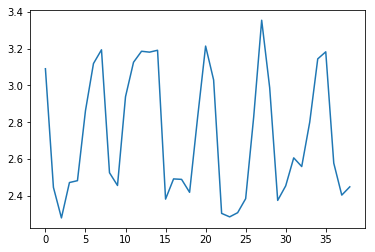

In [29]:
plt.plot(testpreds[129])

In [30]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [31]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.547191   
air_0164b9927d20bcc3_2017-04-23              1.471419   
air_0241aa3964b7f861_2017-04-23              2.407844   
air_0328696196e46f18_2017-04-23              2.008924   
air_034a3d5b40d5b1b1_2017-04-23              3.480609   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   3.698256  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.355411  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.109980  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.455293  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.479490

In [32]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [33]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [34]:
submission.to_csv("../submission/3003nb_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')